# Code for generating figures for Setton et al.
This notebook should reproduce all figure panels except those found in Figure 5, Extended Data Figure 8, and Extended Data Figure 9 (white are related to random forest training).

## Load required packages

In [185]:
suppressWarnings(suppressPackageStartupMessages({
    library(gGnome)
    library(MASS)
    library(ggridges)
    library(wesanderson)
    library(dplyr)
    library(ggplot2)
    library(ggpubr)
    library(gChain)
    library(ComplexHeatmap)
    library(Flow)
}))

## Helper function(s)

In [22]:
dflm = function(x, last = FALSE, nm = '')
{
  if (is.null(x))
    out = data.frame(name = nm, method = as.character(NA), p = as.numeric(NA), estimate = as.numeric(NA), ci.lower = as.numeric(NA),  ci.upper = as.numeric(NA), effect = as.character(NA))
  else if (any(c('lm', 'betareg') %in% class(x)))
  {

    coef = as.data.frame(summary(x)$coefficients)
    colnames(coef) = c('estimate', 'se', 'stat', 'p')
    if (last)
      coef = coef[nrow(coef), ]
    coef$ci.lower = coef$estimate - 1.96*coef$se
    coef$ci.upper = coef$estimate + 1.96*coef$se
    if (!is.null(summary(x)$family))
    {
      fam = summary(x)$family$family
        if (summary(x)$family$link %in% c('log', 'logit'))
        {
          coef$estimate = exp(coef$estimate)
          coef$ci.upper= exp(coef$ci.upper)
          coef$ci.lower= exp(coef$ci.lower)
        }
    }
    else
      fam = 'Unknown'

    if (!last)
      nm = paste(nm, rownames(coef))
    out = data.frame(name = nm, method = fam, p = signif(coef$p, 3), estimate = coef$estimate, ci.lower = coef$ci.lower, ci.upper = coef$ci.upper, effect = paste(signif(coef$estimate, 3), ' [',  signif(coef$ci.lower,3),'-', signif(coef$ci.upper, 3), ']', sep = ''))
  }
  else if (class(x) == 'htest')
  {
    if (is.null(x$estimate))
      x$estimate = x$statistic
    if (is.null(x$conf.int))
      x$conf.int = c(NA, NA)
    out = data.table(name = nm, method = x$method, estimate = x$estimate, ci.lower = x$conf.int[1], ci.upper = x$conf.int[2], effect = paste(signif(x$estimate, 3), ' [',  signif(x$conf.int[1],3),'-', signif(x$conf.int[2], 3), ']', sep = ''), p = x$p.value)
  }
  else if (class(x) == 'polr')
  {
    coef = coef(summary(x)) %>% as.data.frame
    nm = paste(nm, rownames(coef))
    coef = as.data.table(coef)
    setnames(coef, c('estimate', 'se', 't'))
    out = data.table(name = nm) %>% cbind(coef)
    out$p =  pnorm(abs(out$t), lower.tail = FALSE) * 2
    out[, ci.lower := estimate-1.96*se]
    out[, ci.upper := estimate+1.96*se]
    out[, effect := paste(signif(estimate, 3), ' [',  signif(ci.lower,3),'-', signif(ci.upper, 3), ']', sep = '')]
  }
  else
  {
    out = data.frame(name = nm, method = x$method, p = signif(x$p.value, 3), estimate = x$estimate, ci.lower = x$conf.int[1], ci.upper = x$conf.int[2], effect = paste(signif(x$estimate, 3), ' [',  signif(x$conf.int[1],3),'-', signif(x$conf.int[2], 3), ']', sep = ''))
  }

  out$effect = as.character(out$effect)
  out$name = as.character(out$name)
  out$method = as.character(out$method)
  rownames(out) = NULL
  return(as.data.table(out))
}

In [166]:
 ## code for oncotable
oncoprint_hrd <- function (tumors = NULL, oncotab = NULL, genes = c("KRAS", "EGFR", 
    "BRAF", "TP53", "TERT", "CCND1", "MYC", "PIK3CA", "PTEN", 
    "CDKN2A", "ARID1A", "SMARCA4"), metadata.color="black", split = NULL, sort = TRUE, 
    sort.genes = sort, sort.tumors = sort, columns = NULL, noncoding = FALSE, 
    cna = TRUE, tmb = TRUE, pp = TRUE, signature = TRUE, svevents = TRUE, 
    basic = FALSE, ppdf = FALSE, return.oncotab = FALSE, return.mat = FALSE, 
    wes = TRUE, drop = TRUE, drop.genes = FALSE, track.height = 1, 
    signature.thresh = 0.2, signature.main = c(1:5, 7, 9, 13), 
    outframe.fusions = FALSE, track.gap = track.height/2, split.gap = 1, 
    colnames.fontsize = 10, rownames.fontsize = 10, track.fontsize = 10, 
    mc.cores = 1, verbose = FALSE, height = 20, width = 20, ...) 
{
    
    ## define some skitools functions
    border = function (B, na.rm = TRUE) 
    {
    B = array(as.logical(B), dim = dim(B))
    tmp = vector(mode = "numeric", length = nrow(B))
    if (na.rm) 
        B[is.na(B)] = FALSE
    for (i in 1:ncol(B)) tmp = tmp + 2^(ncol(B) - i) * as.numeric(B[, 
        i] == 1)
    return(order(tmp))
    }
    
    ## lol this fucking shit
    brewer.master = function (n, palette = NULL, wes = FALSE, list = FALSE) 
{
    if (wes) {
        palettes = c(Royal2 = 5, Chevalier1 = 4, Darjeeling1 = 5, 
            IsleofDogs1 = 6, Darjeeling2 = 5, Moonrise1 = 4, 
            BottleRocket1 = 7, Rushmore = 5, Moonrise3 = 5, Cavalcanti1 = 5, 
            Rushmore1 = 5, FantasticFox1 = 5, BottleRocket2 = 5, 
            Royal1 = 4, IsleofDogs2 = 5, Moonrise2 = 4, GrandBudapest1 = 4, 
            GrandBudapest2 = 4, Zissou1 = 5)
    }
    else {
        palettes = list(sequential = c(Blues = 9, BuGn = 9, BuPu = 9, 
            GnBu = 9, Greens = 9, Greys = 9, Oranges = 9, OrRd = 9, 
            PuBu = 9, PuBuGn = 9, PuRd = 9, Purples = 9, RdPu = 9, 
            Reds = 9, YlGn = 9, YlGnBu = 9, YlOrBr = 9, YlOrRd = 9), 
            diverging = c(BrBG = 11, PiYG = 11, PRGn = 11, PuOr = 11, 
                RdBu = 11, RdGy = 11, RdYlBu = 11, RdYlGn = 11, 
                Spectral = 11), qualitative = c(Accent = 8, Dark2 = 8, 
                Paired = 12, Pastel1 = 8, Pastel2 = 8, Set1 = 9, 
                Set2 = 8, Set3 = 12))
    }
    palettes = unlist(palettes)
    if (list) 
        return(palettes)
    if (is.null(palette)) 
        palette = names(palettes)[1]
    nms = NULL
    if (is.character(n) | is.factor(n)) {
        nms = unique(n)
        n = length(nms)
    }
    names(palettes) = gsub("\\w+\\.", "", names(palettes))
    if (palette %in% names(palettes)) 
        i = match(palette, names(palettes))
    else i = ((max(c(1, suppressWarnings(as.integer(palette))), 
        na.rm = T) - 1)%%length(palettes)) + 1
    col = c()
    col.remain = n
    while (col.remain > 0) {
        if (col.remain > palettes[i]) {
            next.n = palettes[i]
            col.remain = col.remain - next.n
        }
        else {
            next.n = col.remain
            col.remain = 0
        }
        if (!wes) {
            col = c(col, RColorBrewer::brewer.pal(max(next.n, 
                3), names(palettes[i])))
        }
        else {
            col = c(col, wesanderson::wes_palettes[[names(palettes[i])]])
        }
        i = ((i)%%length(palettes)) + 1
    }
    col = col[1:n]
    names(col) = nms
    return(col)
}
    if (basic) 
        tmb = svevents = signature = FALSE
    if (!length(genes)) 
        stop("genes must be provided either as a vector or named list of gene identifiers")
    if (is.list(genes)) 
        genes = dunlist(genes)[, .(genes = V1, group = listid)]
    else genes = data.table(genes = genes, group = NA)
    genes = genes[!duplicated(genes), ]
    if (!is.null(tumors)) {
        if (!is.null(key(tumors))) 
            tumors$id = tumors[[key(tumors)]]
        if (is.null(tumors$id)) 
            stop("tumors be either keyed or have $id field, if you are resorting e.g. manually sorting your input table the key may get lost so then you should set an $id field explicitly")
        if (any(duplicated(tumors$id))) 
            stop("check key field in tumors table: duplicated ids present. The key should be unique per row, and matched to the $id field of oncotab")
    }
    missing = c()
    if (is.null(oncotab)) {
        errmsg = "Either oncotab or tumors argument must be provided, where tumors is a keyed data table (where each row is a tumor) with column $oncotable of file paths pointing to the cached rds Oncotable results for each tumors"
        if (is.null(tumors) || is.null(tumors$oncotable)) 
            stop(errmsg)
        fe = file.exists(tumors$oncotable)
        missing = union(missing, tumors$id[!fe])
        if (any(!fe)) 
            warning(paste(sum(!fe), "of", length(fe), "tumors with missing oncotab, will remove if drop = TRUE, otherwise mark"))
        if (!nrow(tumors)) 
            stop("No tumors with $oncotable field pointing to existing path")
        if (verbose) 
            message("Scraping $oncotable paths for oncotable .rds files.  To speed up, consider multi-threading with mc.cores and if you will be creating multiple plots.  Also consider running this with return.oncotab = TRUE and use that for subsequent calls via oncotab = argument.")
        oncotab = mclapply(which(fe), function(x) {
            y = readRDS(tumors$oncotable[x])
            if (nrow(y)) 
                y[, `:=`(id, tumors$id[x])]
            return(y)
        }, mc.cores = mc.cores) %>% rbindlist(fill = TRUE)
        oncotab$id = factor(oncotab$id, tumors$id)
    }
    if (!is.null(tumors)) {
        oncotab$id = factor(oncotab$id, tumors$id)
        missing = union(missing, setdiff(tumors$id, oncotab$id))
    }
    else oncotab$id = factor(oncotab$id)
    oncotab = oncotab[!is.na(id), ]
    if (!nrow(oncotab)) {
        if (!is.null(tumors)) 
            stop("empty oncotable provided, check tumors table, there may be an id mismatch or no non empty files")
        else stop("empty oncotable provided, please check inputs")
    }
    
    ### kevin added:
    if (any(ix <- oncotab$type == "homdel")) {
      oncotab[, `:=`(rem, FALSE)]
      oncotab[type %in% c("amp", "hetdel", "homdel"), `:=`(rem, type == "hetdel" & any(type == "homdel")), by = .(gene, id)]
      oncotab = oncotab[rem == FALSE, ]
      oncotab$rem = NULL
    }
    
    vars = oncotab[track == "variants", ][gene %in% genes$genes, 
        ][type != "synonymous", ]
    missing = union(missing, vars[track == "variants" & is.na(type), 
        id])
    if (!noncoding) 
        vars = vars[!(type %in% c("promoter", "noncoding", "regulatory")), 
            ]
    if (!cna) 
        vars = vars[!(type %in% c("amp", "hetdel", "del", "loh", "homdel")), 
            ]
    vars[, `:=`(gene, factor(gene, genes$genes))]
    vars = vars[!is.na(gene), ]
    if (nrow(vars)) {
        varc = dcast.data.table(data = vars, gene ~ id, value.var = "type", 
            fill = "WT", drop = FALSE, fun.aggregate = function(x) paste(x, 
                collapse = ","))
        varm = as.matrix(varc[, -1])
        rownames(varm) = varc$gene
    }
    else {
        varm = matrix("WT", nrow = length(levels(vars$gene)), 
            ncol = length(levels(vars$id)), dimnames = list(levels(vars$gene), 
                levels(vars$id)))
    }
    if (length(missing)) {
        if (!drop) 
            varm[, intersect(colnames(varm), missing)] = "missing"
        else varm = varm[, setdiff(colnames(varm), missing)]
    }
    if (sort.genes) {
        ix = rev(order(rowSums(varm != "WT" & varm != "missing", 
            na.rm = TRUE)))
        varm = varm[ix, , drop = FALSE]
    }
    if (sort.tumors) {
        jx = rev(border(t(varm) != "WT" & t(varm) != 
            "missing"))
        varm = varm[, jx, drop = FALSE]
    }
    ord = c("amp", "hetdel", "del", "loh", "homdel", "trunc", "germ_sv", "splice", 
        "inframe_indel", "fusion", "missense", "promoter", "regulatory")
    if (outframe.fusions == TRUE) {
        ord = c("amp", "hetdel", "del", "loh", "homdel", "trunc", "germ_sv", "splice", 
            "inframe_indel", "outframe_fusion", "fusion", "missense", 
            "promoter", "regulatory")
    }
    alter_fun = function(x, y, w, h, v) {
        CSIZE = 0.25
        w = convertWidth(w, "cm") * 0.7
        h = convertHeight(h, "cm") * 0.7
        l = min(unit.c(w, h))
        grid.rect(x, y, w, h, gp = gpar(fill = skitools::alpha("grey90", 
            0.4), col = NA))
        v = v[ord]
        for (i in which(v)) {
            if (names(v)[i] %in% c("amp", "hetdel", "del", "loh", "homdel", "fusion", "outframe_fusion")) 
                grid.rect(x, y, w, h, gp = gpar(fill = varcol[names(v)[i]], 
                  col = NA))
            else if (grepl("missing", names(v)[i])) 
                grid.rect(x, y, w, h, gp = gpar(fill = varcol[names(v)[i]], 
                  col = NA))
            else if (grepl("trunc", names(v)[i])) {
                grid.segments(x - w * 0.5, y - h * 0.5, x + w * 
                  0.5, y + h * 0.5, gp = gpar(lwd = 2, col = varcol[names(v)[i]]))
                grid.segments(x - w * 0.5, y + h * 0.5, x + w * 
                  0.5, y - h * 0.5, gp = gpar(lwd = 2, col = varcol[names(v)[i]]))
            }
            else if (grepl("(missense)|(promoter)|(regulatory)|(splice)", names(v)[i])) {
                grid.circle(x, y, l * CSIZE, gp = gpar(fill = varcol[names(v)[i]], 
                  col = NA))
            } else if (grepl("germ_sv", names(v)[i])) {
                grid.rect(x, y, w*0.5, h*0.5, gp = gpar(lwd = 2, col = varcol[names(v)[i]]))
            } else {
                if (grepl("indel", names(v)[i])) 
                  grid.rect(x, y, w * 0.9, h * 0.4, gp = gpar(fill = varcol[names(v)[i]], 
                    col = NA))
            }
        }
    }
    varcol = c(WT = gTrack:::alpha("gray", 0), 
               fusion = gTrack:::alpha("green", 0.5), 
               outframe_fusion = gTrack:::alpha("greenyellow", 0.5), 
               hetdel = "lightblue", 
               missing = "gray", 
               amp = "red", 
               loh = "#C4F1B6",   ### kevin added, kat changed color
               drop = FALSE, 
               homdel = "#4364A4",
               del = "cyan", 
               missense = "gray40", 
               germ_sv = wes_palette("Royal1")[2],
               inframe_indel = "darkgreen", 
               promoter = gTrack:::alpha("red", 0.5), 
               regulatory = gTrack:::alpha("red", 0.2), 
               trunc = gTrack:::alpha("black", 0.8), 
               mir = gTrack:::alpha("purple", 0.4), 
               splice = "purple")
    ids = colnames(varm)
    out.mat = varm
    bottom_data = top_data = list()
    if (tmb & any(oncotab$track == "tmb")) {
        tmbd = oncotab[track == "tmb" & type == "density", structure(value, 
            names = as.character(id))][ids]
        if (!all(tmbd == 0)) {
            top_data$TMB = tmbd
            out.mat = rbind(TMB = tmbd, out.mat)
        }
    }
    if (pp & any(oncotab$track == "pp")) {
        top_data$Purity = oncotab[track == "pp" & type == "purity", 
            structure(value, names = as.character(id))][ids]
        top_data$Ploidy = oncotab[track == "pp" & type == "ploidy", 
            structure(value, names = as.character(id))][ids]
        out.mat = rbind(Purity = top_data$Purity, Ploidy = top_data$Ploidy, 
            out.mat)
    }
    ab = ComplexHeatmap::anno_oncoprint_barplot(border = FALSE, height = unit(track.height, 
        "cm"))
    toptracks = HeatmapAnnotation(column_barplot = ab)
    if (length(top_data)) {
        topcols = brewer.master(names(top_data))
        tmp = lapply(names(top_data), function(x) anno_barplot(top_data[[x]], 
            border = FALSE, axis_param = list(gp = gpar(fontsize = track.fontsize)), 
            height = unit(track.height, "cm"), gp = gpar(fill = topcols[x], 
                col = topcols[x])))
        names(tmp) = names(top_data)
        tmp$gap = unit(track.gap, "cm")
        toptracks = do.call(HeatmapAnnotation, c(tmp, list(column_barplot = ab)))
    }
    packed_legends = list()
    bottomtracks = list()
    if (signature & any(oncotab$track == "signature")) {
        sigd = oncotab[track == "signature", ][type != "Residual", 
            ]
        signature.keep = paste("Signature", signature.main, sep = "_") %>% 
            union(sigd[frac > signature.thresh, type])
        sigd[, `:=`(type, ifelse(type %in% signature.keep, as.character(gsub("Signature_", 
            "", type)), "other"))]
        sigdc = dcast.data.table(sigd, id ~ type, value.var = "frac", 
            fun.aggregate = sum, drop = FALSE)
        sigdm = as.matrix(sigdc[, -1])
        rownames(sigdm) = sigdc$id
        sigdm = sigdm[ids, , drop = FALSE]
        sigdm = sigdm[, suppressWarnings(order(as.numeric(colnames(sigdm)))), 
            drop = FALSE]
        out.mat = rbind(out.mat, t(sigdm))
        if (wes) 
            sigcols = brewer.master(colnames(sigdm), "BottleRocket1", 
                wes = TRUE)
        else sigcols = brewer.master(colnames(sigdm), "Dark2")
        sigcols["other"] = "gray"
        bottomtracks$COSMIC = anno_barplot(sigdm, legend = TRUE, 
            axis_param = list(gp = gpar(fontsize = track.fontsize)), 
            height = unit(3 * track.height, "cm"), border = FALSE, 
            gp = gpar(fill = sigcols, col = sigcols))
        packed_legends = c(packed_legends, list(Legend(labels = names(sigcols), 
            ncol = 2, legend_gp = gpar(fill = sigcols), title = "COSMIC")))
    }
    if (svevents & any(oncotab$track %in% c("complex sv", "simple sv"))) {
        cx = dcast.data.table(oncotab[track == "complex sv", 
            ][, `:=`(type, as.character(type))][, `:=`(id, factor(id, 
            ids))], id ~ type, fill = 0, drop = FALSE, value.var = "value")
        simple = dcast.data.table(oncotab[track == "simple sv", 
            ][, `:=`(type, as.character(type))][, `:=`(id, factor(id, 
            ids))], id ~ type, fill = 0, drop = FALSE, value.var = "value")
        out.mat = rbind(out.mat, t(as.matrix(cx[, -1])), t(as.matrix(simple[, 
            -1])))
        uev = names(cx)[-1]
        if (wes) {
            cxcols = brewer.master(names(cx)[-1], "IsleOfDogs1", 
                wes = TRUE)
            simplecols = brewer.master(names(simple)[-1], "Zissou1", 
                wes = TRUE)
        }
        else {
            cxcols = brewer.master(names(cx)[-1], "Accent", wes = FALSE)
            simplecols = brewer.master(names(simple)[-1], "Pastel1", 
                wes = FALSE)
        }
        cxtracks = lapply(names(cx)[-1], function(x) anno_barplot(cx[[x]], 
            legend = TRUE, axis_param = list(gp = gpar(fontsize = track.fontsize)), 
            height = unit(track.height, "cm"), border = FALSE, 
            gp = gpar(fill = cxcols[x], col = NA)))
        names(cxtracks) = names(cx)[-1]
        simpletracks = lapply(names(simple)[-1], function(x) anno_barplot(simple[[x]], 
            legend = TRUE, axis_param = list(gp = gpar(fontsize = track.fontsize)), 
            height = unit(track.height, "cm"), border = FALSE, 
            gp = gpar(fill = simplecols[x], col = NA)))
        names(simpletracks) = names(simple)[-1]
        bottomtracks = c(bottomtracks, simpletracks, cxtracks)
    }
    if (!is.null(tumors) && length(intersect(columns, names(tumors)))) {
        columns = intersect(columns, names(tumors))
        custom = tumors[match(ids, id), columns, with = FALSE]
        out.mat = rbind(out.mat, t(as.matrix(custom)))
        message(columns)
        customcols = brewer.master(columns)
        customtracks = lapply(columns, function(x) {
            if (is.character(custom[[x]]) | is.factor(custom[[x]]) | 
                is.logical(custom[[x]])) {
                if (is.logical(custom[[x]])) 
                  cols = c(`FALSE` = "#E7E7E7", `TRUE` = metadata.color)
                else cols = brewer.master(unique(custom[[x]]), 
                  wes = wes)
                list(anno = anno_simple(as.character(custom[[x]]), 
                  height = unit(track.height/2, "cm"), col = cols), 
                  legend = Legend(labels = names(cols), ncol = 2, 
                    legend_gp = gpar(fill = cols, col = NA), 
                    title = x))
            }
            else list(anno = anno_barplot(custom[[x]], legend = TRUE, 
                axis_param = list(gp = gpar(fontsize = track.fontsize)), 
                height = unit(track.height, "cm"), border = FALSE, 
                gp = gpar(fill = customcols[x], col = NA)))
        })
        customanno = lapply(customtracks, function(x) x$anno)
        names(customanno) = columns
        bottomtracks = c(bottomtracks, customanno)
        ix = lengths(customtracks) == 2
        if (any(ix)) 
            packed_legends = c(packed_legends, lapply(customtracks[ix], 
                function(x) x$legend))
    }
    if (length(bottomtracks)) {
        bottomtracks$gap = unit(track.gap, "cm")
        bottomtracks = do.call(HeatmapAnnotation, bottomtracks)
    }
    if (length(packed_legends)) 
        packed_legends = do.call(packLegend, packed_legends)
    if (!is.null(split)) {
        if (is.null(tumors)) 
            warning("split variable must be provided along with keyed tumors table")
        if (split %in% names(tumors)) 
            split = tumors[match(ids, id), ][[split]]
        else {
            warning("split column not found in provided tumors table")
            split = NULL
        }
    }
    gene_split = NULL
    if (!all(is.na(genes$group))) 
        gene_split = genes[match(rownames(varm), genes), group]
    show_pct = TRUE
    if (any(varm != "WT")) 
        varm[varm == "WT"] = ""
    else show_pct = FALSE
    if (!length(toptracks)) 
        toptracks = NULL
    if (!length(bottomtracks)) 
        bottomtracks = NULL
    varm[1, 1] = ifelse(nchar(varm[1, 1]), paste(varm[1, 1], 
        "dummy", sep = ","), varm[1, 1])
    op = ComplexHeatmap::oncoPrint(varm, get_type = function(x) unlist(strsplit(x, 
        ",")), alter_fun = alter_fun, top_annotation = toptracks, 
        bottom_annotation = bottomtracks, row_split = gene_split, 
        show_pct = show_pct, row_gap = unit(split.gap, "cm"), 
        column_split = split, column_gap = unit(split.gap, "cm"), 
        col = varcol, remove_empty_columns = FALSE, remove_empty_rows = drop.genes, 
        row_order = 1:nrow(varm), column_order = 1:ncol(varm), 
        pct_gp = gpar(fontsize = rownames.fontsize), row_names_gp = gpar(fontsize = rownames.fontsize), 
        column_names_gp = gpar(fontsize = colnames.fontsize), 
        show_column_names = TRUE, show_heatmap_legend = TRUE)
    if (ppdf) 
        if (length(packed_legends)) 
            skitools::ppdf(draw(op, annotation_legend_list = packed_legends), 
                height = height, width = width, ...)
        else skitools::ppdf(draw(op), height = height, width = width, 
            ...)
    if (return.oncotab) 
        oncotab
    else if (return.mat) 
        out.mat
    else op
}

# Figure 1

## Figure 1b
Gap segment lengths and polarities of three canonical reciprocal pair patterns plotted across BRCA1-deficient (BRCA1d), BRCA2-deficient (BRCA2d), or HR-proficient (HRP) cases.

In [9]:
## load inputs
## slim.pairs = readRDS("~/projects/Starr/BRCA/db/slim.pairs.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
events.dt = readRDS("./data/revision.events.dt.rds")

In [10]:
## subset events for quasi-reciprocal junction pairs in the initial BOPP cohort
bopp.qrps.dt = events.dt[sample %in% hrd_tbl[(init_bopp_cohort), pair] & type %like% "qrp"]

## add genotype information
bopp.qrps.dt[, genotype := hrd_tbl[sample, fmut_bi]]

## add gap one and gap two log widths
bopp.qrps.dt[, gap1.sign := ifelse(as.character(strand.l1) == "+", 1, -1)]
bopp.qrps.dt[, gap2.sign := ifelse(as.character(strand.l2) == "+", 1, -1)]
bopp.qrps.dt[, gap1 := log10(width.l1) * gap1.sign]
bopp.qrps.dt[, gap2 := log10(width.l2) * gap2.sign]

## create simplified table for plotting
width.dt = bopp.qrps.dt[, .(sample, type, ev.id, gap1, gap2, genotype)]

In [11]:
## get output from kde2d
res.dt = lapply(c("WT", "BRCA1", "BRCA2"),
               function(gn) {
                   res = width.dt[genotype == gn, 
                                  MASS::kde2d(x = gap1, 
                                              y = gap2, 
                                              h = c(MASS::bandwidth.nrd(gap1), MASS::bandwidth.nrd(gap2)), 
                                              n = 50, 
                                              lims = c(c(-7,7), c(-7,7)))]
                   matrix.cols = setdiff(names(res), c("x", "y"))
                   mat = as.matrix(res[, ..matrix.cols])
                   rownames(mat) = res$x
                   colnames(mat) = res$y
                   res.dt = reshape2::melt(mat) %>% as.data.table %>% setnames(old = c("Var1", "Var2", "value"), new = c("x", "y", "z"))
                   res.dt[, genotype := gn]
                   res.dt[, n.samples := width.dt[genotype == gn, length(unique(sample))]]
                   return(res.dt)
               })


## this is a grid of values (melted)
## with columns x, y, z, genotype, n.samples
res.dt = rbindlist(res.dt, fill = TRUE)

In [14]:
## the z-axis is the density divided by the number of input samples with that genotype
pt = ggplot(res.dt, aes(x = x,y = y,z = z / n.samples, fill  = ..level..)) + 
    stat_contour(geom = "polygon", bins = 50)  + 
    scale_fill_gradient(
        low = alpha(scales::muted("red"), 10 / 255),
        high = scales::muted("red"),
        limits = range(res.dt[, z / n.samples]),
        na.value = scales::muted("red")
    ) +
    facet_grid(~ genotype) +
    labs(x = "gap 1 width (log10 bp)", y = "gap 2 width (log10 bp)") +
    ggpubr::theme_pubr()

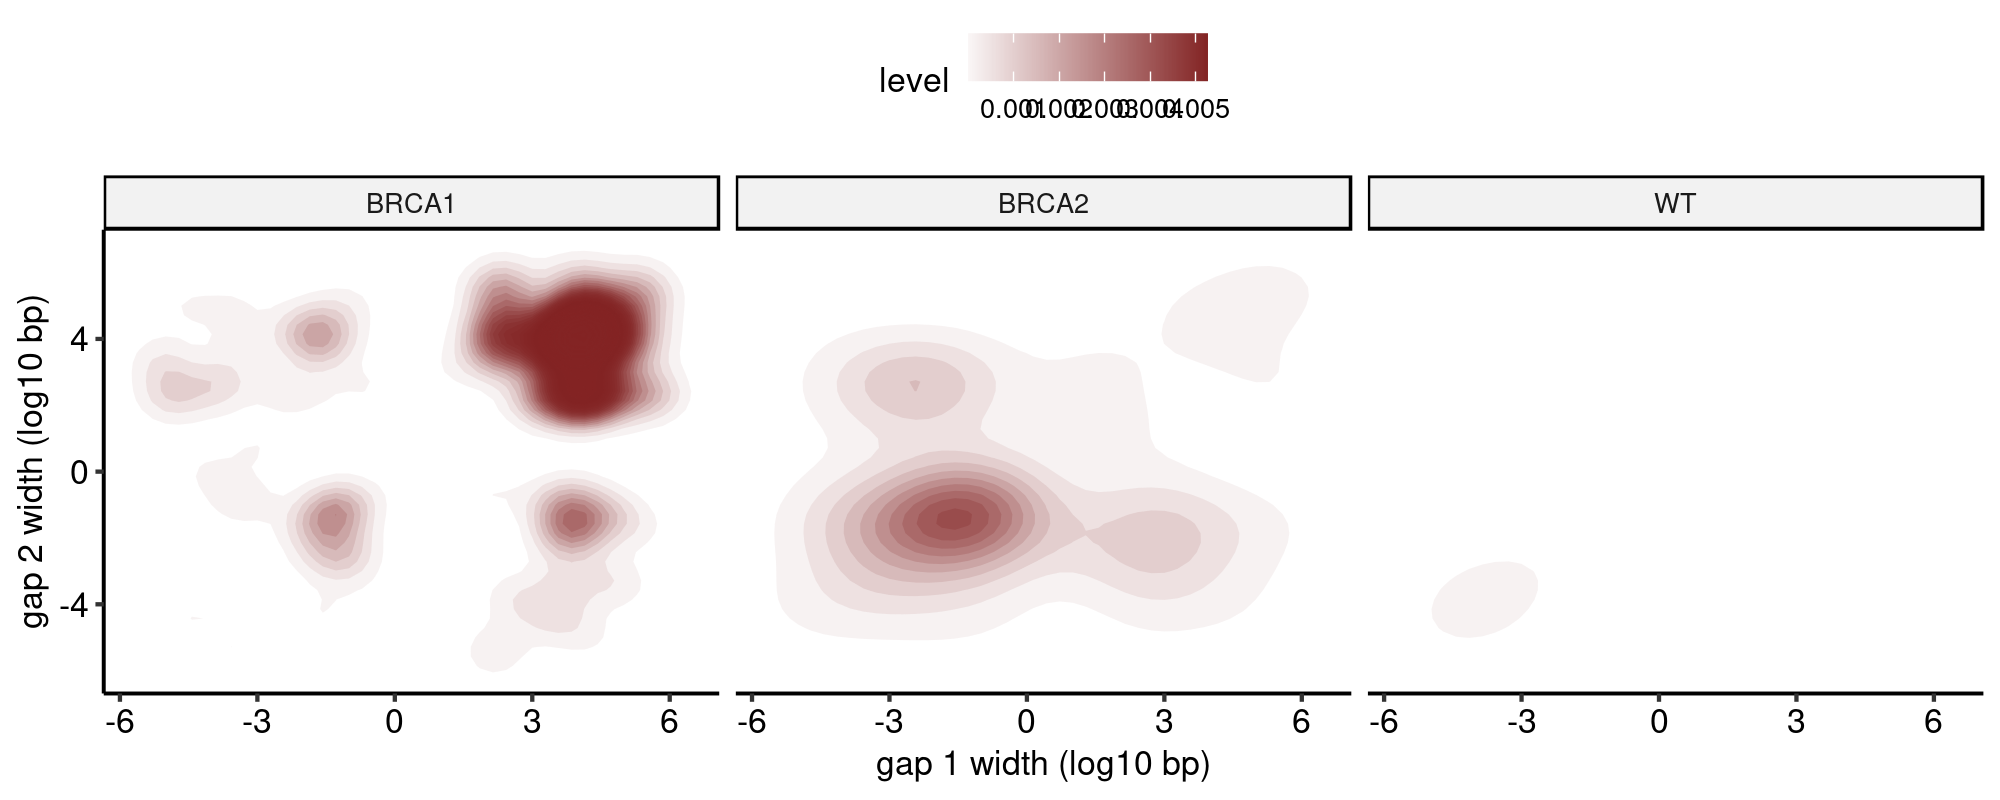

In [17]:
options(repr.plot.height = 4, repr.plot.width = 10, repr.plot.res = 200)
pt

## Figure 1c, 1d, and 1e
Violin plots showing the relative burdens of rDups, rDels, and rDelDups across 15 BRCA1d, 13 BRCA2d or 236 HR-proficient (HRP) samples, which are independent from data in panel 1b. P values obtained by Wald test on a gamma-Poisson regression model.

In [18]:
## load inputs
##slim.pairs = readRDS("~/projects/Starr/BRCA/db/slim.pairs.rds")
## hrd_tbl = readRDS("~/projects/Starr/BRCA/db/hrd-supp-table.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
events.dt = readRDS("./data/revision.events.dt.rds")

In [19]:
## subset events for quasi-reciprocal junction pairs in the initial BOPP cohort
bopp.qrp.counts.dt = dcast.data.table(events.dt[(type %like% "qrp"), .(n.events = .N), by = .(sample, type)], 
                                      sample ~ type, 
                                      value.var = "n.events",
                                      fill = 0)

setkey(bopp.qrp.counts.dt, "sample")
bopp.qrp.counts.dt = bopp.qrp.counts.dt[hrd_tbl[(init_bopp_cohort), pair]]
bopp.qrp.counts.dt[is.na(bopp.qrp.counts.dt)] = 0

## add genotype information
bopp.qrp.counts.dt[, genotype := ordered(hrd_tbl[sample, fmut_bi], levels = c("BRCA1", "BRCA2", "WT"))]

### Generate plot for rDups (1c)

In [20]:
library(ggplot2)
pt = ggplot(bopp.qrp.counts.dt[!is.na(genotype)], aes(x = genotype, y = qrppos, fill = genotype)) +
geom_violin(width = 1, scale = "width") +
labs(x = "genotype", y = "events per sample", title = "rDups") +
ggpubr::theme_pubr()

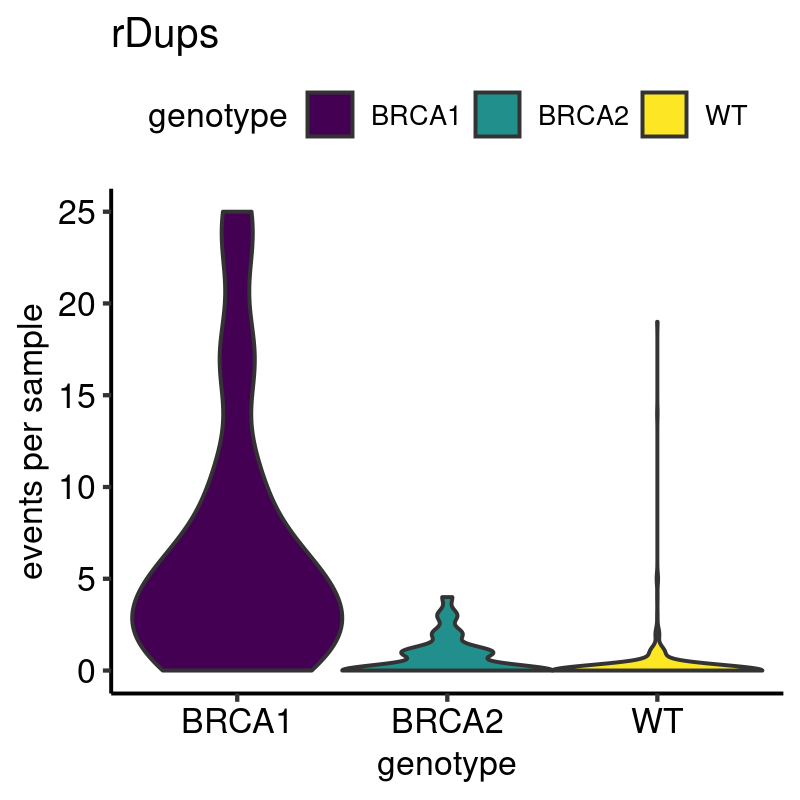

In [21]:
options(repr.plot.height = 4, repr.plot.width = 4)
pt

### Statistical testing for 1c - comparison to WT

In [23]:
pvals.dt = lapply(c("BRCA1", "BRCA2"),
       function(gn) {
           dt = bopp.qrp.counts.dt[genotype == "WT" | genotype == gn]
           res = MASS::glm.nb(data = dt, formula = qrppos ~ (genotype == gn))
           out = dflm(res)
           out[, genotype := gn]
       })

pvals.dt = rbindlist(pvals.dt)[!(name %like% "Intercept")]
pvals.dt

name                method                    p        estimate  ci.lower 
1  genotype == gnTRUE Negative Binomial(0.1468) 6.54e-10 31.830065 10.616046
2  genotype == gnTRUE Negative Binomial(0.1066) 3.68e-02  3.315632  1.076128
  ci.upper effect           genotype
1 95.43601 31.8 [10.6-95.4] BRCA1   
2 10.21571 3.32 [1.08-10.2] BRCA2

In [24]:
## comparing BRCA1 and BRCA2
res = MASS::glm.nb(data = bopp.qrp.counts.dt[genotype != "WT"],
                  formula = qrppos ~ (genotype == "BRCA1"))

dflm(res)

name                     method                    p        estimate 
1  (Intercept)             Negative Binomial(1.1049) 1.53e-01 0.6944444
2  genotype == "BRCA1"TRUE Negative Binomial(1.1049) 7.51e-12 9.6000000
  ci.lower  ci.upper  effect            
1 0.4211006  1.145221 0.694 [0.421-1.15]
2 5.0247311 18.341280 9.6 [5.02-18.3]

### Generate plot for rDels (1d)

In [25]:
pt = ggplot(bopp.qrp.counts.dt[!is.na(genotype)], aes(x = genotype, y = qrpmin, fill = genotype)) +
geom_violin(width = 1,scale = "width") +
labs(x = "genotype", y = "events per sample", title = "rDels") +
ggpubr::theme_pubr()

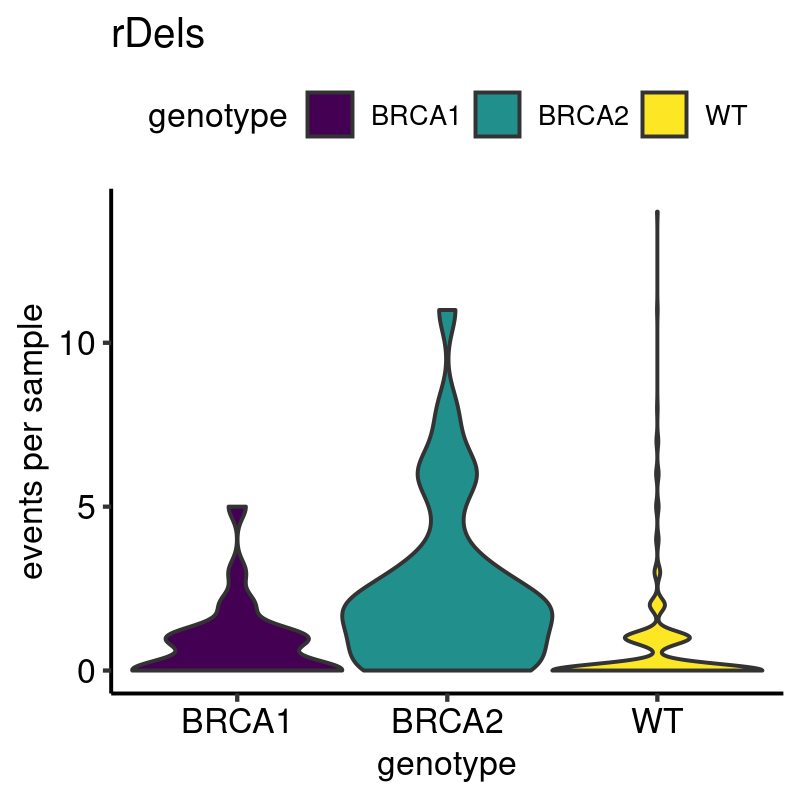

In [26]:
options(repr.plot.height = 4, repr.plot.width = 4)
pt

### Statistical testing for rDels (1d)

In [27]:
pvals.dt = lapply(c("BRCA1", "BRCA2"),
       function(gn) {
           dt = bopp.qrp.counts.dt[genotype == "WT" | genotype == gn]
           res = MASS::glm.nb(data = dt, formula = qrpmin ~ (genotype == gn))
           out = dflm(res)
           out[, genotype := gn]
       })

pvals.dt = rbindlist(pvals.dt)
pvals.dt

name                method                    p        estimate  ci.lower 
1  (Intercept)        Negative Binomial(0.4232) 1.88e-08 0.5995893 0.5016647
2  genotype == gnTRUE Negative Binomial(0.4232) 4.06e-01 1.3898402 0.6396965
3  (Intercept)        Negative Binomial(0.487)  4.87e-09 0.5995893 0.5051784
4  genotype == gnTRUE Negative Binomial(0.487)  2.15e-07 4.1695205 2.4307359
  ci.upper  effect            genotype
1 0.7166287 0.6 [0.502-0.717] BRCA1   
2 3.0196440 1.39 [0.64-3.02]  BRCA1   
3 0.7116444 0.6 [0.505-0.712] BRCA2   
4 7.1521147 4.17 [2.43-7.15]  BRCA2

In [28]:
## comparing BRCA1 and BRCA2
res = MASS::glm.nb(data = bopp.qrp.counts.dt[genotype != "WT"],
                  formula = qrpmin ~ (genotype == "BRCA2"))

dflm(res)

name                     method                    p        estimate 
1  (Intercept)             Negative Binomial(1.5172) 0.512000 0.8333333
2  genotype == "BRCA2"TRUE Negative Binomial(1.5172) 0.000778 3.0000000
  ci.lower ci.upper effect            
1 0.482954 1.437910 0.833 [0.483-1.44]
2 1.580638 5.693904 3 [1.58-5.69]

### Generate plot for rDelDups (1e)

In [29]:
pt = ggplot(bopp.qrp.counts.dt[!is.na(genotype)], aes(x = genotype, y = qrpmix, fill = genotype)) +
geom_violin(width = 1, scale = "width") +
labs(x = "genotype", y = "events per sample", title = "rDelDups") +
ggpubr::theme_pubr()

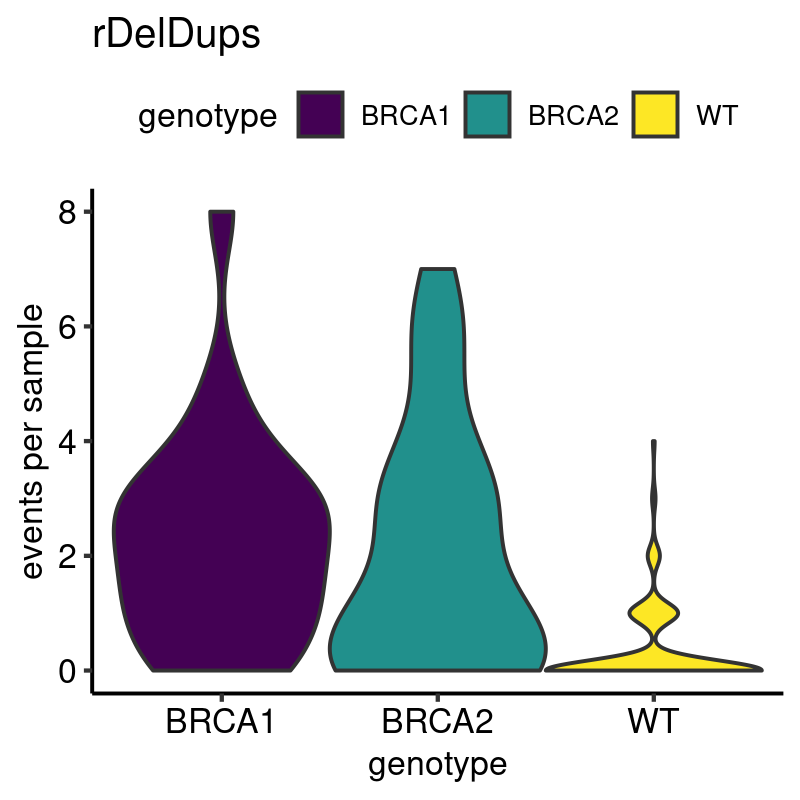

In [30]:
options(repr.plot.height = 4, repr.plot.width = 4)
pt

### Statistical testing for rDelDups

In [31]:
pvals.dt = lapply(c("BRCA1", "BRCA2"),
       function(gn) {
           dt = bopp.qrp.counts.dt[genotype == "WT" | genotype == gn]
           res = MASS::glm.nb(data = dt, formula = qrpmix ~ (genotype == gn))
           out = dflm(res)
           out[, genotype := gn]
       })

pvals.dt = rbindlist(pvals.dt)
pvals.dt

name                method                    p        estimate  ci.lower 
1  (Intercept)        Negative Binomial(1.1937) 1.53e-36 0.3203285 0.2684367
2  genotype == gnTRUE Negative Binomial(1.1937) 3.94e-15 7.0240385 4.3191284
3  (Intercept)        Negative Binomial(0.849)  8.72e-34 0.3203285 0.2664489
4  genotype == gnTRUE Negative Binomial(0.849)  2.31e-14 6.0701567 3.8200401
  ci.upper   effect             genotype
1  0.3822516 0.32 [0.268-0.382] BRCA1   
2 11.4229336 7.02 [4.32-11.4]   BRCA1   
3  0.3851034 0.32 [0.266-0.385] BRCA2   
4  9.6456586 6.07 [3.82-9.65]   BRCA2

In [32]:
## comparing BRCA1 and BRCA2
res = MASS::glm.nb(data = bopp.qrp.counts.dt[genotype != "WT"],
                  formula = qrpmix ~ (genotype == "BRCA1"))

dflm(res)

name                     method                    p        estimate
1  (Intercept)             Negative Binomial(1.8256) 0.000108 1.944444
2  genotype == "BRCA1"TRUE Negative Binomial(1.8256) 0.583000 1.157143
  ci.lower  ci.upper effect           
1 1.3886443 2.722702 1.94 [1.39-2.72] 
2 0.6867898 1.949621 1.16 [0.687-1.95]

## Fig. 1f
Distribution of junction spans associated with different classes of reciprocal pair SVs.  Note that junction span is distinct from gap segment length; the former refers to the genomic distance between the two breakends belonging to a junction, while the latter refers to the distance between reciprocal breakends belonging to distinct junctions. 

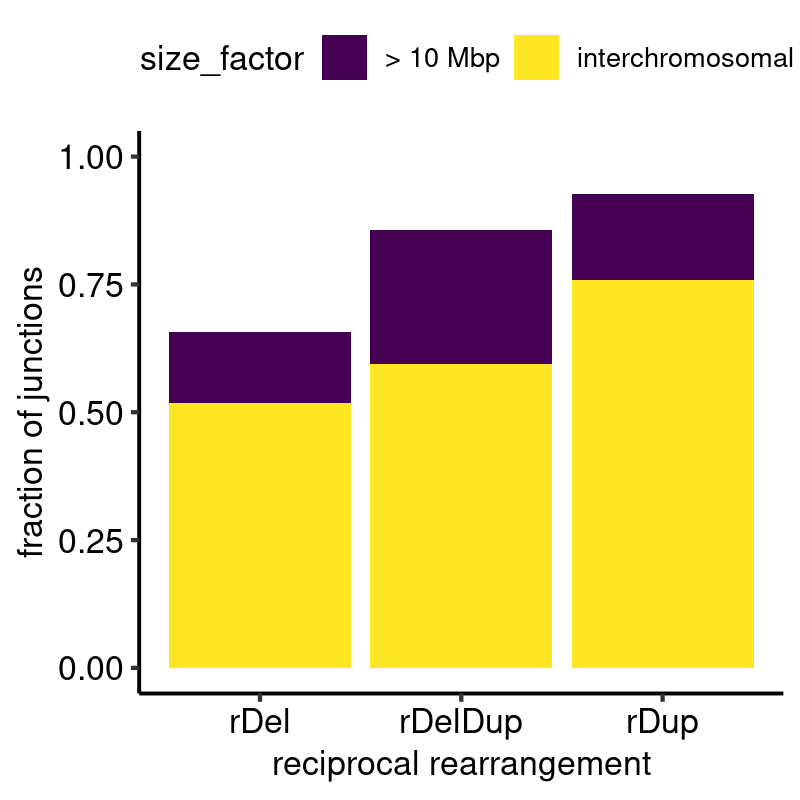

In [150]:
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
events.dt = readRDS("./data/revision.events.dt.rds")

## use aug_bopp_cohort and BRCA1/2 mutants only
qrp.events.dt = events.dt[(type %like% "qrp") & 
                          (sample %in% hrd_tbl[(fmut_bi == "BRCA1" | fmut_bi == "BRCA2"), pair]) &
                          (sample %in% hrd_tbl[(aug_bopp_cohort), pair])]

## add size annotation to events (what is the distance bw the gaps?)
qrp.events.dt[, size_category := ifelse(intrachromosomal, ifelse(abs(start.l1 - start.l2) > 1e7, "> 10 Mbp", "< 10 Mbp"), "interchromosomal")]

## change the qrp type for consistency
qrp.map = c("qrppos" = "rDup", "qrpmix" = "rDelDup", "qrpmin" = "rDel")
qrp.events.dt[, qrp_type := qrp.map[type]]

pt.dt = qrp.events.dt[, .(njun = .N), by = .(qrp_type, size_category)]
pt.dt[, frac := njun / sum(njun), by = qrp_type]

## turn the size category into factors
pt.dt[, size_factor := ordered(size_category, levels = c("< 10 Mbp", "> 10 Mbp", "interchromosomal"))]

## turn the type into factors
pt.dt[, type_factor := ordered(qrp_type, levels = c("rDel", "rDelDup", "rDup"))]

pt = ggplot(pt.dt[size_category != "< 10 Mbp"], aes(x = type_factor, y = frac, fill = size_factor)) + 
geom_bar(stat = "identity", position = "stack") +
ggpubr::theme_pubr() +
ylim(0,1) +
labs(x = "reciprocal rearrangement", y = "fraction of junctions")

options(repr.plot.height = 4, repr.plot.width = 4)
pt

# Extended data figure 1

Comparing the burden of SV classes across genotypes.

## ED1a
Comparison of the burden (count) of simple SV classes.

In [33]:
## load inputs
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
junctions.dt = readRDS("./data/revision.junctions.dt.rds")
events.dt = readRDS("./data/revision.events.dt.rds")

In [34]:
## divide up junctions by width class
cut.points = c(0, 1e5, 1e6, 1e7, 1e16)
cut.labels = c("< 100 Kbp", "100 Kbp - 1 Mbp", "1 Mbp - 10 Mbp", "> 10 Mbp")

junctions.dt[(!is.na(dup)) | (!is.na(del)), width.class := cut(span, breaks = cut.points, labels = cut.labels)]
junctions.dt[!((class == "DEL-like") | (class == "DUP-like")), width.class := ""]
junctions.dt[, category := paste(gsub("-like", "", class), width.class)]

## get the count per class for each sample of simple events
counts = junctions.dt[(!is.na(simple)) | (!is.na(dup)) | (!is.na(del)), 
                      .(count = .N), 
                      keyby = .(category, sample)]

## make sure every class x sample combo is included
bopp.counts.dt = as.data.table(expand.grid(category = unique(junctions.dt[, category]),
                                           sample = hrd_tbl[(init_bopp_cohort), pair]))

bopp.counts.dt[, category := as.character(category)]
bopp.counts.dt[, sample := as.character(sample)]

setkeyv(bopp.counts.dt, c("category", "sample"))

bopp.counts.dt[, count := counts[bopp.counts.dt, count]]
bopp.counts.dt[is.na(count), count := 0]
bopp.counts.dt[, genotype := hrd_tbl[as.character(sample), fmut_bi]]

### Deletions stratified by size

In [41]:
## create a plot for deletions first
pt.dt = bopp.counts.dt[as.character(category) %like% "DEL"]
pt.dt[, category_level := ordered(as.character(category), levels = c("DEL < 100 Kbp",
                                                                     "DEL 100 Kbp - 1 Mbp",
                                                                     "DEL 1 Mbp - 10 Mbp",
                                                                     "DEL > 10 Mbp"))]

## create levels for genotype
pt.dt[, genotype_level := ordered(genotype, levels = c("BRCA1", "BRCA2", "WT"))]

pt = ggplot(pt.dt[!is.na(category_level)], 
            aes(x = genotype_level, y = count, fill = genotype_level)) +
    geom_violin(scale = "width") +
    facet_wrap(~ category_level, scales = "free", ncol = 4) +
    ggpubr::theme_pubr() + 
    theme(axis.text.x = element_text(angle = 90))

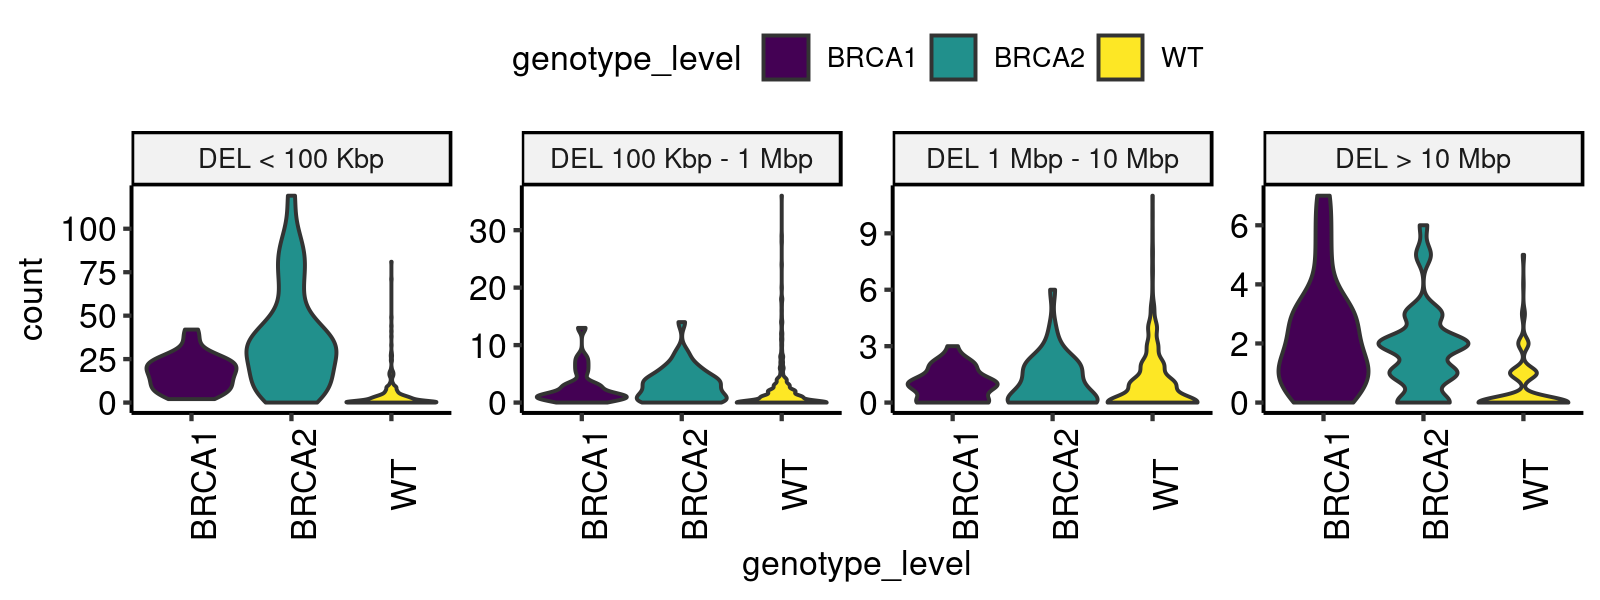

In [42]:
options(repr.plot.height = 3, repr.plot.width = 8)
pt

### Comparing BRCA1d/BRCA2d SV burdens to WT

In [46]:
## statistical testing - comparison to WT
combos = expand.grid(genotype = c("BRCA1", "BRCA2"),
                     category = pt.dt[!as.character(category) %like% "NA"][, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[(genotype == "WT" | genotype == gn) &
                                    (as.character(category) == sv) &
                                    (!is.na(genotype)) &
                                    (!is.na(category)),],
                       formula = count ~ (as.character(genotype) == gn))
    dt = dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt[, p.adj := stats::p.adjust(p)]


In [47]:
pvals.dt

name                              method                    p       
1  as.character(genotype) == gnTRUE Negative Binomial(0.9187) 7.00e-01
2  as.character(genotype) == gnTRUE Negative Binomial(0.8865) 8.23e-01
3  as.character(genotype) == gnTRUE Negative Binomial(0.4662) 4.08e-01
4  as.character(genotype) == gnTRUE Negative Binomial(0.4732) 1.03e-01
5  as.character(genotype) == gnTRUE Negative Binomial(0.4691) 3.49e-06
6  as.character(genotype) == gnTRUE Negative Binomial(0.4714) 3.66e-18
7  as.character(genotype) == gnTRUE Negative Binomial(0.9931) 1.29e-08
8  as.character(genotype) == gnTRUE Negative Binomial(1.134)  2.56e-09
  estimate  ci.lower  ci.upper  effect             genotype category           
1 0.8889683 0.4890320  1.615977 0.889 [0.489-1.62] BRCA1    DEL 1 Mbp - 10 Mbp 
2 1.0564550 0.6537913  1.707116 1.06 [0.654-1.71]  BRCA2    DEL 1 Mbp - 10 Mbp 
3 1.3163257 0.6868118  2.522836 1.32 [0.687-2.52]  BRCA1    DEL 100 Kbp - 1 Mbp
4 1.5525893 0.9151398  2.634060 1.55 [0.915-2.63]  BRCA2    DEL 100 Kbp - 1 Mbp
5 4.2141865 2.2950389  7.738155 4.21 [2.3-7.74]    BRCA1    DEL < 100 Kbp      
6 9.0914323 5.5256795 14.958186 9.09 [5.53-15]     BRCA2    DEL < 100 Kbp      
7 4.3782849 2.6321562  7.282766 4.38 [2.63-7.28]   BRCA1    DEL > 10 Mbp       
8 3.5924389 2.3586595  5.471590 3.59 [2.36-5.47]   BRCA2    DEL > 10 Mbp       
  p.adj    
1 1.000e+00
2 1.000e+00
3 1.000e+00
4 4.120e-01
5 1.745e-05
6 2.928e-17
7 7.740e-08
8 1.792e-08

### Comparing SV burdens between BRCA1d and BRCA2d

In [50]:
## statistical testing - comparison between BRCA1 and BRCA2
combos = expand.grid(genotype = c("BRCA1"),
                     category = pt.dt[!as.character(category) %like% "NA"][, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "BRCA2" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt[, p.adj := stats::p.adjust(p)]

In [51]:
pvals.dt

name                              method                    p       
1  as.character(genotype) == gnTRUE Negative Binomial(3.7474) 0.557000
2  as.character(genotype) == gnTRUE Negative Binomial(1.442)  0.539000
3  as.character(genotype) == gnTRUE Negative Binomial(1.6398) 0.000314
4  as.character(genotype) == gnTRUE Negative Binomial(5.9603) 0.359000
  estimate  ci.lower  ci.upper  effect              genotype
1 0.8414634 0.4729658 1.4970651 0.841 [0.473-1.5]   BRCA1   
2 0.8478261 0.5006363 1.4357908 0.848 [0.501-1.44]  BRCA1   
3 0.4635338 0.3050994 0.7042413 0.464 [0.305-0.704] BRCA1   
4 1.2187500 0.7986301 1.8598743 1.22 [0.799-1.86]   BRCA1   
  category            p.adj   
1 DEL 1 Mbp - 10 Mbp  1.000000
2 DEL 100 Kbp - 1 Mbp 1.000000
3 DEL < 100 Kbp       0.001256
4 DEL > 10 Mbp        1.000000

### Duplications stratified by size

In [54]:
## create a plot for deletions first
pt.dt = bopp.counts.dt[as.character(category) %like% "DUP"]
pt.dt[, category_level := ordered(as.character(category), levels = c("DUP < 100 Kbp",
                                                                     "DUP 100 Kbp - 1 Mbp",
                                                                     "DUP 1 Mbp - 10 Mbp",
                                                                     "DUP > 10 Mbp"))]

## create levels for genotype
pt.dt[, genotype_level := ordered(genotype, levels = c("BRCA1", "BRCA2", "WT"))]

pt = ggplot(pt.dt[!is.na(category_level)][!(genotype == "WT" & count > 50)][!(genotype == "WT" & count > 5 & category %like% "DUP 1 Mbp")], 
            aes(x = genotype_level, y = count, fill = genotype)) +
    geom_violin(scale = "width") +
    facet_wrap(~ category_level, scales = "free", ncol = 4) +
    ggpubr::theme_pubr() + 
    theme(axis.text.x = element_text(angle = 90))

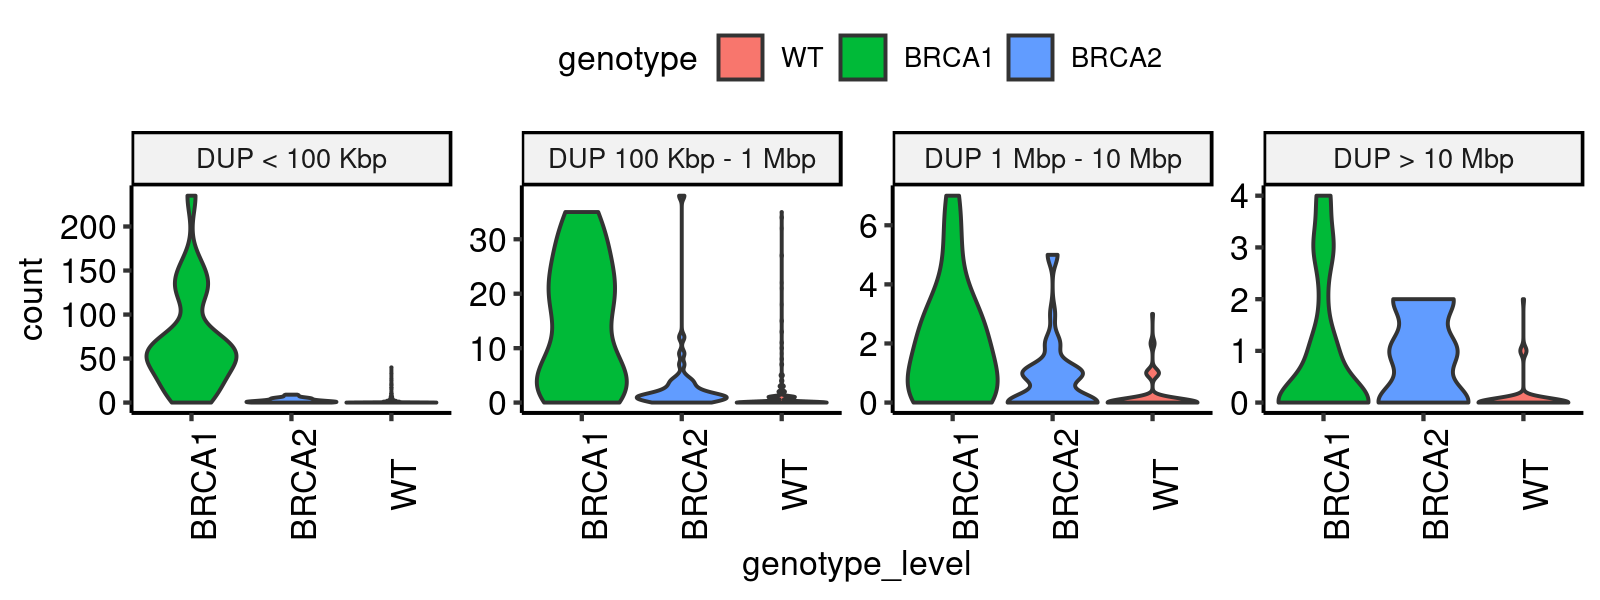

In [55]:
options(repr.plot.height = 3, repr.plot.width = 8)
pt

In [1629]:
## ppdf(print(pt), height = 3, width = 8)

rendering to /gpfs/commons/projects/imielinski_web/zchoo/plot.pdf 


png 
  2

In [60]:
## statistical testing - comparison to WT
combos = expand.grid(genotype = c("BRCA1", "BRCA2"),
                     category = pt.dt[!as.character(category) %like% "NA"][, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "WT" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]

In [61]:
pvals.dt

name                              method                    p       
1  as.character(genotype) == gnTRUE Negative Binomial(0.0853) 2.75e-01
2  as.character(genotype) == gnTRUE Negative Binomial(0.0844) 9.71e-01
3  as.character(genotype) == gnTRUE Negative Binomial(0.1635) 2.99e-04
4  as.character(genotype) == gnTRUE Negative Binomial(0.1643) 3.78e-01
5  as.character(genotype) == gnTRUE Negative Binomial(0.1488) 1.33e-10
6  as.character(genotype) == gnTRUE Negative Binomial(0.1481) 7.51e-01
7  as.character(genotype) == gnTRUE Negative Binomial(0.4823) 1.85e-09
8  as.character(genotype) == gnTRUE Negative Binomial(9.533)  5.21e-21
  estimate   ci.lower   ci.upper  effect             genotype
1  2.2230963  0.5291850  9.339186 2.22 [0.529-9.34]  BRCA1   
2  0.9775317  0.2882450  3.315125 0.978 [0.288-3.32] BRCA2   
3  6.5784893  2.3698678 18.261154 6.58 [2.37-18.3]   BRCA1   
4  1.4704106  0.6240351  3.464721 1.47 [0.624-3.46]  BRCA2   
5 32.8178686 11.3105044 95.222323 32.8 [11.3-95.2]   BRCA1   
6  1.1576656  0.4679520  2.863947 1.16 [0.468-2.86]  BRCA2   
7 10.8536822  4.9874796 23.619629 10.9 [4.99-23.6]   BRCA1   
8  9.7525840  6.0671681 15.676654 9.75 [6.07-15.7]   BRCA2   
  category           
1 DUP 1 Mbp - 10 Mbp 
2 DUP 1 Mbp - 10 Mbp 
3 DUP 100 Kbp - 1 Mbp
4 DUP 100 Kbp - 1 Mbp
5 DUP < 100 Kbp      
6 DUP < 100 Kbp      
7 DUP > 10 Mbp       
8 DUP > 10 Mbp

In [62]:
## statistical testing - comparison between BRCA1 and BRCA2
combos = expand.grid(genotype = c("BRCA1"),
                     category = pt.dt[!as.character(category) %like% "NA"][, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "BRCA2" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]

In [63]:
pvals.dt

name                              method                    p       
1  as.character(genotype) == gnTRUE Negative Binomial(1.4903) 9.42e-03
2  as.character(genotype) == gnTRUE Negative Binomial(0.891)  5.54e-07
3  as.character(genotype) == gnTRUE Negative Binomial(1.1506) 1.43e-35
4  as.character(genotype) == gnTRUE Negative Binomial(2.513)  7.39e-01
  estimate  ci.lower   ci.upper  effect            genotype category           
1  2.274194  1.2231264  4.228472 2.27 [1.22-4.23]  BRCA1    DUP 1 Mbp - 10 Mbp 
2  4.473913  2.4886452  8.042889 4.47 [2.49-8.04]  BRCA1    DUP 100 Kbp - 1 Mbp
3 28.348315 16.7427815 47.998413 28.3 [16.7-48]    BRCA1    DUP < 100 Kbp      
4  1.112903  0.5926264  2.089940 1.11 [0.593-2.09] BRCA1    DUP > 10 Mbp

### Simple inversions

In [65]:
## create a plot for deletions first
pt.dt = bopp.counts.dt[as.character(category) %like% "INV"]

pt = ggplot(pt.dt, 
            aes(x = genotype, y = count, fill = genotype)) +
    geom_violin(scale = "width") +
    ylim(0, 10) +
    labs(title = "inv") +
    ggpubr::theme_pubr()

Warning message:
“Removed 3 rows containing non-finite values (`stat_ydensity()`).”


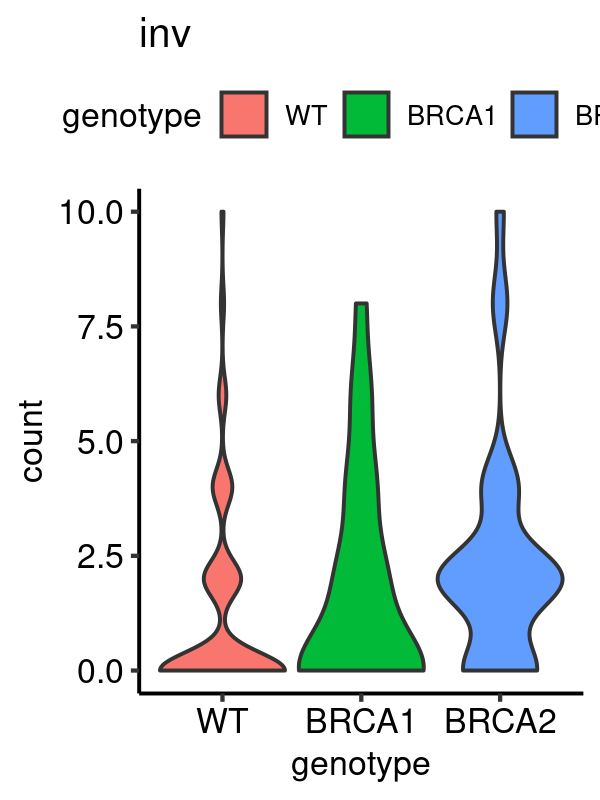

In [66]:
options(repr.plot.height = 4, repr.plot.width = 3)
pt

In [67]:
## statistical testing - comparison to WT
combos = expand.grid(genotype = c("BRCA1", "BRCA2"),
                     category = pt.dt[, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "WT" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt

name                              method                    p     estimate
1  as.character(genotype) == gnTRUE Negative Binomial(0.2861) 0.507 1.323370
2  as.character(genotype) == gnTRUE Negative Binomial(0.3204) 0.036 1.974551
  ci.lower  ci.upper effect            genotype category
1 0.5785849 3.026880 1.32 [0.579-3.03] BRCA1    INV     
2 1.0453063 3.729867 1.97 [1.05-3.73]  BRCA2    INV

In [68]:
## statistical testing - comparison between BRCA1 and BRCA2
combos = expand.grid(genotype = c("BRCA1"),
                     category = pt.dt[, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "BRCA2" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt

name                              method                    p     estimate 
1  as.character(genotype) == gnTRUE Negative Binomial(0.8548) 0.239 0.6702128
  ci.lower  ci.upper effect            genotype category
1 0.3441065 1.305367 0.67 [0.344-1.31] BRCA1    INV

### Simple translocations

In [400]:
## create a plot for deletions first
pt.dt = bopp.counts.dt[as.character(category) %like% "TRA"]

pt = ggplot(pt.dt, 
            aes(x = genotype, y = count, fill = genotype)) +
    geom_violin(scale = "width") +
    labs(title = "tra") +
    ggpubr::theme_pubr()

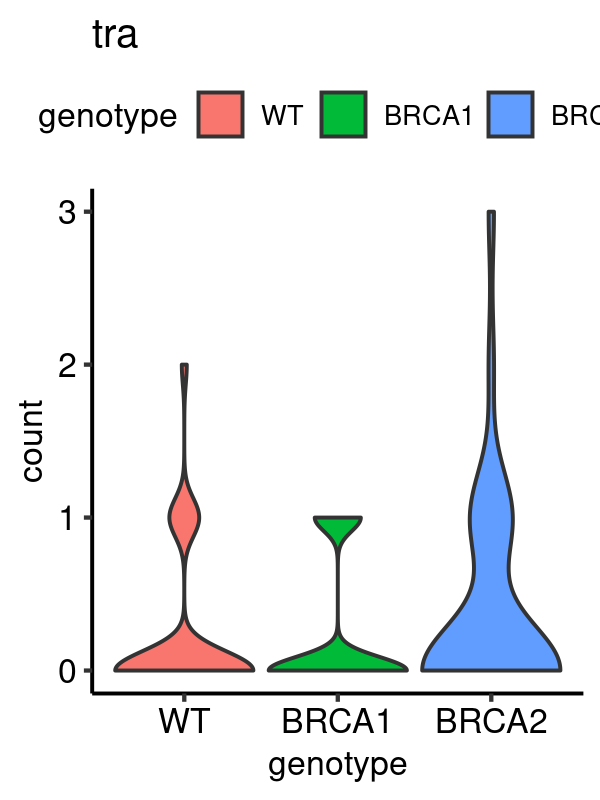

In [401]:
options(repr.plot.height = 4, repr.plot.width = 3)
pt

In [71]:
## statistical testing - comparison to WT
combos = expand.grid(genotype = c("BRCA1", "BRCA2"),
                     category = pt.dt[, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "WT" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt

name                              method                     p     estimate
1  as.character(genotype) == gnTRUE Negative Binomial(30.9132) 0.843 1.087054
2  as.character(genotype) == gnTRUE Negative Binomial(4.943)   0.137 1.570188
  ci.lower  ci.upper effect            genotype category
1 0.4765655 2.479587 1.09 [0.477-2.48] BRCA1    TRA     
2 0.8668100 2.844328 1.57 [0.867-2.84] BRCA2    TRA

In [72]:
## statistical testing - comparison between BRCA1 and BRCA2
combos = expand.grid(genotype = c("BRCA1"),
                     category = pt.dt[, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "BRCA2" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt

name                              method                    p     estimate 
1  as.character(genotype) == gnTRUE Negative Binomial(4.0111) 0.472 0.6923077
  ci.lower  ci.upper effect             genotype category
1 0.2543951 1.884037 0.692 [0.254-1.88] BRCA1    TRA

## ED1b
Distribution of overall junction counts by genotype

In [74]:
## load inputs
## slim.pairs = readRDS("~/projects/Starr/BRCA/db/slim.pairs.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
junctions.dt = readRDS("./data/revision.junctions.dt.rds")
events.dt = readRDS("./data/revision.events.dt.rds")

In [75]:
## check whether each junction belongs to a complex event class
event.class.columns = c("del", "dup", "simple", "bfb", "dm", "cpxdm", "tyfonas", "tic", "chromothripsis", "chromoplexy", "pyrgo", "rigma")

junctions.dt[, unclassified := apply(.SD, 1, function(x) {all(is.na(x))}), .SDcols = event.class.columns]

## additionally, check if they also don't belong to an ecluster
junctions.dt[, unclustered := unclassified & is.na(ecluster)]

In [76]:
## get the counts per sample and unclassified counts per sample
junction.counts.dt = junctions.dt[, .(total.count = .N,
                                      unclassified.count = .SD[(unclassified), .N],
                                      unclustered.count = .SD[(unclustered), .N],
                                      clustered_but_unclassified = .SD[(!unclustered) & (unclassified), .N],
                                      clustered.count = .SD[(!unclustered), .N]),
                  keyby = sample][hrd_tbl[(init_bopp_cohort), pair]]

junction.counts.dt[is.na(junction.counts.dt)] <- 0

## set genotype
junction.counts.dt[, genotype := hrd_tbl[sample, fmut_bi]]

### Total junction count by genotype

In [77]:
## create a plot for deletions first
pt.dt = junction.counts.dt[, .(genotype = ordered(genotype, levels = c("BRCA1", "BRCA2", "WT")),
                              count = total.count)]

pt = ggplot(pt.dt, 
            aes(x = genotype, y = count, fill = genotype)) +
    geom_violin(scale = "width") +
    labs(x = "genotype", y = "count", title = "total junctions") +
    ggpubr::theme_pubr()

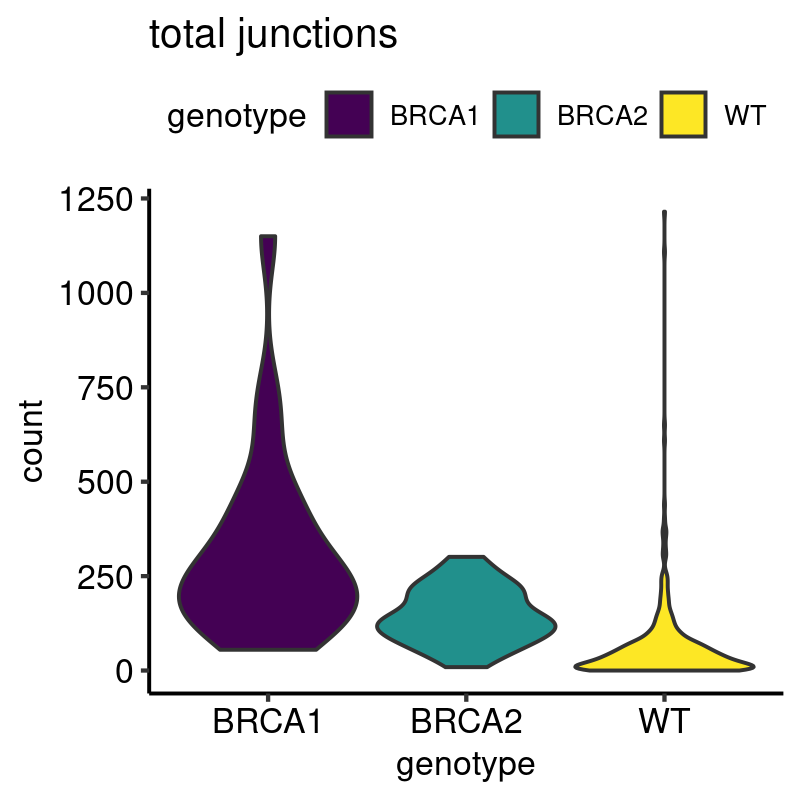

In [78]:
options(repr.plot.height = 4, repr.plot.width = 4)
pt

### Total junction count stats

In [79]:
pvals.dt = lapply(c("BRCA1", "BRCA2"),
       function(gn) {
           dt = pt.dt[genotype == "WT" | genotype == gn]
           res = MASS::glm.nb(data = dt, formula = count ~ (genotype == gn))
           out = dflm(res)
           out[, genotype := gn]
       })

pvals.dt = rbindlist(pvals.dt)
pvals.dt

name                method                    p        estimate  ci.lower 
1  (Intercept)        Negative Binomial(0.577)  0.00e+00 62.944559 55.968785
2  genotype == gnTRUE Negative Binomial(0.577)  5.26e-09  4.997784  2.912114
3  (Intercept)        Negative Binomial(0.5908) 0.00e+00 62.944559 56.045314
4  genotype == gnTRUE Negative Binomial(0.5908) 2.05e-04  2.307586  1.484078
  ci.upper  effect           genotype
1 70.789771 62.9 [56-70.8]   BRCA1   
2  8.577223 5 [2.91-8.58]    BRCA1   
3 70.693108 62.9 [56-70.7]   BRCA2   
4  3.588056 2.31 [1.48-3.59] BRCA2

In [80]:
## comparing BRCA1 and BRCA2
res = MASS::glm.nb(data = pt.dt[genotype != "WT"],
                  formula = count ~ (genotype == "BRCA1"))

skitools::dflm(res)

name                     method                   p        estimate  
1  (Intercept)             Negative Binomial(2.683) 0.00e+00 145.250000
2  genotype == "BRCA1"TRUE Negative Binomial(2.683) 1.81e-06   2.165806
  ci.lower   ci.upper   effect          
1 118.770331 177.633273 145 [119-178]   
2   1.576959   2.974532 2.17 [1.58-2.97]

## ED1c
Distribution of complex events by genotype

In [81]:
## load inputs
## slim.pairs = readRDS("~/projects/Starr/BRCA/db/slim.pairs.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
junctions.dt = readRDS("./data/revision.junctions.dt.rds")
events.dt = readRDS("./data/revision.events.dt.rds")

In [82]:
combos = expand.grid(sample = hrd_tbl[(init_bopp_cohort), pair],
                     type = events.dt[, unique(type)]) %>% as.data.table

combos[, sample := as.character(sample)]
combos[, type := as.character(type)]

event.counts.dt = events.dt[, .N, keyby = .(sample, type)][combos]
event.counts.dt[is.na(event.counts.dt)] <- 0

event.counts.dt[, genotype := hrd_tbl[sample, fmut_bi]]

In [87]:
evs = c("bfb", "chromoplexy", "chromothripsis", "dm", "pyrgo", "rigma", "tic", "tyfonas")

pt = ggplot(event.counts.dt[type %in% evs], 
            aes(x = genotype, y = N, fill = genotype)) +
    geom_violin(scale = "width") +
    facet_wrap(~ type, scales = "free", nrow = 2) +
    ggpubr::theme_pubr()

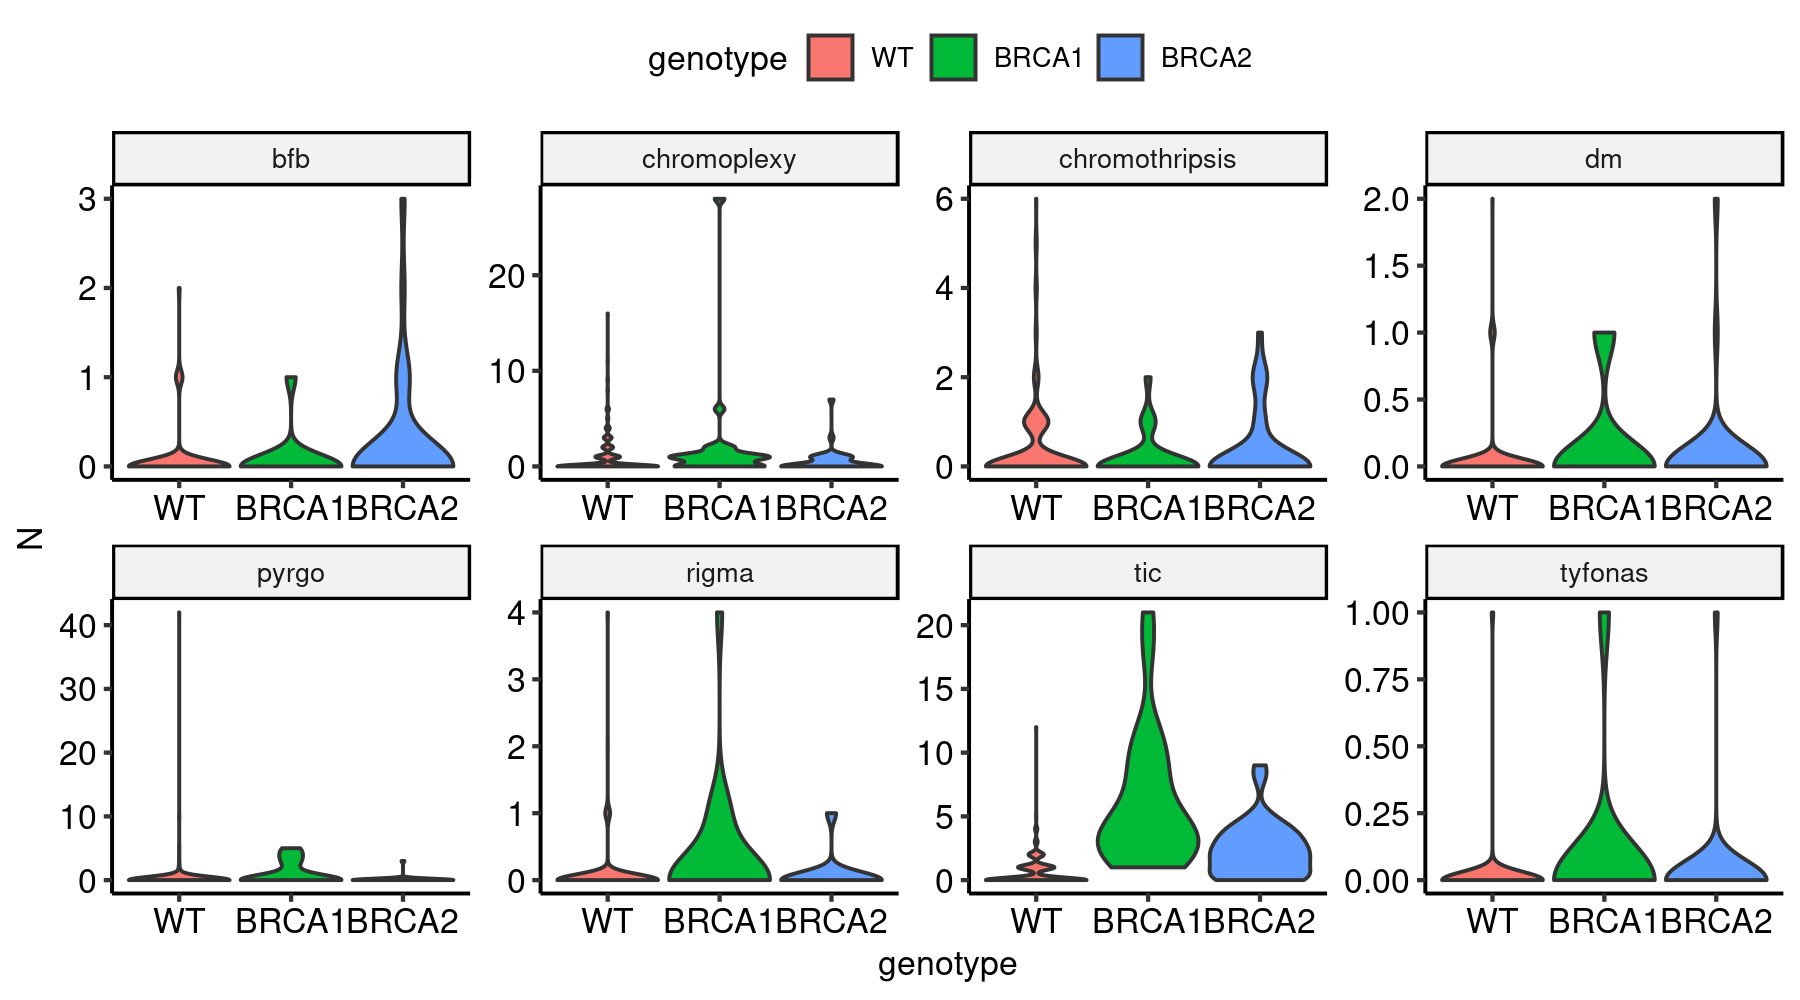

In [90]:
options(repr.plot.height = 5, repr.plot.width = 9)
pt

In [91]:
## statistical testing - comparison to WT
pt.dt = event.counts.dt[type %in% evs][, count := N][, category := type]

combos = expand.grid(genotype = c("BRCA1", "BRCA2"),
                     category = pt.dt[, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "WT" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = dflm(res)
    dt[, genotype := gn]
    dt[, type := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


name                              method                      p       
1   as.character(genotype) == gnTRUE Negative Binomial(0.1536)   1.45e-02
2   as.character(genotype) == gnTRUE Negative Binomial(0.1399)   7.55e-01
3   as.character(genotype) == gnTRUE Negative Binomial(0.5584)   9.33e-01
4   as.character(genotype) == gnTRUE Negative Binomial(0.4249)   1.06e-02
5   as.character(genotype) == gnTRUE Negative Binomial(6.5968)   2.13e-02
6   as.character(genotype) == gnTRUE Negative Binomial(0.4484)   3.94e-01
7   as.character(genotype) == gnTRUE Negative Binomial(0.5006)   2.85e-01
8   as.character(genotype) == gnTRUE Negative Binomial(0.4862)   9.03e-01
9   as.character(genotype) == gnTRUE Negative Binomial(0.3567)   1.51e-02
10  as.character(genotype) == gnTRUE Negative Binomial(0.3558)   2.84e-01
11  as.character(genotype) == gnTRUE Negative Binomial(0.029)    1.31e-01
12  as.character(genotype) == gnTRUE Negative Binomial(0.0188)   6.06e-01
13  as.character(genotype) == gnTRUE Negative Binomial(1.2023)   7.70e-28
14  as.character(genotype) == gnTRUE Negative Binomial(1.15)     2.82e-12
15  as.character(genotype) == gnTRUE Negative Binomial(397.1902) 2.84e-02
16  as.character(genotype) == gnTRUE Negative Binomial(327.2365) 5.38e-01
   estimate   ci.lower   ci.upper  effect              genotype type          
1   5.0729167 1.38055635 18.640661 5.07 [1.38-18.6]    BRCA1    rigma         
2   1.2682292 0.28587590  5.626236 1.27 [0.286-5.63]   BRCA2    rigma         
3   1.0679825 0.23264248  4.902744 1.07 [0.233-4.9]    BRCA1    bfb           
4   3.2039474 1.31162652  7.826373 3.2 [1.31-7.83]     BRCA2    bfb           
5   3.5289855 1.20597108 10.326731 3.53 [1.21-10.3]    BRCA1    dm            
6   1.7644928 0.47846104  6.507185 1.76 [0.478-6.51]   BRCA2    dm            
7   0.5605433 0.19407167  1.619035 0.561 [0.194-1.62]  BRCA1    chromothripsis
8   1.0463475 0.50478689  2.168921 1.05 [0.505-2.17]   BRCA2    chromothripsis
9   2.5238391 1.19633901  5.324380 2.52 [1.2-5.32]     BRCA1    chromoplexy   
10  0.6730238 0.32639525  1.387768 0.673 [0.326-1.39]  BRCA2    chromoplexy   
11  6.6009036 0.57151120 76.239850 6.6 [0.572-76.2]    BRCA1    pyrgo         
12  0.4889558 0.03214846  7.436680 0.489 [0.0321-7.44] BRCA2    pyrgo         
13 10.6567746 6.97365635 16.285122 10.7 [6.97-16.3]    BRCA1    tic           
14  4.1361910 2.77722443  6.160135 4.14 [2.78-6.16]    BRCA2    tic           
15  5.7976190 1.20420150 27.912593 5.8 [1.2-27.9]      BRCA1    tyfonas       
16  1.9325397 0.23774023 15.709203 1.93 [0.238-15.7]   BRCA2    tyfonas

In [92]:
## statistical testing - comparison between BRCA1 and BRCA2
combos = expand.grid(genotype = c("BRCA1"),
                     category = pt.dt[, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "BRCA2" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


name                              method                      p       
1  as.character(genotype) == gnTRUE Negative Binomial(0.4085)   8.03e-02
2  as.character(genotype) == gnTRUE Negative Binomial(0.3754)   2.18e-01
3  as.character(genotype) == gnTRUE Negative Binomial(0.6734)   4.03e-01
4  as.character(genotype) == gnTRUE Negative Binomial(0.4154)   3.46e-01
5  as.character(genotype) == gnTRUE Negative Binomial(0.4468)   5.37e-03
6  as.character(genotype) == gnTRUE Negative Binomial(0.1847)   2.59e-03
7  as.character(genotype) == gnTRUE Negative Binomial(2.2444)   2.12e-05
8  as.character(genotype) == gnTRUE Negative Binomial(945.3515) 3.70e-01
  estimate   ci.lower   ci.upper  effect             genotype category      
1  4.0000000 0.84589969 18.914772 4 [0.846-18.9]     BRCA1    rigma         
2  0.3333333 0.05799387  1.915911 0.333 [0.058-1.92] BRCA1    bfb           
3  2.0000000 0.39425349 10.145757 2 [0.394-10.1]     BRCA1    dm            
4  0.5357143 0.14628061  1.961913 0.536 [0.146-1.96] BRCA1    chromothripsis
5  3.7500000 1.47866520  9.510266 3.75 [1.48-9.51]   BRCA1    chromoplexy   
6 13.5000000 2.48292156 73.401433 13.5 [2.48-73.4]   BRCA1    pyrgo         
7  2.5764706 1.66546620  3.985791 2.58 [1.67-3.99]   BRCA1    tic           
8  3.0000000 0.27200184 33.088011 3 [0.272-33.1]     BRCA1    tyfonas

## ED1d

 Fraction of cases with at least one TIC event across BRCA1-deficient, BRCA2-deficient, and HR-proficient cases.

In [93]:
## load inputs
## slim.pairs = readRDS("~/projects/Starr/BRCA/db/slim.pairs.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
## junctions.dt = readRDS("~/projects/Starr/BRCA/db/revision.junctions.dt.rds")
events.dt = readRDS("./data/revision.events.dt.rds")

In [94]:
## get event counts per sample
combos = expand.grid(sample = hrd_tbl[(init_bopp_cohort), pair],
                     type = events.dt[, unique(type)]) %>% as.data.table

combos[, sample := as.character(sample)]
combos[, type := as.character(type)]

event.counts.dt = events.dt[, .N, keyby = .(sample, type)][combos]
event.counts.dt[is.na(event.counts.dt)] <- 0

## annotate with genotype
event.counts.dt[, genotype := hrd_tbl[sample, fmut_bi]]

In [95]:
## get the fraction of samples with TICs by genotype
pt.dt = event.counts.dt[(type == "tic"), .(nsamples = .N, ntic = .SD[N > 0, .N]), by = genotype]
pt.dt = cbind(pt.dt, {mapply(function(x, y) {dflm(prop.test(x, y))}, pt.dt$ntic, pt.dt$nsamples, SIMPLIFY = FALSE) %>% rbindlist})
pt.dt

genotype nsamples ntic name
1 BRCA2     36       28      
2 WT       487      177      
3 BRCA1     24       24      
  method                                               estimate  ci.lower 
1 1-sample proportions test with continuity correction 0.7777778 0.6041406
2 1-sample proportions test with continuity correction 0.3634497 0.3209604
3 1-sample proportions test with continuity correction 1.0000000 0.8282850
  ci.upper  effect              p           
1 0.8927469 0.778 [0.604-0.893] 1.541970e-03
2 0.4081275 0.363 [0.321-0.408] 2.211043e-09
3 1.0000000 1 [0.828-1]         2.667955e-06

In [96]:
pt.dt[, genotype_factor := ordered(as.character(genotype), levels = c("BRCA1", "BRCA2", "WT"))]

pt = ggplot(pt.dt, aes(x = genotype_factor, y = estimate, fill = genotype)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = ci.lower, ymax = ci.upper), width = 0.2, position = "dodge") +
    labs(x = "genotype", y = "fraction", title = "samples with TIC") +
    ggpubr::theme_pubr() +
    theme(legend.position = "none")

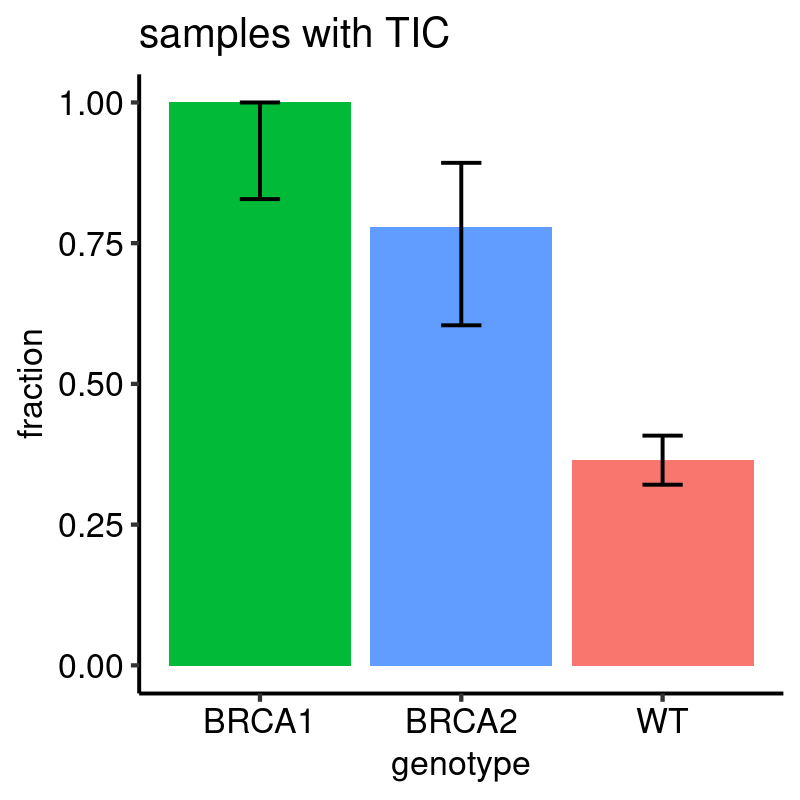

In [97]:
options(repr.plot.height = 4, repr.plot.width = 4)
pt

# Figure 2

In [187]:
events.dt = readRDS("./data/revision.events.dt.rds") 
phasing.barcode.counts.dt = readRDS("./data/phasing/phasing.barcode.counts.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

## the job generating these barcode counts is here: 
## basically the phasing.barcode.counts.dt just stacks the outputs of phase_dt
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221102_re/qrp_phasing.rds")
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221107_re_re/qrp_phasing.rds")

## Fig. 2d
Counts of 10X-phased reciprocal duplications (rDups), deletions (rDels) and deletion-duplications (rDelDup) from either BRCA1-deficient (BRCA1d, n = 22) or BRCA2-deficient (BRCA2d, n = 14) tumors. Reciprocal pairs are colored by their junction span (either 1-10 Mbp, >10 Mbp, or interchromosomal)

In [101]:
## counts of each event (rDup, rDel, rDelDup) and whether it is cis, trans, or, unphased
all.qrp.dt = events.dt[type %like% "qrp" & 
                       sample %in% phasing.barcode.counts.dt$sample & 
                       hrd_tbl[sample, fmut_bi %in% c("BRCA1", "BRCA2")]]
setkeyv(all.qrp.dt, c("sample", "ecluster"))
##key(all.qrp.dt)

In [102]:
setkeyv(phasing.barcode.counts.dt, c("sample", "ecluster"))

## assign the phase
phasing.barcode.counts.dt[(cis >= 3 | trans >= 3), 
                          phase := ifelse(cis > trans * 3,
                                          "cis",
                                          ifelse(trans > cis * 3, "trans", "unphased"))]
phasing.barcode.counts.dt[is.na(phase), phase := "unphased"]

## get widths
phasing.barcode.counts.dt[, width.l1 := all.qrp.dt[phasing.barcode.counts.dt, width.l1]]
phasing.barcode.counts.dt[, width.l2 := all.qrp.dt[phasing.barcode.counts.dt, width.l2]]

## setkeyv(phasing.barcode.counts.dt, c("sample", "ecluster"))
all.qrp.dt[, phase := phasing.barcode.counts.dt[all.qrp.dt[, .(sample, ecluster)], phase]]
all.qrp.dt[, cis := phasing.barcode.counts.dt[all.qrp.dt[, .(sample, ecluster)], cis]]
all.qrp.dt[, trans := phasing.barcode.counts.dt[all.qrp.dt[, .(sample, ecluster)], trans]]

## unset phase if over threshold for positive gap
all.qrp.dt[(type == "qrppos") & pmax(width.l1, width.l2) > 5e4, phase := "unphased"]
all.qrp.dt[(type == "qrpmix") & ifelse(as.character(strand.l1) == "+", width.l1, width.l2) > 5e4, phase := "unphased"]

In [104]:
qrp.events.dt = events.dt[!is.na(ecluster)]
setkeyv(qrp.events.dt, c("sample", "ecluster"))

qrp.events.dt[, phase := phasing.barcode.counts.dt[qrp.events.dt[, .(sample, ecluster)], phase]]
qrp.events.dt[, cis := phasing.barcode.counts.dt[qrp.events.dt[, .(sample, ecluster)], cis]]
qrp.events.dt[, trans := phasing.barcode.counts.dt[qrp.events.dt[, .(sample, ecluster)], trans]]
##qrp.events.dt = merge.data.table(qrp.events.dt, phasing.barcode.counts.dt, by = c("sample", "ecluster"), all.x = TRUE)

## add qrp annotations
qrp.events.dt[(type == "qrppos"), big.gap := pmax(width.l1, width.l2)]
qrp.events.dt[(type == "qrppos"), small.gap := pmin(width.l1, width.l2)]                      
qrp.events.dt[(type == "qrpmix") & (strand.l1 == "+"), ":="(pos.gap = width.l1, neg.gap = width.l2)]
qrp.events.dt[(type == "qrpmix") & (strand.l2 == "+"), ":="(pos.gap = width.l2, neg.gap = width.l1)]

## add inter/intrachromosomal annotation
qrp.events.dt[, intergap := ifelse(seqnames.l1 != seqnames.l2, "interchromosomal",
                                   ifelse(abs(start.l1 - start.l2) > 1e7, "intrachromosomal > 10 Mbp", "intrachromosomal < 10 Mbp"))]

qrp.events.dt[, intergap_levels := ordered(intergap, levels = c("intrachromosomal < 10 Mbp", "intrachromosomal > 10 Mbp", "interchromosomal"))]

## add genotype information
qrp.events.dt[, genotype := hrd_tbl[sample, fmut_bi]]

## add phase information
qrp.events.dt[(cis >= 3 | trans >= 3), phase := ifelse(cis > 3 * trans, "cis", ifelse(trans > 3 * cis, "trans", "unphased"))]
qrp.events.dt[pmax(big.gap, small.gap) > 5e4, phase := "unphased"]
qrp.events.dt[pos.gap > 5e4, phase := "unphased"]

In [105]:
pt.dt = qrp.events.dt[(phase == "cis") | (phase == "trans")][, .(phase, genotype, type, intergap, intergap_levels)]

type.map = c("qrppos" = "rDup", "qrpmin" = "rDel", "qrpmix" = "rDelDup")
pt.dt[, type_level := ordered(type.map[type], levels = type.map)]

In [106]:
pt = ggplot(pt.dt[genotype == "BRCA1"][type_level %in% c("rDup", "rDelDup")], 
            aes(x = phase, fill = intergap_levels)) +
geom_bar(position = "stack") +
facet_wrap(~ type_level, scales = "free_y") +
ggpubr::theme_pubr() +
labs(x = "phase", y = "count", title = "BRCA1") +
theme(legend.position = "right")

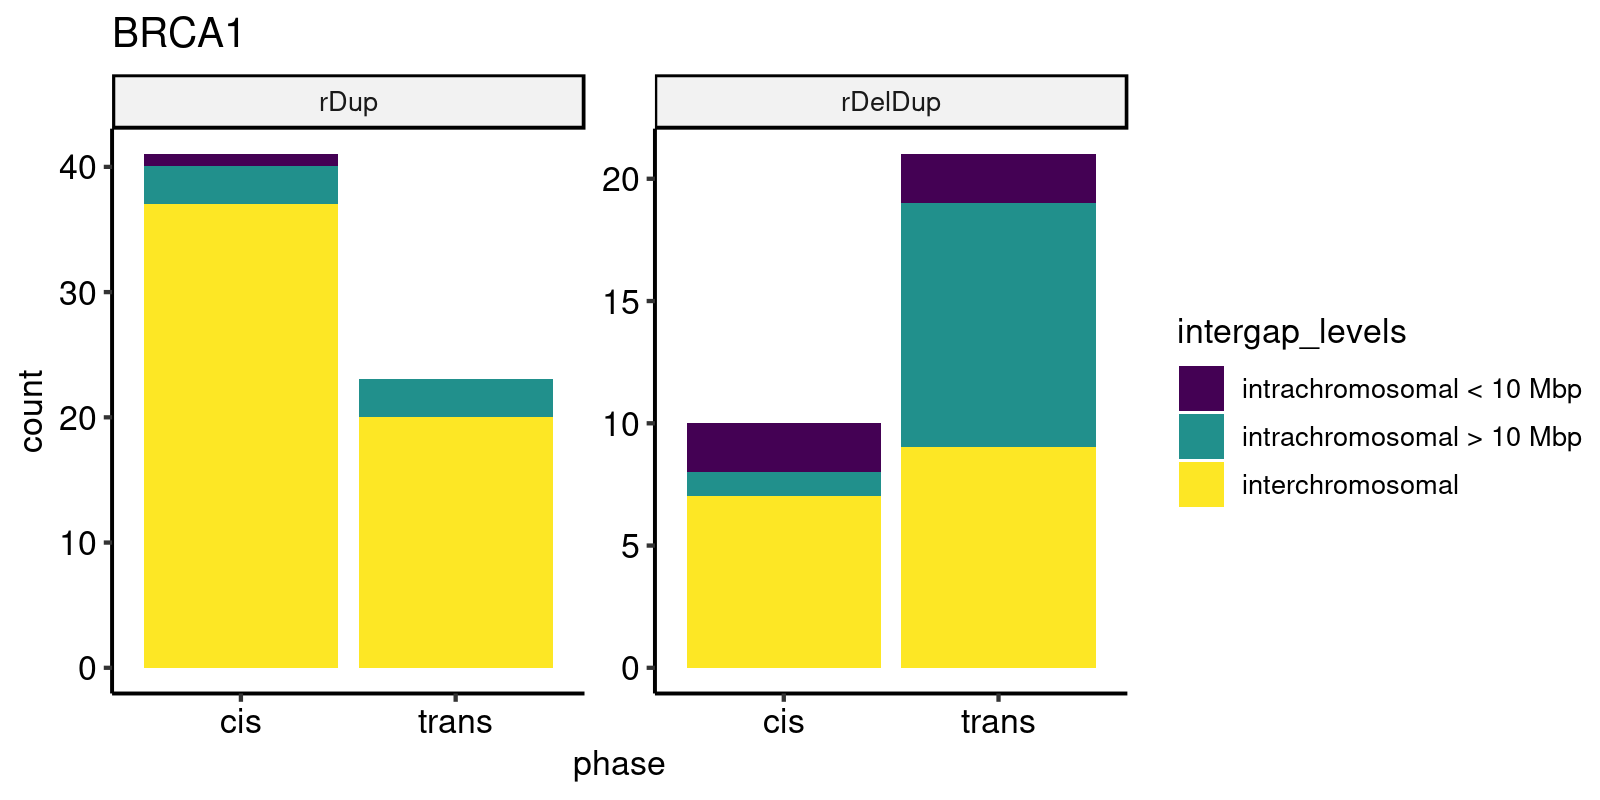

In [107]:
options(repr.plot.height = 4, repr.plot.width = 8)
pt

In [3102]:
pt = ggplot(pt.dt[genotype == "BRCA2"][type_level %in% c("rDel", "rDelDup")], 
            aes(x = phase, fill = intergap_levels)) +
geom_bar(position = "stack") +
facet_wrap(~ type_level, scales = "free_y") +
ggpubr::theme_pubr() +
labs(x = "phase", y = "count", title = "BRCA2") +
theme(legend.position = "right")

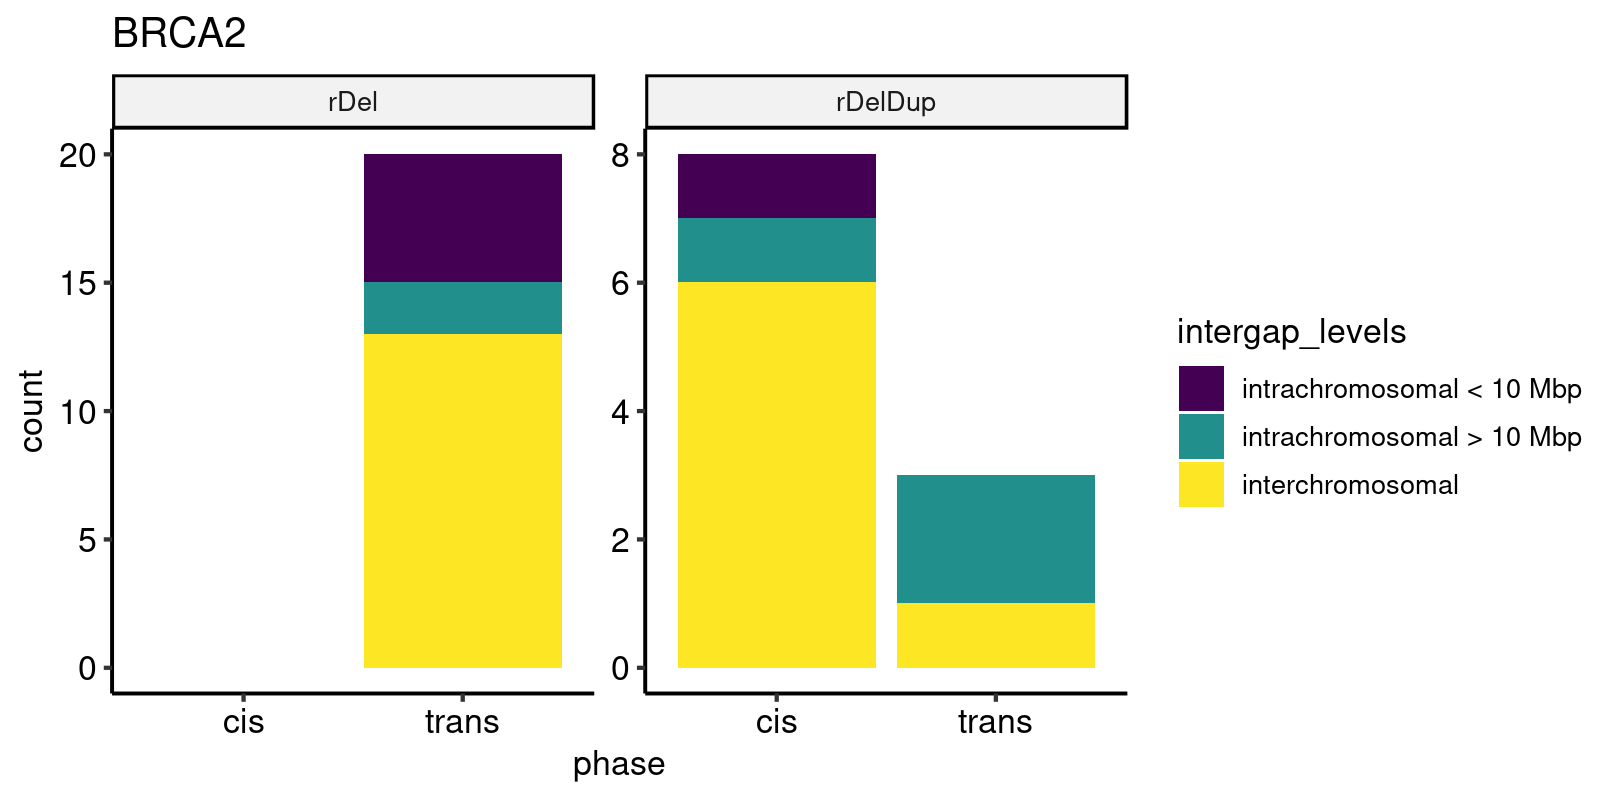

In [3103]:
options(repr.plot.height = 4, repr.plot.width = 8)
pt

# Extended data figure 2

## ED2a
Quantile-quantile plot of observed -log10P values obtained by evaluating 473,382 observed gap segment lengths from 283 tumor samples  against an exponential null model. X axis represents -log10 transformed quantiles from the uniform distribution. Gap segment lengths with width less than 1 Mbp are shown in red. 

In [402]:
cdists = readRDS('./data/gap_distances.rds')
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
cdists[, distp1 := distance + 1]

allbpe = readRDS("./data/revision.junctions.dt.rds")

## remove allbpe dependency.. this file is huge!
## attaching total junction burden
## allbpe = readRDS("./data/all.bedpe.rds")

In [404]:
totjun.dt = allbpe[, .(njun = .N), keyby = sample][hrd_tbl[(aug_bopp_cohort), pair]][is.na(njun), njun := 0]
totjun.dt[, pair := sample]
setkey(totjun.dt, "pair")
cdists[, totjun := totjun.dt[pair, njun]]
cdists = cdists[!is.na(totjun)]

In [405]:
## WARNING this cell takes a hot sec to run!
cdists.res = lapply(unique(cdists$pair),
                    function(pr, tbl) {
                        dt = cdists[pair == pr, .SD]
                        if (dt[, .N] < 10) {
                            return(data.table())
                        }
                        mod = stats::glm(distp1 ~ 1,
                                         data = dt,
                                         family = Gamma,
                                         maxit = 1e4)
                        shp = MASS::gamma.shape(mod)$alpha
                        pred = predict(mod, newdata = dt, type = "response")
                        dt[, p := pgamma(distp1, shape = shp, scale = pred, lower.tail = TRUE)]
                        dt[, adj.p := p.adjust(p, method = "BH")]
                        return(dt)
                    })

In [406]:
cdists.res = rbindlist(cdists.res)

In [407]:
## load("~/gap_analyses.rdata")
qq_pval <- function (obs, highlight = c(), exp = NULL, lwd = 1, bestfit = T,
    col = NULL, col.bg = "black", pch = 18, cex = 1, conf.lines = FALSE,
    max = NULL, max.x = NULL, max.y = NULL, qvalues = NULL, label = NULL,
    repel = FALSE, plotly = FALSE, annotations = list(), gradient = list(),
    titleText = "", subsample = NA, do.log = TRUE, logbase = 10, explogbase = 10, ...)
{
    if (do.log) {
        nlogfun = function(x, lbase = logbase) -log(x, lbase)
    } else {
        nlogfun = function(x) -x
    }
    explogfun = function(y, lbase = explogbase) -log(y, lbase)
    if (!(plotly)) {
        is.exp.null = is.null(exp)
        if (is.null(col))
            col = rep("black", length(obs))
        ix1 = !is.na(obs)
        if (!is.null(exp))
            if (length(exp) != length(obs))
                stop("length of exp must be = length(obs)")
            else ix1 = ix1 & !is.na(exp)
        if (is.null(highlight))
            highlight = rep(FALSE, length(obs))
        if (is.null(label))
            label = rep("", length(label))
        else if (is.logical(highlight)) {
            if (length(highlight) != length(obs))
                stop("highlight must be either logical vector of same length as obs or a vector of indices")
        }
        else highlight = 1:length(obs) %in% highlight
        obs = nlogfun(obs[ix1])
        col = col[ix1]
        highlight = highlight[ix1]
        label = label[ix1]
        if (!is.null(exp))
            exp = nlogfun(exp[ix1])
        ix2 = !is.infinite(obs)
        if (!is.null(exp))
            ix2 = ix2 & !is.infinite(exp)
        obs = obs[ix2]
        col = col[ix2]
        highlight = highlight[ix2]
        label = label[ix2]
        if (!is.null(exp))
            exp = nlogfun(exp[ix2])
        N <- length(obs)
        if (is.null(exp))
            exp <- explogfun(1:N/N)
        else exp = sort(exp)
        if (is.null(max))
            max = max(obs, exp) + 0.5
        if (!is.null(max) & is.null(max.x))
            max.x = max
        if (!is.null(max) & is.null(max.y))
            max.y = max
        if (is.null(max.x))
            max.x <- max(obs, exp) + 0.5
        if (is.null(max.y))
            max.y <- max(obs, exp) + 0.5
        if (is.exp.null) {
            tmp.exp = rev(seq(0, 7, 0.01))
            ix = 10^(-tmp.exp) * N
            c95 <- qbeta(0.975, ix, N - ix + 1)
            c05 <- qbeta(0.025, ix, N - ix + 1)
            if (conf.lines) {
                plot(tmp.exp, nlogfun(c95), ylim = c(0, max.y),
                  xlim = c(0, max.x), type = "l", axes = FALSE,
                  xlab = "", ylab = "")
                par(new = T)
                plot(tmp.exp, nlogfun(c05), ylim = c(0, max.y),
                  xlim = c(0, max.x), type = "l", axes = FALSE,
                  xlab = "", ylab = "")
                par(new = T)
                p1 <- rep(tmp.exp[1], 2)
                p2 <- c(nlogfun(c95)[1], nlogfun(c05)[1])
                lines(x = p1, y = p2)
                x.coords <- c(tmp.exp, rev(tmp.exp))
                y.coords <- c(nlogfun(c95), rev(nlogfun(c05)))
                polygon(x.coords, y.coords, col = "light gray",
                  border = NA)
                par(new = T)
            }
        }
        ord = order(obs)
        colors = col
        colors[highlight] = "red"
        dat = data.table(x = sort(exp), y = obs[ord], colors = colors[ord],
            label = label[ord], pch = pch, cex = cex)
        if (!is.null(names(obs))) {
            dat$names = names(obs[ord])
            setkey(dat, names)
        }
        if (nrow(dat) > 1e+05)
            subsample = 50000/nrow(dat)
        ## browser()
        lambda = lm(y ~ x - 1, dat)$coefficients
        if (is.na(subsample[1]))
            dat[, plot(x, y, xlab = expression(Expected - log[10](italic(P))),
                ylab = expression(Observed - log[10](italic(P))),
                xlim = c(0, max.x), col = colors, ylim = c(0,
                  max.y), pch = pch, cex = cex, bg = col.bg,
                ...)]
        else {
            subsample = pmin(pmax(0, subsample[1]), 1)
            dat[ifelse(x <= 2, ifelse(runif(length(x)) < subsample,
                TRUE, FALSE), TRUE), plot(x, y, xlab = expression(Expected -
                log[10](italic(P))), ylab = expression(Observed -
                log[10](italic(P))), xlim = c(0, max.x), col = colors,
                ylim = c(0, max.y), pch = pch, cex = cex, bg = col.bg,
                ...)]
        }
        if (!is.null(dat$label) && any(nchar(dat$label) > 0,
            na.rm = TRUE)) {
            dat[nchar(label) > 0, text(x, y, labels = label,
                pos = 3)]
        }
        lines(x = c(0, max(max.y, max.x)), y = c(0, max(max.x,
            max.y)), col = "black", lwd = lwd)
        if (!is.na(subsample))
            dat = dat[sample(nrow(dat), subsample * nrow(dat)),
                ]
        lines(x = c(0, max.x), y = c(0, lambda * max.x), col = "red",
            lty = 2, lwd = lwd)
        legend("bottomright", sprintf("lambda=\n %.2f", lambda),
            text.col = "red", bty = "n")
    }
    else {
        if (length(annotations) < 1) {
            hover <- do.call(cbind.data.frame, list(p = obs))
        }
        else {
            hover <- do.call(cbind.data.frame, list(annotations,
                p = obs))
        }
        hover <- as.data.table(hover)
        is.exp.null = is.null(exp)
        if (is.null(col))
            col = "black"
        ix1 = !is.na(hover$p)
        if (!is.null(exp))
            if (length(exp) != length(hover$p))
                stop("length of exp must be = length(hover$obs)")
            else ix1 = ix1 & !is.na(exp)
        if (is.null(highlight))
            highlight = rep(FALSE, length(hover$p))
        else if (is.logical(highlight)) {
            if (length(highlight) != length(hover$p))
                stop("highlight must be either logical vector of same length as obs or a vector of indices")
        }
        else highlight = 1:length(hover$p) %in% highlight
        hover$obs = nlogfun(hover$p[ix1])
        hover = hover[ix1]
        highlight = highlight[ix1]
        if (!is.null(exp))
            exp = nlogfun(exp[ix1])
        ix2 = !is.infinite(hover$obs)
        if (!is.null(exp))
            ix2 = ix2 & !is.infinite(exp)
        hover = hover[ix2]
        highlight = highlight[ix2]
        if (!is.null(exp))
            exp = exp[ix2]
        N <- length(hover$obs)
        if (is.null(exp))
            exp <- nlogfun(1:N/N)
        else exp = sort(exp)
        if (is.null(max))
            max <- max(hover$obs, exp) + 0.5
        else max <- max
        if (is.exp.null) {
            tmp.exp = rev(seq(0, 7, 0.01))
            ix = 10^(-tmp.exp) * N
            c95 <- qbeta(0.975, ix, N - ix + 1)
            c05 <- qbeta(0.025, ix, N - ix + 1)
            if (FALSE) {
                plot(tmp.exp, nlogfun(c95), ylim = c(0, max),
                  xlim = c(0, max), type = "l", axes = FALSE,
                  xlab = "", ylab = "")
                par(new = T)
                plot(tmp.exp, nlogfun(c05), ylim = c(0, max),
                  xlim = c(0, max), type = "l", axes = FALSE,
                  xlab = "", ylab = "")
                par(new = T)
                p1 <- rep(tmp.exp[1], 2)
                p2 <- c(nlogfun(c95)[1], nlogfun(c05)[1])
                lines(x = p1, y = p2)
                x.coords <- c(tmp.exp, rev(tmp.exp))
                y.coords <- c(nlogfun(c95), rev(nlogfun(c05)))
                polygon(x.coords, y.coords, col = "light gray",
                  border = NA)
                par(new = T)
            }
        }
        ord = order(hover$obs)
        hover = hover[ord]
        dat = hover
        hover$obs = NULL
        if (length(colnames(hover)) > 1) {
            annotation_names = sapply(colnames(hover), paste0,
                " : ")
            annotation_names_wLineBreak = paste("<br>", annotation_names[2:length(annotation_names)],
                sep = "")
            annotation_names = c(annotation_names[1], annotation_names_wLineBreak)
        }
        else {
            annotation_names = sapply(colnames(hover), paste0,
                " : ")
        }
        gradient_control = FALSE
        if (length(gradient) != 0) {
            dat$grad = gradient[[1]][ord]
            gradient_control = TRUE
        }
        else {
            dat$grad = c()
        }
        dat$x = sort(exp)
        dat$y = dat$obs
        p <- NULL
        if (nrow(dat) <= 8000) {
            dat4 = dat
            dat4$obs = NULL
            dat4$x = NULL
            dat4$y = NULL
            dat4$grad = NULL
            trans = t(dat4)
            hover_text = c()
            for (i in 1:dim(trans)[2]) {
                outstr = paste(c(rbind(annotation_names, trans[,
                  i])), sep = "", collapse = "")
                hover_text = c(hover_text, outstr)
            }
            if (gradient_control) {
                p <- dat[, plot_ly(data = dat, x = x, y = y,
                  hoverinfo = "text", text = hover_text, color = grad,
                  colors = c("blue2", "gold"), marker = list(colorbar = list(title = names(gradient[1]))),
                  mode = "markers", type = "scatter") %>% layout(xaxis = list(title = "<i>Expected -log<sub>10</sub>(P)</i>"),
                  yaxis = list(title = "<i>Observed -log<sub>10</sub>(P)</i>"))]
            }
            else {
                p <- dat[, plot_ly(data = dat, x = x, y = y,
                  hoverinfo = "text", text = hover_text, mode = "markers",
                  type = "scatter") %>% layout(xaxis = list(title = "<i>Expected -log<sub>10</sub>(P)</i>"),
                  yaxis = list(title = "<i>Observed -log<sub>10</sub>(P)</i>"))]
            }
        }
        else {
            dat$ID = c(1:nrow(dat))
            dat2 = dat[y < 2.6, ]
            dat3 = as.data.frame(dat2)
            dat3 = as.data.table(dat3[sample(nrow(dat3), min(4000,
                nrow(dat3))), ])
            dat2 = rbind(dat3, dat[!(ID %in% dat2$ID), ])
            dat2$ID = NULL
            dat4 = dat2
            dat4$obs = NULL
            dat4$x = NULL
            dat4$y = NULL
            dat4$grad = NULL
            trans = t(dat4)
            hover_text = c()
            for (i in 1:dim(trans)[2]) {
                outstr = paste(c(rbind(annotation_names, trans[,
                  i])), sep = "", collapse = "")
                hover_text = c(hover_text, outstr)
            }
            if (gradient_control) {
                p <- dat2[, plot_ly(data = dat2, x = x, y = y,
                  hoverinfo = "text", text = hover_text, color = grad,
                  colors = c("blue2", "gold"), marker = list(colorbar = list(title = names(gradient[1]))),
                  mode = "markers", type = "scatter") %>% layout(xaxis = list(title = "<i>Expected -log<sub>10</sub>(P)</i>"),
                  yaxis = list(title = "<i>Observed -log<sub>10</sub>(P)</i>"))]
            }
            else {
                p <- dat2[, plot_ly(data = dat2, x = x, y = y,
                  hoverinfo = "text", text = hover_text, mode = "markers",
                  type = "scatter") %>% layout(xaxis = list(title = "<i>Expected -log<sub>10</sub>(P)</i>"),
                  yaxis = list(title = "<i>Observed -log<sub>10</sub>(P)</i>"))]
            }
        }
        lambda = lm(y ~ x - 1, dat)$coefficients
        lambda_max = max * as.numeric(lambda)
        p <- layout(p, title = sprintf("<b>%s</b>", titleText),
            titlefont = list(size = 24), shapes = list(list(type = "line",
                line = list(color = "black"), x0 = 0, x1 = max,
                xref = "x", y0 = 0, y1 = max, yref = "y"), list(type = "line",
                line = list(color = "red"), x0 = 0, x1 = max,
                xref = "x", y0 = 0, y1 = lambda_max, yref = "y")),
            annotations = list(x = (0.9 * max), y = (0.03 * max),
                text = paste("lambda =", sprintf("%.2f", signif(lambda,
                  3)), collapse = " "), font = list(color = "red",
                  size = 20), showarrow = FALSE, xref = "x",
                yref = "y"), margin = list(t = 100), hovermode = "compare")
    }
}

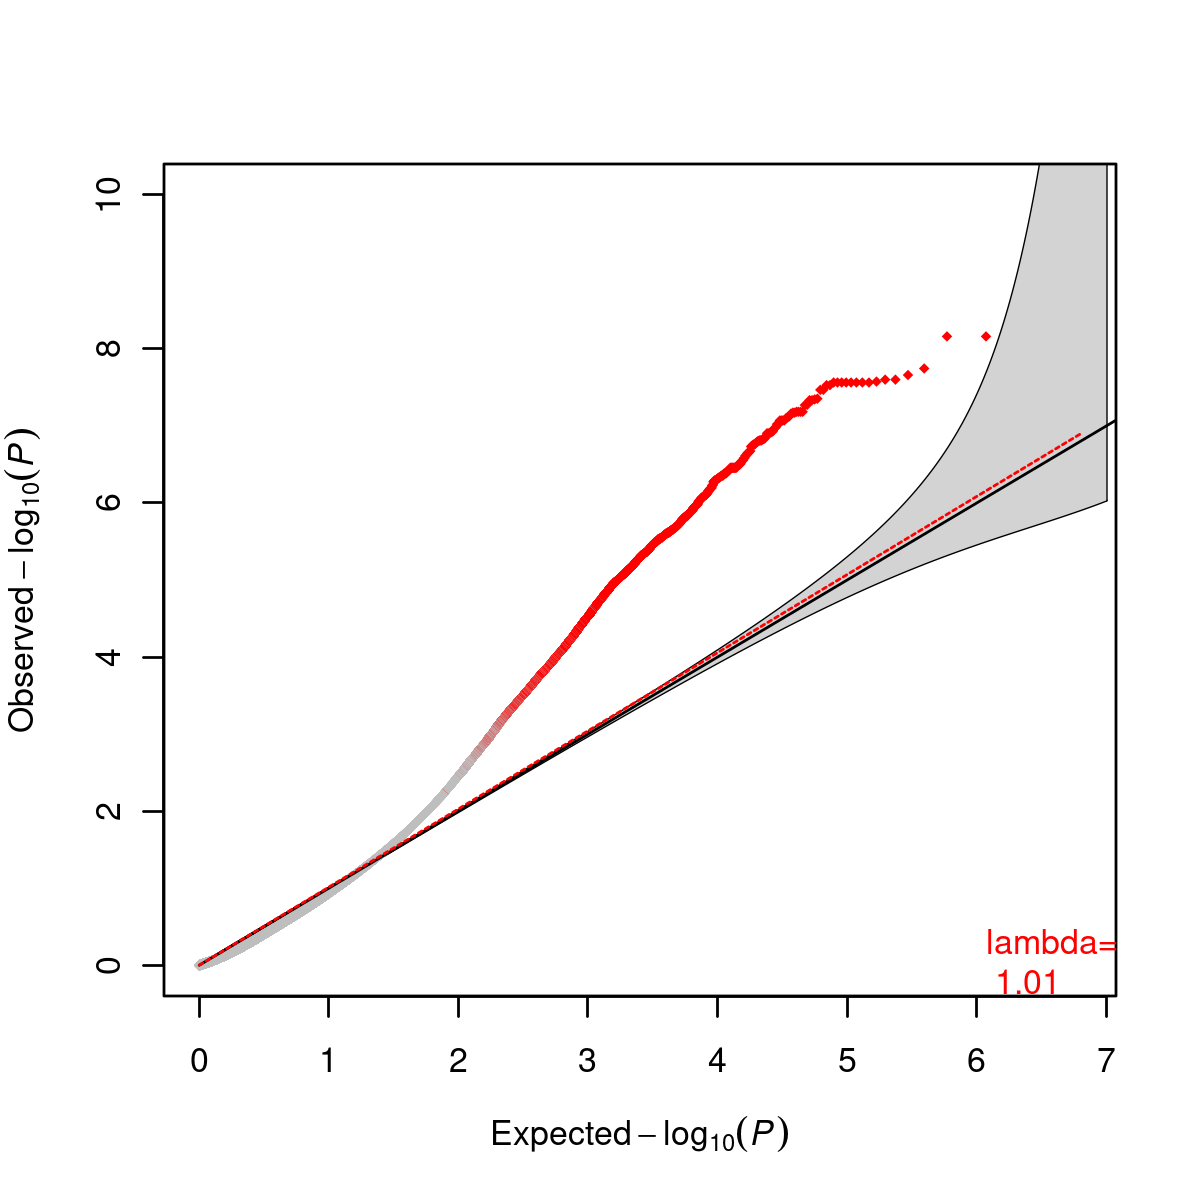

In [408]:
options(repr.plot.height = 6, repr.plot.width = 6)
pt = qq_pval(cdists.res[, p],
             conf.lines = TRUE,
             bestfit = TRUE,
             col = ifelse(cdists.res[, adj.p < 0.1], "red", "grey"),
             max.x = 10/1.47,
             max.y = 10,
             cex = 0.7)

## ED2b

Density plot showing distribution of gap segment lengths with FDR<0.1 across the sample set, the vast majority of which are less than 1 Mbp.  You will have to run ED2a first to run the following cells.

In [115]:
pt = ggplot(cdists.res[(adj.p < 0.1)], aes(x = log10(distp1))) +
geom_density(aes(y = ..density..), alpha = 0.6, bw = 0.4, color = NA, fill = 'grey') +
geom_vline(xintercept = 6) +
labs(x = "log10 gap width (bp)", y = "density", title = "gaps with FDR < 0.1") +
xlim(0, 8) +
ggpubr::theme_pubr()

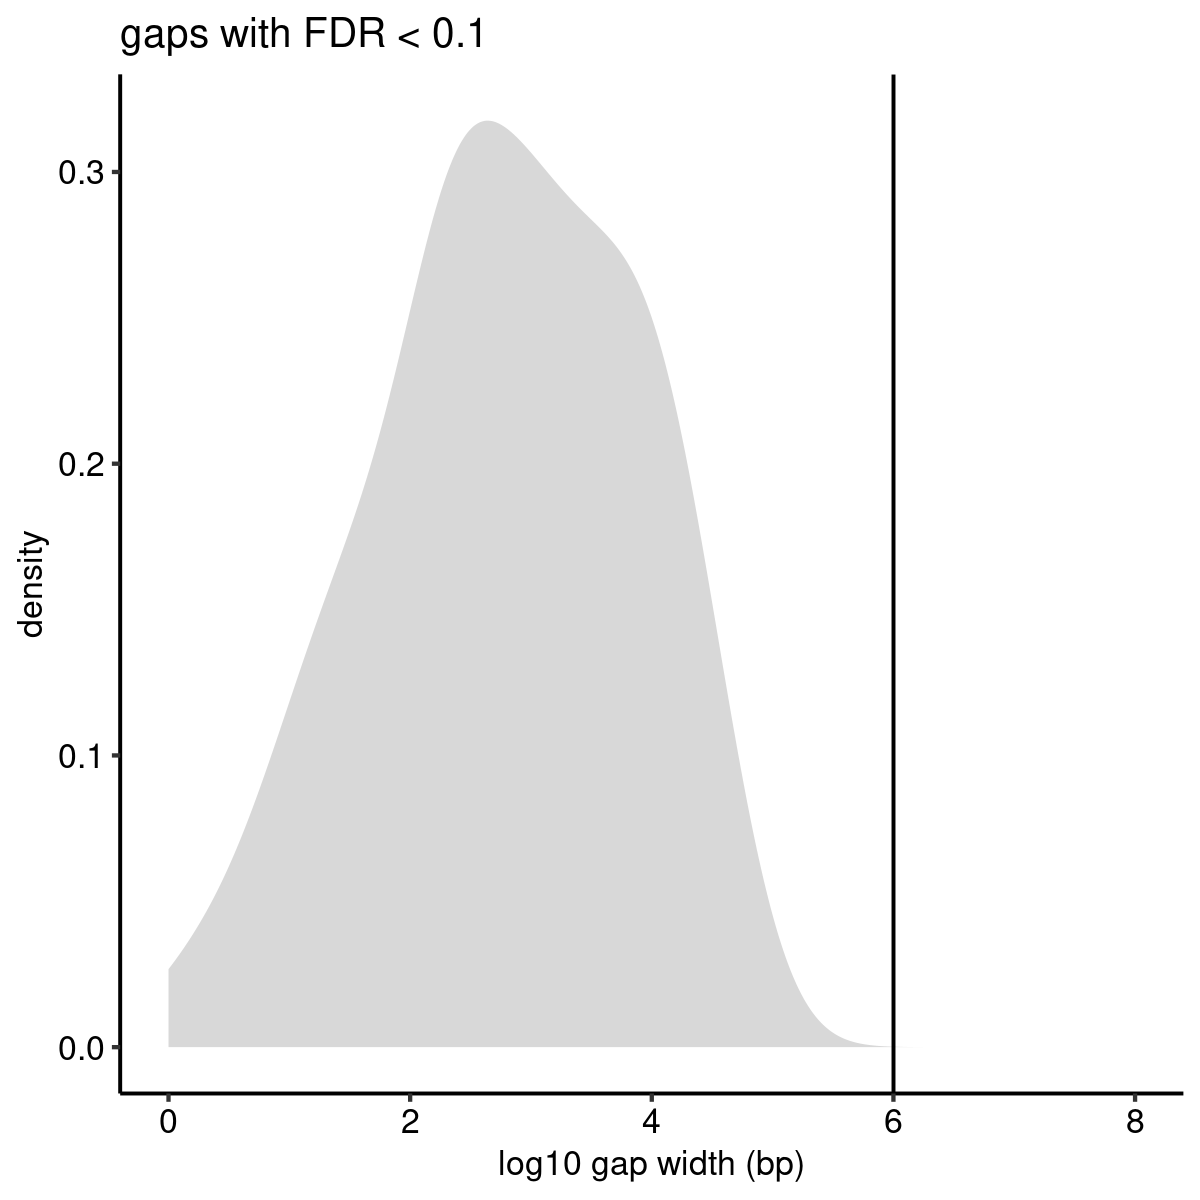

In [116]:
options(repr.plot.height = 6, repr.plot.width = 6)
print(pt)

## ED2d
Histogram of reciprocal SV cluster lengths across 283 tumor samples.

In [117]:
reciprocal.dt = readRDS("./data/revision.eclusters.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

In [118]:
gap.breaks = c(0:18, 10000)
gap.labels = c(as.character(1:18), "19+")
reciprocal.dt[, gap_level := cut(numjun, gap.breaks, gap.labels)]

## use init_bopp samples
reciprocal.gaps.dt = reciprocal.dt[(sample %in% hrd_tbl[(init_bopp_cohort), pair]) & 
                                   !((!circular) & ngap == 1),  ## exclude one-gap linear
                                   .(nclust = length(unique(paste(ecluster, sample)))), 
                                   by = gap_level]

reciprocal.gaps.dt[, total := sum(nclust)]
reciprocal.gaps.dt[, ci.lower := mapply(function(x, y) {dflm(prop.test(x, y))$ci.lower}, nclust, total) %>% unlist] 
reciprocal.gaps.dt[, ci.upper := mapply(function(x, y) {dflm(prop.test(x, y))$ci.upper}, nclust, total) %>% unlist] 

In [119]:
pt = ggplot(reciprocal.gaps.dt[gap_level != "1"], aes(x = gap_level, y = nclust / total)) +
geom_bar(stat = "identity") +
geom_errorbar(aes(ymin = ci.lower, ymax = ci.upper), width = 0.2, position = "dodge") +
labs(x = "number of junctions", y = "fraction of clusters") +
ylim(0, 0.4) +
ggpubr::theme_pubr()

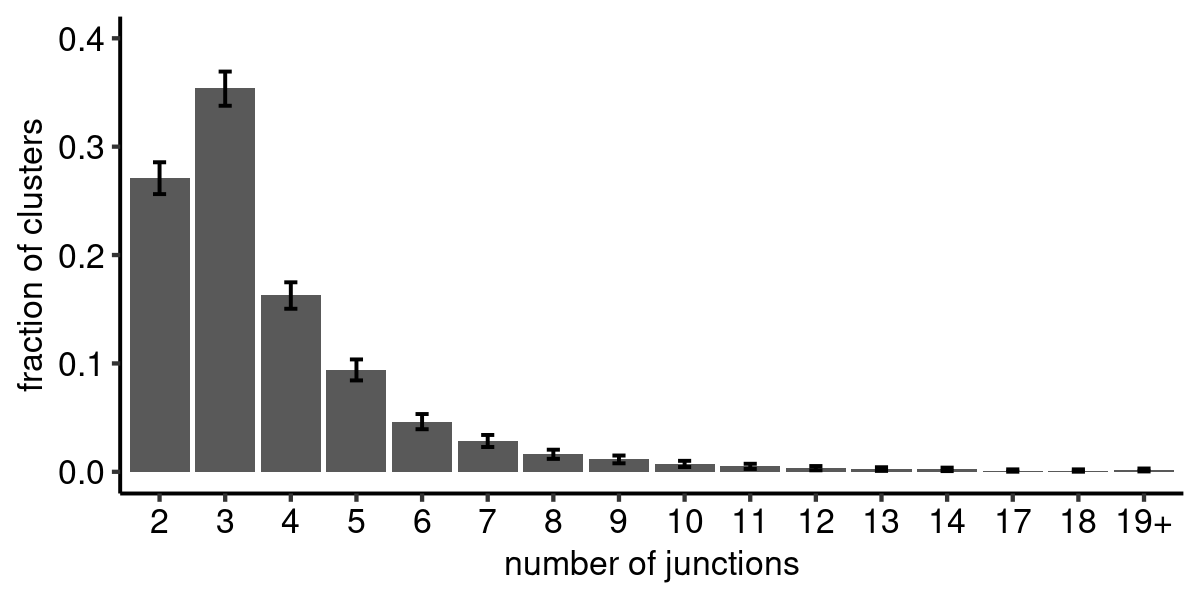

In [121]:
options(repr.plot.height = 3, repr.plot.width = 6)
pt

## ED2e

Violin plots comparing cyclic vs. linear and 2 way vs. higher order (3+ way) reciprocal SV topologies. P values obtained by Wald test on a gamma-Poisson regression model. 


In [122]:
reciprocal.dt = readRDS("./data/revision.eclusters.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

In [123]:
gap.breaks = c(0, 1, 2, 10000)
gap.labels = c("1", "2", "3+")
reciprocal.dt[, gap_level := cut(number_of_links, gap.breaks, gap.labels)]

combos = expand.grid(gap_level = gap.labels,
                     circular = c(TRUE, FALSE),
                     sample = hrd_tbl[(init_bopp_cohort), pair]) %>% as.data.table


## use init_bopp samples
# reciprocal.gaps.dt = reciprocal.dt[(sample %in% hrd_tbl[(init_bopp_cohort), pair]),
#                                    .(nclust = length(unique(ecluster))), 
#                                    keyby = .(gap_level, circular, sample)]

## try with discovery cohort (column is figure1_train)
reciprocal.gaps.dt = reciprocal.dt[(sample %in% hrd_tbl[(init_bopp_cohort & figure1_train), pair]),
                                   .(nclust = length(unique(ecluster))), 
                                   keyby = .(gap_level, circular, sample)]

## add back all of the combinations
reciprocal.gaps.dt = reciprocal.gaps.dt[combos]
reciprocal.gaps.dt[is.na(reciprocal.gaps.dt)] = 0

reciprocal.gaps.dt[, circular_label := ordered(ifelse(circular, "cyclic", "non-cyclic"), levels = c("cyclic", "non-cyclic"))]
reciprocal.gaps.dt[, genotype := ordered(hrd_tbl[sample, fmut_bi], levels = c("BRCA1", "BRCA2", "WT"))]

### Cyclic reciprocal clusters

In [141]:
pt = ggplot(reciprocal.gaps.dt[(circular)][gap_level != "1"], aes(x = genotype, y = nclust, fill = genotype)) +
geom_violin(scale = "width") +
labs(x = "genotype", y = "number of clusters per sample", title = "cyclic") +
facet_wrap(~ gap_level, scales = "free") +
ggpubr::theme_pubr()

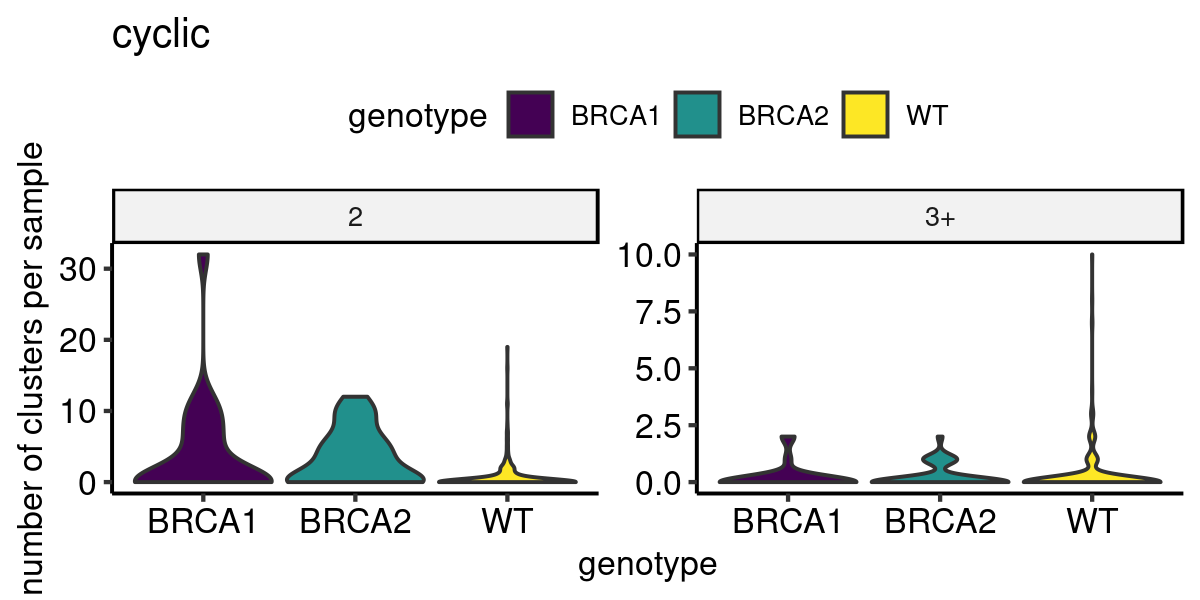

In [142]:
options(repr.plot.height = 3, repr.plot.width = 6)
pt

In [143]:
## statistical testing - comparison to WT
pt.dt = reciprocal.gaps.dt[(circular & gap_level != "1")][, count := nclust][, category := gap_level]

combos = expand.grid(genotype = c("BRCA1", "BRCA2"),
                     category = pt.dt[, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "WT" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = skitools::dflm(res)
    dt[, genotype := gn]
    dt[, type := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt

name                              method                    p       
1  as.character(genotype) == gnTRUE Negative Binomial(0.1636) 3.57e-04
2  as.character(genotype) == gnTRUE Negative Binomial(0.1907) 2.14e-05
3  as.character(genotype) == gnTRUE Negative Binomial(0.1325) 7.35e-01
4  as.character(genotype) == gnTRUE Negative Binomial(0.1482) 9.08e-01
  estimate  ci.lower  ci.upper  effect             genotype type
1 6.6448063 2.3489992 18.796708 6.64 [2.35-18.8]   BRCA1    2   
2 5.7159624 2.5579954 12.772590 5.72 [2.56-12.8]   BRCA2    2   
3 0.7804487 0.1854157  3.285052 0.78 [0.185-3.29]  BRCA1    3+  
4 0.9365385 0.3090177  2.838362 0.937 [0.309-2.84] BRCA2    3+

In [144]:
## statistical testing - comparison between BRCA1 and BRCA2
combos = expand.grid(genotype = c("BRCA1"),
                     category = pt.dt[, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "BRCA2" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = skitools::dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt

name                              method                    p     estimate 
1  as.character(genotype) == gnTRUE Negative Binomial(0.2949) 0.765 1.1625000
2  as.character(genotype) == gnTRUE Negative Binomial(0.8729) 0.771 0.8333333
  ci.lower  ci.upper effect             genotype category
1 0.4324210 3.125209 1.16 [0.432-3.13]  BRCA1    2       
2 0.2447831 2.836979 0.833 [0.245-2.84] BRCA1    3+

### Non-cyclic reciprocal clusters

In [145]:
pt = ggplot(reciprocal.gaps.dt[(!circular)][as.numeric(gap_level) > 1], aes(x = genotype, y = nclust, fill = genotype)) +
geom_violin(scale = "width") +
labs(x = "genotype", y = "number of clusters per sample", title = "non-cyclic") +
facet_wrap(~ gap_level, scales = "free") +
ggpubr::theme_pubr()

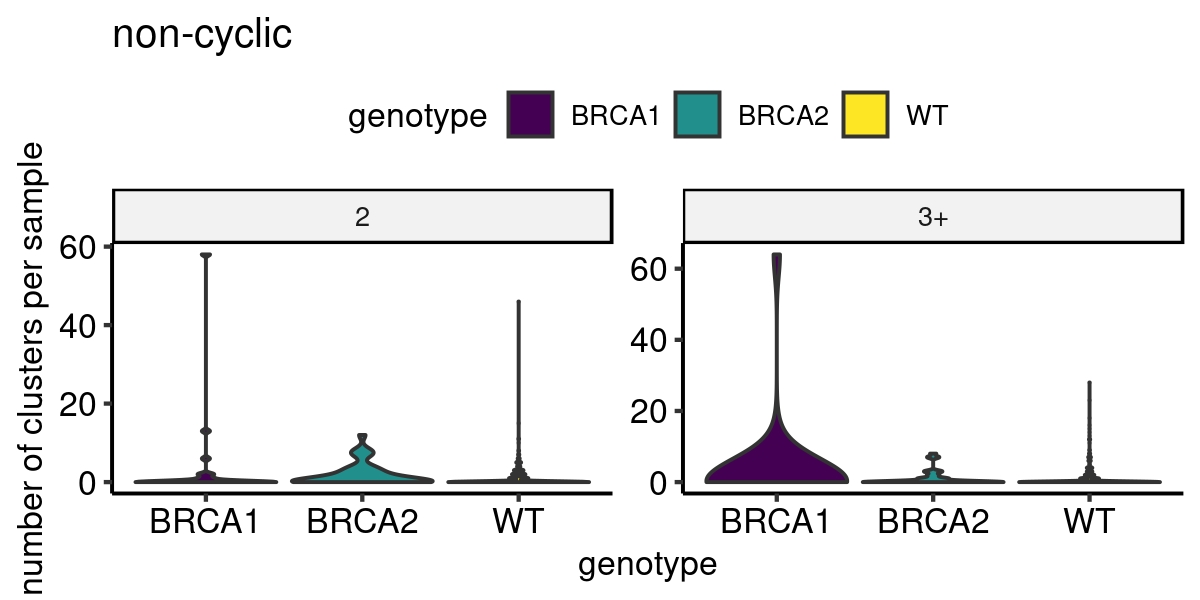

In [146]:
options(repr.plot.height = 3, repr.plot.width = 6)
pt

In [147]:
## statistical testing - comparison between BRCA1 and BRCA2
combos = expand.grid(genotype = c("BRCA1"),
                     category = pt.dt[, unique(as.character(category))])

pvals.dt = mapply(function(gn, sv) {
    res = MASS::glm.nb(data = pt.dt[genotype == "BRCA2" | genotype == gn][as.character(category) == sv],
                       formula = count ~ (as.character(genotype) == gn))
    dt = skitools::dflm(res)
    dt[, genotype := gn]
    dt[, category := sv]
    return(dt)
}, 
                  combos$genotype %>% as.character, 
                  combos$category %>% as.character,
                 SIMPLIFY = FALSE)

pvals.dt = rbindlist(pvals.dt, fill = TRUE)[!(name %like% "Intercept")]
pvals.dt

name                              method                    p     estimate 
1  as.character(genotype) == gnTRUE Negative Binomial(0.2949) 0.765 1.1625000
2  as.character(genotype) == gnTRUE Negative Binomial(0.8729) 0.771 0.8333333
  ci.lower  ci.upper effect             genotype category
1 0.4324210 3.125209 1.16 [0.432-3.13]  BRCA1    2       
2 0.2447831 2.836979 0.833 [0.245-2.84] BRCA1    3+

# Extended data figure 3

This is a description of some characteristics of the 10X Starr cohort from MSK

## ED3b
Molecular and pathological characteristics of the 46 breast cancer cases profiled with LR WGS in this cohort.

### Grabbing for oncoprint from job outputs
The following cells can actually be skipped and the required tables can be read in below.

In [163]:
## read inputs
msk.metadata <- readRDS("./data/oncoprint/msk_case_metadata.rds")
jb.hrdg <- readRDS("./data/oncoprint/HRDGenotype_w_Oncotable.rds")
jb.hrdg.ascat <- readRDS("./data/oncoprint/HRDGenotype_w_Oncotable.ascat.rds")

## get ER/PR/HER2 status of MSK samples
msk.metadata[, ":="(id = gsub("MI([0-9]+).*", "\\1", sample_id),
                    ER = grepl("Pos", er),
                    PR = grepl("Pos", pr),
                    HER2 = grepl("Pos", her2))]

## get genotypes from ASCAT and JaBbA oncoprint jobs
genos = lapply(Flow::ids(jb.hrdg),
               function(pr, tbl) {
                   hrdg = readRDS(tbl[pr, genotypes_hrd])[gene_name %in% c("BRCA1", "BRCA2")]
                   hrdg[, pair := pr]
                   return(hrdg)
               },
              Flow::outputs(jb.hrdg))

genos = rbindlist(genos, use.names = TRUE, fill = TRUE)
setkey(genos, "pair")

genos.ascat = lapply(Flow::ids(jb.hrdg.ascat),
               function(pr, tbl) {
                   hrdg = readRDS(tbl[pr, genotypes_hrd])[gene_name %in% c("BRCA1", "BRCA2")]
                   hrdg[, pair := pr]
                   return(hrdg)
               },
              Flow::outputs(jb.hrdg.ascat))

genos.ascat = rbindlist(genos.ascat, use.names = TRUE, fill = TRUE)
setkey(genos.ascat, "pair")

## we did some manual curation and as a result some tumors use ASCAT purity/ploidy calls
ascat.samples = c("9", "15", "19", "69")
excluded.samples = c("90")

## merge oncotable output with MSK metadata for non-ascat samples
non.ascat.samples = setdiff(Flow::ids(jb.hrdg), excluded.samples)

## get ascat oncotable from genotyping job
oncotable.ascat = lapply(Flow::outputs(jb.hrdg.ascat)[ascat.samples, oncotable_hrd],
                         function(fn) {
                             return(readRDS(fn))
                         }) %>% rbindlist(fill = TRUE, use.names = TRUE)

## get oncotable for other samples from genotyping job
oncotable.other = lapply(Flow::outputs(jb.hrdg)[non.ascat.samples, oncotable_hrd],
                         function(fn) {
                             return(readRDS(fn))
                         }) %>% rbindlist(fill = TRUE, use.names = TRUE)

oncotable = rbind(oncotable.ascat, oncotable.other, fill = TRUE, use.names = TRUE)

In [168]:
## merge oncotable output with MSK metadata
tumors.ascat = cbind(Flow::outputs(jb.hrdg.ascat)[ascat.samples, 
                                                  .(id = pair, oncotable_hrd)],
                     genos.ascat[gene_name == "BRCA1"][ascat.samples, 
                                                       .(brca1d_biallelic = biallelic_pathogenic_all,
                                                         brca1_loh = loh,
                                                         brca1_germline_sv = germline_sv)],
                     genos.ascat[gene_name == "BRCA2"][ascat.samples,
                                                      .(brca2d_biallelic = biallelic_pathogenic_all,
                                                        brca2_loh = loh,
                                                        brca2_germline_sv = germline_sv)],
                     msk.metadata[match(ascat.samples, id),
                                 .(ER, PR, HER2)])

tumors.other = cbind(Flow::outputs(jb.hrdg)[non.ascat.samples, 
                                                  .(id = pair, oncotable_hrd)],
                     genos.ascat[gene_name == "BRCA1"][non.ascat.samples, 
                                                       .(brca1d_biallelic = biallelic_pathogenic_all,
                                                         brca1_loh = loh,
                                                         brca1_germline_sv = germline_sv)],
                     genos.ascat[gene_name == "BRCA2"][non.ascat.samples,
                                                      .(brca2d_biallelic = biallelic_pathogenic_all,
                                                        brca2_loh = loh,
                                                        brca2_germline_sv = germline_sv)],
                     msk.metadata[match(non.ascat.samples, id),
                                 .(ER, PR, HER2)])

tumors = rbind(tumors.ascat, tumors.other)

# updating biallelic statuses based on manual team reviews and considering germline svs:
tumors[id %in% c("27", "78", "93"), brca1d_biallelic := FALSE]
tumors[id %in% c("13", "48", "64"), brca1d_biallelic := TRUE]
tumors[id %in% c("90"), brca2d_biallelic := FALSE]
tumors[brca1_germline_sv > 0 & brca1_loh==TRUE, brca1d_biallelic := TRUE]
tumors[brca2_germline_sv > 0 & brca2_loh==TRUE, brca2d_biallelic := TRUE]
tumors <- tumors[order(-brca1d_biallelic, -brca2d_biallelic, -ER, -PR, -HER2)]

# filter oncotable small variants - clinvar score takes precidence
# snpeff_pathogenicity and snpeff_msk_pathogenicity cols are only different in that normally splice acceptor/donor variants score 3, 
# but we're including them as pathogenic so scoring them higher at 4
oncotable <- oncotable[is.na(vartype) | ifelse(!is.na(clinvar_pathogenicity), clinvar_pathogenicity >= 4, snpeff_msk_pathogenicity >=4)]

### add 64 BRCA1 germ SNV (found by MSK with a typo, kevin check it and saw that it didn't quite pass filtering due to low AC)
### TODO: add 48 BRCA1 somatic var (if it's a circle - how to show both circles?)
var.rows.to.add <- data.table("id"=c("48","64"), "type"="trunc", "source"="msk_and_kevin_manual", "track"="variants", "gene"="BRCA1", "vartype"="SNV", 
                              "variant.g"=c("17:41245936-41245936 C>T","17:41226499-41226499 G>A"))
oncotable <- rbind(oncotable, var.rows.to.add, fill=TRUE)

oncotable <- oncotable[!(id %in% c("27","93") & type=="loh" & gene=="BRCA1")]  # remove 27, 93 BRCA1 LOH based on inspection (no LOH with ascat ploidy + ppgrid purity, or with drylean)
oncotable <- oncotable[!(id=="78" & type=="homdel" & gene %in% c("BRCA1","BRCA2"))]   # everywhere else has LOH for both genes here, not homdels
oncotable <- oncotable[!(id=="90" & type=="homdel" & gene=="BRCA2")]  # everywhere else has LOH here, not homdel

# add 13 LOH (BRCA1 AND BRCA2?), add 78 LOH (BRCA1 and BRCA2), add 90 LOH (BRCA2) to replace old "false?" homdel
loh.rows.to.add <- data.table("id"=c("13","13","78","78","90"), "type"="loh", "track"="variants", "gene"=c("BRCA1","BRCA2","BRCA1","BRCA2","BRCA2"))
oncotable <- rbind(oncotable, loh.rows.to.add, fill=TRUE)

# case 2 BRCA2 LOH is questionable but just leave it for now
oncotable <- oncotable[id != "90"]

In [420]:
saveRDS(tumors, "./data/oncoprint/oncoprint.tumors.rds")
saveRDS(oncotable, "./data/oncoprint/oncotable.tumors.rds")


START HERE!

In [421]:
tumors = readRDS("./data/oncoprint/oncoprint.tumors.rds")
oncotable = readRDS("./data/oncoprint/oncotable.tumors.rds")

In [422]:
op = oncoprint_hrd(tumors=tumors, oncotab=oncotable, 
                   genes=c("BRCA1","BRCA2"), 
                   columns=c("brca1d_biallelic","brca2d_biallelic", "ER", "PR", "HER2"),
                   cna=TRUE, 
                   signature=FALSE, 
                   svevents=TRUE, 
                   sort=FALSE)

brca1d_biallelicbrca2d_biallelicERPRHER2

All mutation types: missense, trunc, dummy, loh, germ_sv, splice.

Colors are not defined for: dummy. They won't be shown in the barplots.



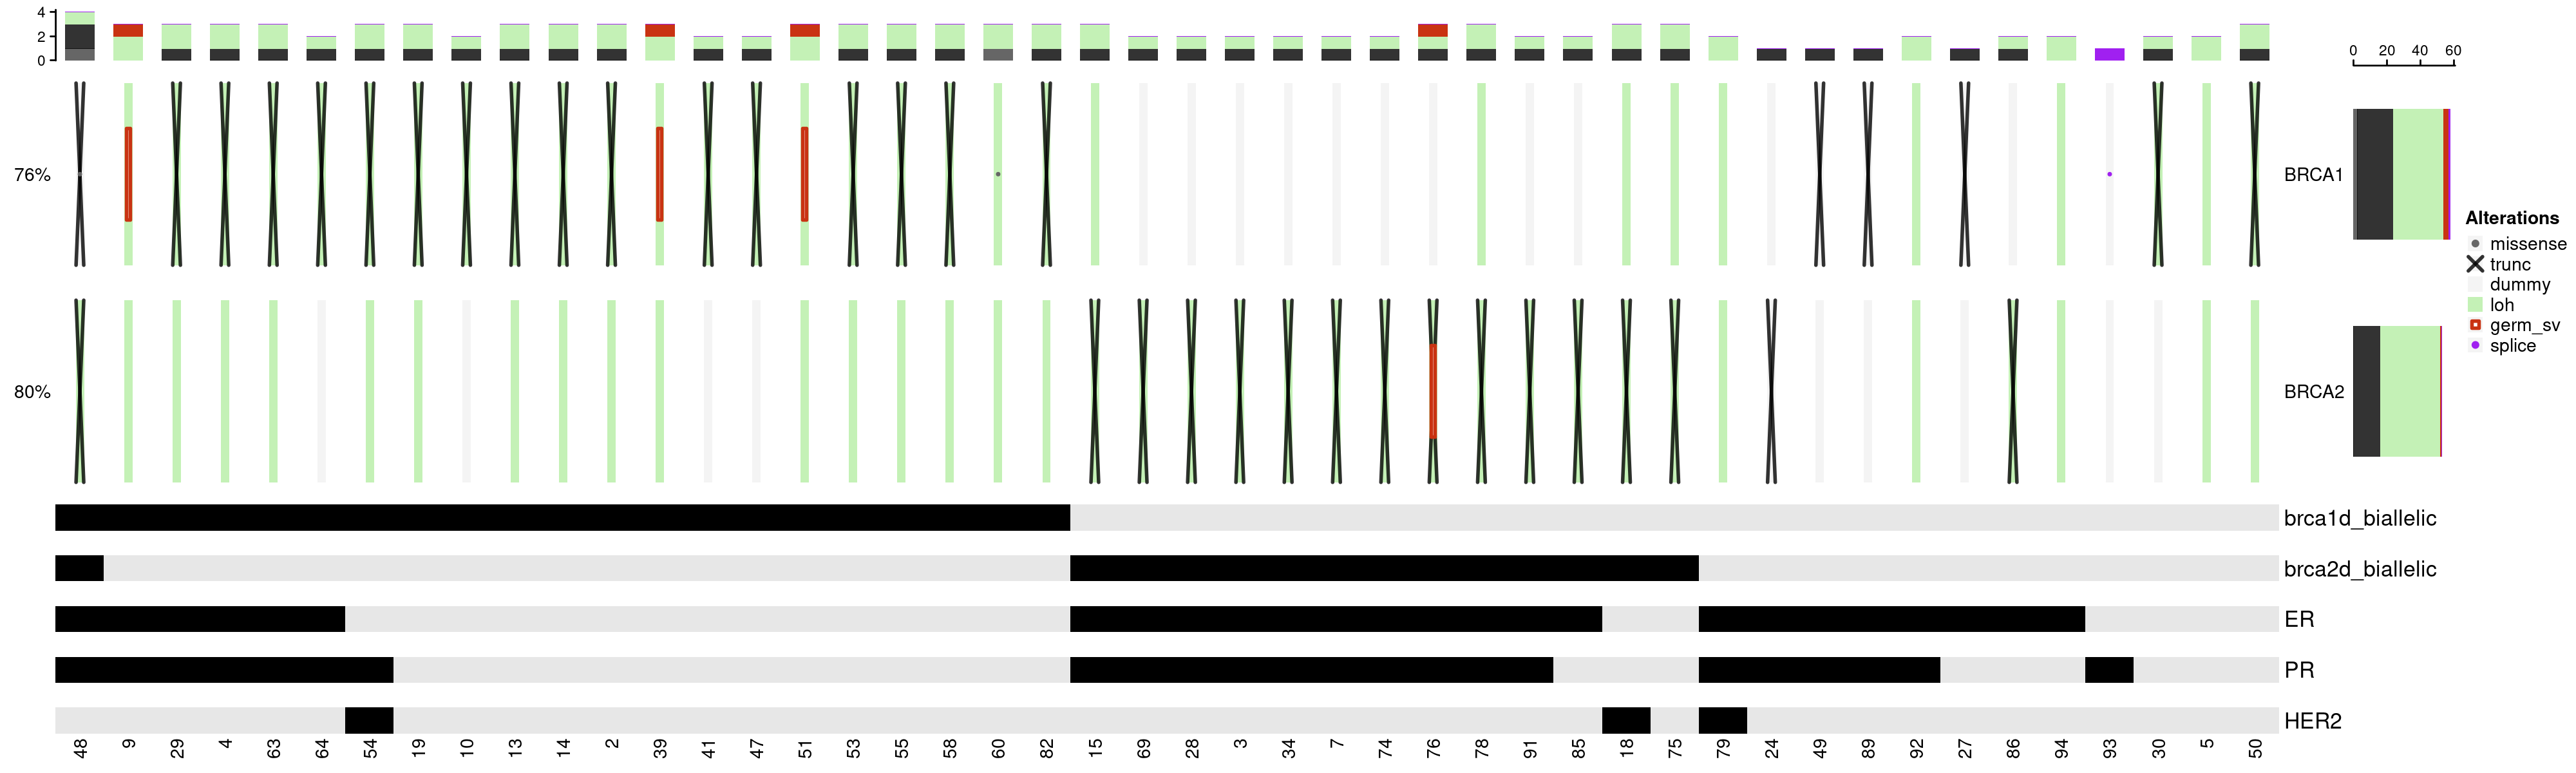

In [423]:
options(repr.plot.height = 6, repr.plot.width = 20, repr.plot.res = 200)
print(op)

In [172]:
## skitools::ppdf(print(op), width = 20, height = 4)

## ED3d

In [188]:
bx.stats.dt = readRDS("./data/lrs_qc/lrs.sequencing.stats.dt.rds")

In [181]:
## physical coverage plot
pt = ggplot(bx.stats.dt, aes(x = physical_coverage)) +
geom_density(fill = "gray", color = NA, alpha = 0.5, bw = 20) +
labs(x = "physical coverage", y = "density") +
xlim(0, 400) +
ggpubr::theme_pubr()

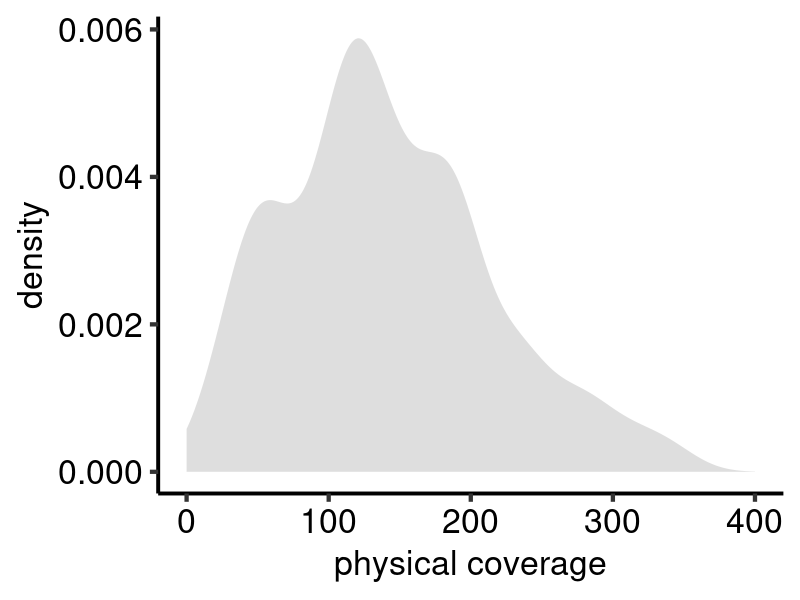

In [182]:
options(repr.plot.height = 3, repr.plot.width = 4)
pt

In [183]:
## physical coverage plot
pt = ggplot(bx.stats.dt, aes(x = n50_cloud_length)) +
geom_density(fill = "gray", color = NA, alpha = 0.5) +
labs(x = "N50 cloud length", y = "density") +
xlim(0, 6e4) +
ggpubr::theme_pubr()

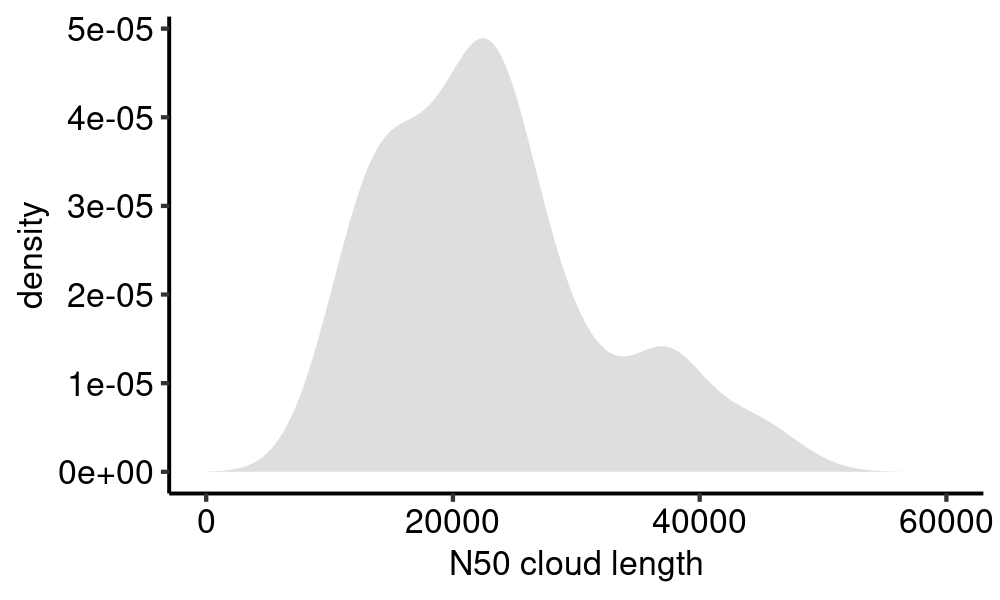

In [184]:
options(repr.plot.height = 3, repr.plot.width = 5)
pt

## ED3d
Concordance between LR WGS and short-read WGS reciprocal pair calls.

### Extract events from Flow jobs
**This section can be skipped!**
The outputs have been saved and can be read directly below.

In [193]:
## this is a job
##jb.recall = readRDS("./data/lrs_qc/junctionrecall_10x_ggraph.rds") 
events.dt = readRDS("./data/revision.events.dt.rds")
## opairs = Flow::outputs(readRDS("./data/lrs_qc/events_10x.rds"))
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

In [194]:
## this code block will extract events from a Flow Job outout
## lrs.pairs = opairs[file.exists(complex_10x) &  ## there is a complex events graph for 10x
##                    (hrd_tbl[pair, fmut_bi == "BRCA1" | fmut_bi == "BRCA2"]) & ## biallelic
##                    file.exists(Flow::outputs(jb.recall)[pair, ggraph_marked_10x_support]), ## job finished
##                   pair]

In [195]:
## srs.events.dt = lapply(lrs.pairs,
##                       function(pr, tbl) {
##                          gg = readRDS(tbl[pr, ggraph_marked_10x_support])
##                          dt = gg$meta$events
##                          edges = gg$edges$dt
##                          if (edges[, .N] && "num_support_10x" %in% names(edges)) {
##                              edt = edges[, .(supp = sum(num_support_10x, na.rm = TRUE)), by = ecluster][!is.na(ecluster)]
##                          } else {
##                              edt = data.table()
##                          }
##                          if (dt[, .N] && edt[, .N]) {
##                              setkeyv(edt, "ecluster")
##                              dt[, num_support_10x := edt[ecluster, supp]]
##                          }
##                          if (dt[, .N]) {
##                              dt[, sample := pr]
##                          }
##                          return(dt)
##                      },
##                       Flow::outputs(jb.recall))

In [196]:
## srs.events.dt = rbindlist(srs.events.dt, fill = TRUE)

In [197]:
## lrs.events.dt = lapply(lrs.pairs,
##                      function(pr, tbl) {
##                           dt = readRDS(tbl[pr, complex_10x])$meta$events
##                           if ((!is.null(dt)) && dt[, .N]) {
##                               dt[, sample := pr]
##                           } else {
##                               dt = data.table()
##                           }
##                           return(dt)
##                        },
##                      opairs)

In [198]:
## lrs.events.dt = rbindlist(lrs.events.dt, fill = TRUE)

In [410]:
events.dt = readRDS("./data/revision.events.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
lrs.events.dt = readRDS("./data/lrs_qc/lrs.events.dt.rds")
srs.events.dt = readRDS("./data/lrs_qc/srs.events.dt.rds")

In [411]:
lrs.events.dt = lrs.events.dt[!grepl("NA", footprint)]
srs.events.dt = srs.events.dt[!grepl("NA", footprint)]

## unify labels
lrs.events.dt[type == "tib", type := "qrpmix"]
lrs.events.dt[type == "qrdup", type := "qrppos"]
lrs.events.dt[type == "qrdel", type := "qrpmin"]

srs.events.dt[type == "tib", type := "qrpmix"]
srs.events.dt[type == "qrdup", type := "qrppos"]
srs.events.dt[type == "qrdel", type := "qrpmin"]

In [409]:
## SAVE THESE DATA TABLES
## saveRDS(lrs.events.dt, "./data/lrs_qc/lrs.events.dt.rds")
## saveRDS(srs.events.dt, "./data/lrs_qc/srs.events.dt.rds")

### compare rDup, rDel, and rDelDups separately...

In [412]:
## check one event type at a time - qrppos
qrppos.pairs = union(lrs.events.dt[type == "qrppos", sample], srs.events.dt[type == "qrppos", sample])

qrppos.ov = lapply(qrppos.pairs,
                  function(pr) {
                      lrs.dt = lrs.events.dt[type == "qrppos" & sample == pr, ]
                      srs.dt = srs.events.dt[type == "qrppos" & sample == pr, ]
                      if (lrs.dt[, .N] && srs.dt[, .N]) {
                          ov = as.data.table(gGnome:::ra.overlaps(lrs.dt[, parse.grl(footprint)],
                                                                  srs.dt[, parse.grl(footprint)],
                                                                  pad = 1e4))
                      } else {
                          ov = data.table()
                      }
                      if (!ov[, .N]) {ov[, ":="(ra1.ix = numeric(), ra2.ix = numeric())]}
                      lrs.dt[, overlap := ifelse(1:.N %in% ov[, ra1.ix], "overlap", "lrs")]
                      srs.dt[, overlap := ifelse(1:.N %in% ov[, ra2.ix] | num_support_10x > 0, "overlap", "srs")]
                      return(rbind(lrs.dt[, .(sample, type, footprint, overlap, origin = "lrs")],
                                   srs.dt[, .(sample, type, footprint, overlap, origin = "srs")]))
                      }
                  )

qrppos.ov.dt = rbindlist(qrppos.ov, fill = TRUE)

Warning message in as.data.table.list(jval, .named = NULL):
“Item 1 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 2 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 3 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 4 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 1 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 2 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 3 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 4 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .nam

In [413]:
## check one event type at a time
qrpmix.pairs = union(lrs.events.dt[type == "qrpmix", sample], srs.events.dt[type == "qrpmix", sample])

qrpmix.ov = lapply(qrpmix.pairs,
                  function(pr) {
                      lrs.dt = lrs.events.dt[type == "qrpmix" & sample == pr, ]
                      srs.dt = srs.events.dt[type == "qrpmix" & sample == pr, ]
                      if (lrs.dt[, .N] && srs.dt[, .N]) {
                          ov = as.data.table(gGnome:::ra.overlaps(lrs.dt[, parse.grl(footprint)],
                                                                  srs.dt[, parse.grl(footprint)],
                                                                  pad = 1e4))
                      } else {
                          ov = data.table()
                      }
                      if (!ov[, .N]) {ov[, ":="(ra1.ix = numeric(), ra2.ix = numeric())]}
                      lrs.dt[, overlap := ifelse(1:.N %in% ov[, ra1.ix], "overlap", "lrs")]
                      srs.dt[, overlap := ifelse(1:.N %in% ov[, ra2.ix] | num_support_10x > 0, "overlap", "srs")]
                      return(rbind(lrs.dt[, .(sample, type, footprint, overlap, origin = "lrs")],
                                   srs.dt[, .(sample, type, footprint, overlap, origin = "srs")]))
                      }
                  )

qrpmix.ov.dt = rbindlist(qrpmix.ov, fill = TRUE)

Warning message in as.data.table.list(jval, .named = NULL):
“Item 1 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 2 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 3 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 4 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 1 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 2 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 3 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 4 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .nam

In [414]:
## check one event type at a time
qrpmin.pairs = union(lrs.events.dt[type == "qrpmin", sample], srs.events.dt[type == "qrpmin", sample])

qrpmin.ov = lapply(qrpmin.pairs,
                  function(pr) {
                      lrs.dt = lrs.events.dt[type == "qrpmin" & sample == pr, ]
                      srs.dt = srs.events.dt[type == "qrpmin" & sample == pr, ]
                      if (lrs.dt[, .N] && srs.dt[, .N]) {
                          ov = as.data.table(gGnome:::ra.overlaps(lrs.dt[, parse.grl(footprint)],
                                                                  srs.dt[, parse.grl(footprint)],
                                                                  pad = 1e4))
                      } else {
                          ov = data.table()
                      }
                      if (!ov[, .N]) {ov[, ":="(ra1.ix = numeric(), ra2.ix = numeric())]}
                      lrs.dt[, overlap := ifelse(1:.N %in% ov[, ra1.ix], "overlap", "lrs")]
                      srs.dt[, overlap := ifelse(1:.N %in% ov[, ra2.ix] | num_support_10x > 0, "overlap", "srs")]
                      return(rbind(lrs.dt[, .(sample, type, footprint, overlap, origin = "lrs")],
                                   srs.dt[, .(sample, type, footprint, overlap, origin = "srs")]))
                      }
                  )

qrpmin.ov.dt = rbindlist(qrpmin.ov, fill = TRUE)

Warning message in as.data.table.list(jval, .named = NULL):
“Item 1 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 2 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 3 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 4 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 1 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 2 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 3 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .named = NULL):
“Item 4 has 0 rows but longest item has 1; filled with NA”
Warning message in as.data.table.list(jval, .nam

### produce Venn diagrams
To view these Venn diagrams, change the output file name (`filename` argument below) to desired path.

In [415]:
qrppos.ov.dt[, uid := 1:.N]
qrppos.list = list("LRS" = qrppos.ov.dt[(origin == 'lrs' | overlap == "overlap"), uid],
                   "SRS" = qrppos.ov.dt[(origin == 'srs'), uid])

v = VennDiagram::venn.diagram(qrppos.list, 
                              filename = "~/public_html/plot.png", ## CHANGE ME!!
                              height = 800, width = 800, resolution = 500,
                              imagetype = "png",
                              lwd = 2,
                              lty = "blank",
                              fill = c("pink", "blue"),
                              cex = 0.6,
                              fontfamily = "sans",
                              cat.cex = 0.6,
                              cat.default.pos = "outer",
                              catpos = c(-27, 27),
                              cat.dist = c(0.1,0.1),
                              cat.fontfamily = "sans",
                              )

In [416]:
qrpmin.ov.dt = qrpmin.ov.dt[!is.na(sample) & !is.na(footprint)]

In [417]:
qrpmin.ov.dt[, uid := 1:.N]

## don't double count the intersection
qrpmin.list = list("LRS" = qrpmin.ov.dt[(origin == "lrs" | overlap == "overlap"), footprint],
                   "SRS" = qrpmin.ov.dt[(origin == "srs"), footprint])

v = VennDiagram::venn.diagram(qrpmin.list, 
                              filename = "~/public_html/plot.png", 
                              height = 800, width = 800, resolution = 500,
                              imagetype = "png",
                              lwd = 2,
                              lty = "blank",
                              fill = c("pink", "blue"),
                              cex = 0.6,
                              fontfamily = "sans",
                              cat.cex = 0.2,
                              cat.default.pos = "outer",
                              catpos = c(-180, 180),
                              cat.dist = c(0.1,0.1),
                              cat.fontfamily = "sans",
                              )

In [418]:
qrpmix.ov.dt = qrpmix.ov.dt[!is.na(sample) & !is.na(footprint)]

In [419]:
qrpmix.ov.dt[, uid := 1:.N]
qrpmix.list = list("LRS" = qrpmix.ov.dt[(origin == "lrs" | overlap == "overlap"), uid],
                   "SRS" = qrpmix.ov.dt[(origin == "srs"), uid])

v = VennDiagram::venn.diagram(qrpmix.list, 
                              filename = "~/public_html/plot.png", 
                              height = 800, width = 800, resolution = 500,
                              imagetype = "png",
                              lwd = 2,
                              lty = "blank",
                              fill = c("pink", "blue"),
                              cex = 0.6,
                              fontfamily = "sans",
                              cat.cex = 0.6,
                              cat.default.pos = "outer",
                              catpos = c(-27, 27),
                              cat.dist = c(0.1,0.1),
                              cat.fontfamily = "sans",
                              )

## ED3e
Comparison of rDup and rDel counts among BRCA1d (n = 22) and BRCA2d (n = 14) cases within the LRS cohort. P values obtained by Wald test on a gamma-Poisson regression model.

In [208]:
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
events.dt = readRDS("./data/revision.events.dt.rds")

In [209]:
## counts per sample
qrp.counts.dt = events.dt[(type == "qrppos" | type == "qrpmin"), .N, keyby = .(sample, type)]

## get the counts per sample of starr cohort
combos = expand.grid(sample = hrd_tbl[(dataset == "STARR") & (fmut_bi %in% c("BRCA1", "BRCA2")), pair],
                     type = c("qrppos", "qrpmin"),
                     stringsAsFactors = FALSE) %>% as.data.table

starr.counts.dt = qrp.counts.dt[combos]
starr.counts.dt[is.na(starr.counts.dt)] <- 0

## add genotype
starr.counts.dt[, genotype := ordered(hrd_tbl[sample, fmut_bi], levels = c("BRCA1", "BRCA2"))]

## add type
qrp.map = c("qrppos" = "rDup", "qrpmix" = "rDelDup", "qrpmin" = "rDel")
starr.counts.dt[, type_factor := ordered(qrp.map[type], levels = c("rDup", "rDel", "rDelDup"))]

In [211]:
pt = ggplot(starr.counts.dt, aes(x = genotype, y = N, fill = genotype)) +
    geom_violin(scale = "width") +
    facet_wrap(~ type_factor, scales = "free") +
    ggpubr::theme_pubr() +
    labs(x = "genotype", y = "events per sample")

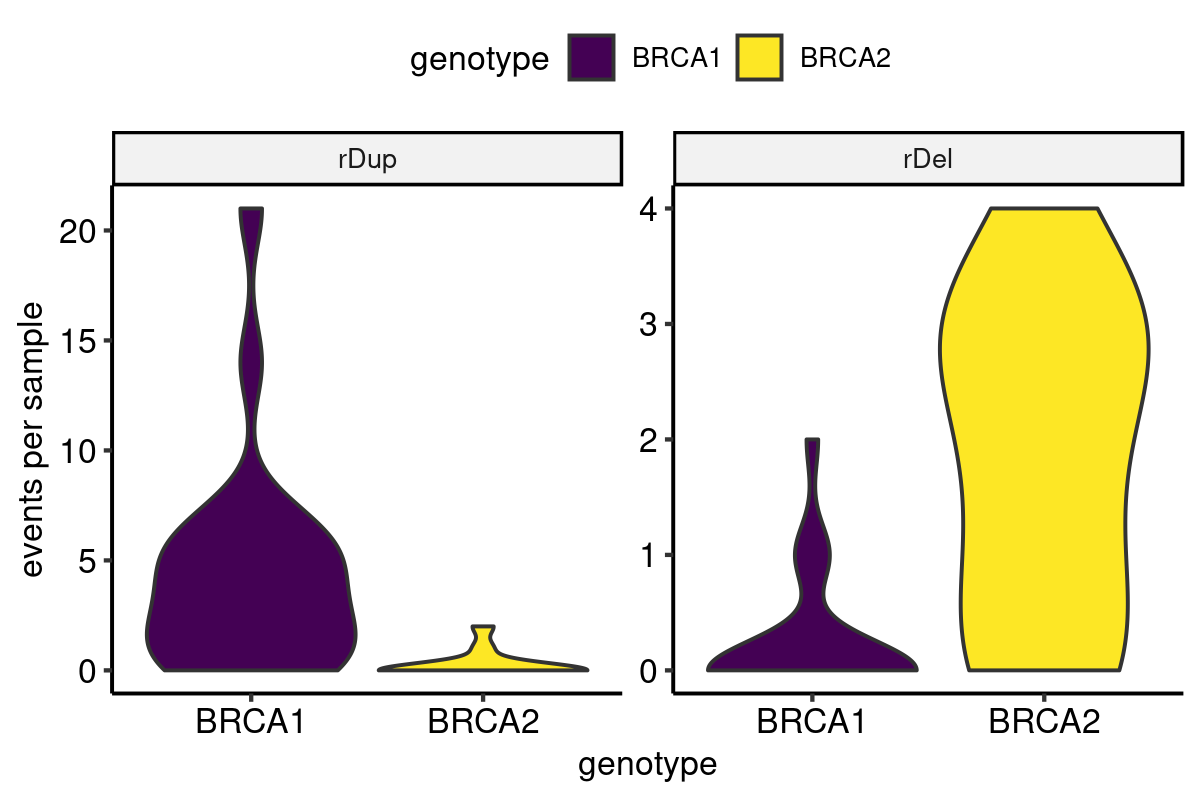

In [212]:
options(repr.plot.height = 4, repr.plot.width = 6)
pt

# Figure 3
rDup phasing in the Starr cohort

## Figure 3a

Derivative haplotypes for cis and trans rDups in somatic chromosomal coordinates harmonized so that coordinate 0 corresponds to the location of the first junction in the walk. 

Density shows  distribution of gap segment lengths within cis- and trans-phased derivative chromosomes resulting from rDups.

In [424]:
events.dt = readRDS("./data/revision.events.dt.rds") 
## phasing.barcode.counts.dt = readRDS("~/projects/Starr/BRCA/db/phasing.barcode.counts.dt.re.rds")
phasing.barcode.counts.dt = readRDS("./data/phasing/phasing.barcode.counts.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

## the job generating these barcode counts is here: 
## basically the phasing.barcode.counts.dt just stacks the outputs of phase_dt
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221102_re/qrp_phasing.rds")
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221107_re_re/qrp_phasing.rds")

## THIS ONE
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221121_re/qrp_phasing.rds")
## but ideally we don't want this dependency...

Assign phase

In [425]:
## get rDup widths from events
rdup.widths.dt = events.dt[(type == "qrppos" & sample %in% phasing.barcode.counts.dt$sample),
                          .(width.l1, width.l2, sample, ecluster)]

setkeyv(rdup.widths.dt, c("ecluster", "sample"))
setkeyv(phasing.barcode.counts.dt, c("ecluster", "sample"))

## get all supported cis walks from barcode counts
phasing.barcode.counts.dt[,phase := ifelse(cis > trans * 3 & cis > 3,
                                          "cis",
                                          ifelse(trans > cis * 3 & trans > 3, "trans", "unphased"))]

## get widths
phasing.barcode.counts.dt[, width.l1 := rdup.widths.dt[phasing.barcode.counts.dt, width.l1]]
phasing.barcode.counts.dt[, width.l2 := rdup.widths.dt[phasing.barcode.counts.dt, width.l2]]

## unset phase if over threshold
phasing.barcode.counts.dt[pmax(width.l1, width.l2) > 5e4, phase := "unphased"]

Get a list of all of the walks from Flow job (**THIS CELL CAN BE SKIPPED**)

In [426]:
## get a list of cis walk objects and collapse them
all.walks = lapply(stats::setNames(nm = Flow::outputs(qrp.phasing.jb)[file.exists(qrp_walks_rds), pair]),
                   function(pr, tbl) {
                       wks = readRDS(tbl[pr, qrp_walks_rds])
                       grl = wks$grl
                       values(grl) = wks$dt
                       gr = stack(grl)
                       if (length(wks)) {
                           values(gr)[, "sample"] = pr
                       }
                       return(gr)
                   },
                   Flow::outputs(qrp.phasing.jb))

## stack all walks into GRanges and select only the desired walks
all.walks.gr = gUtils::grbind(unlist(all.walks))

## only keep the circular positive walks
all.walks.dt = as.data.table(all.walks.gr)

## label gaps and indicate which gap is G1 or G2
## to do this we have to first get the footprints of the rDup events
## qrp.events.dt = readRDS("~/projects/Starr/BRCA/db/revision.events.dt.rds")[type == "qrppos"] 
qrp.events.dt = readRDS("~/projects/Starr/BRCA/db/revision.events.dt.rds")[type == "qrppos"] 
qrp.events.grl = qrp.events.dt[, parse.grl(footprint)]
values(qrp.events.grl)[, "ecluster"] = qrp.events.dt[, ecluster]
values(qrp.events.grl)[, "sample"] = qrp.events.dt[, sample]

all.walks.dt = merge.data.table(all.walks.dt, qrp.events.dt[pmax(width.l1, width.l2) < 5e4, .(sample, ecluster, width.l1, width.l2)],
                                by = c("ecluster", "sample"))

saveRDS(all.walks.dt, "./data/phasing/all.walks.dt.rds")
saveRDS(all.walks.gr, "./data/phasing/all.walks.gr.rds")

**START HERE**

In [427]:
all.walks.dt = readRDS("./data/phasing/all.walks.dt.rds")
all.walks.gr = readRDS("./data/phasing/all.walks.gr.rds")

### cis walks
First, we need to get the number of barcodes supporting cis or trans barcodes per walk

In [428]:
## get all cis or trans phased edge clusters corresponding with rDups
cis.clusters.dt = phasing.barcode.counts.dt[(phase == "cis")]
setkeyv(all.walks.dt, c("ecluster", "sample"))
setkeyv(cis.clusters.dt, c("ecluster", "sample"))
cis.walks.dt = cis.clusters.dt[all.walks.dt[orientation == "cis"]][!is.na(width.l1)][!is.na(width.l2)][phase == "cis"]

## subset for the supported cis walk
supported.walks.dt = cis.walks.dt[!is.na(nbx)][, max.nbx := max(nbx), by = .(ecluster, sample)][(nbx == max.nbx)][nbx > 0]

## check for ALT edges
supported.walks.dt[, previous.walk.id := data.table::shift(walk.id)]
supported.walks.dt[, previous.sample := data.table::shift(sample)]
supported.walks.dt[, previous.ecluster := data.table::shift(ecluster)]
supported.walks.dt[, previous.start := data.table::shift(start)]
supported.walks.dt[, previous.end := data.table::shift(end)]

## strand needs to go from fct --> char
supported.walks.dt[, strand := as.character(strand)]
supported.walks.dt[, previous.strand := data.table::shift(strand)]

supported.walks.dt[(strand == "+") & 
                   (walk.id == previous.walk.id & sample == previous.sample & ecluster == previous.ecluster) & 
                   (start != previous.end + 1 | strand != previous.strand), gap := TRUE]
supported.walks.dt[(strand == "-") & 
                   (walk.id == previous.walk.id & sample == previous.sample & ecluster == previous.ecluster) & 
                   (end != previous.start - 1 | strand != previous.strand), gap := TRUE]

supported.walks.dt[is.na(gap), gap := FALSE]

supported.walks.dt[, cumulative.gaps := cumsum(x = gap), by = .(sample, ecluster, walk.id)]

supported.walks.dt[, ":="(locus1 = gap & cumulative.gaps == 1)]
supported.walks.dt[, next.locus1 := data.table::shift(locus1, n = -1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[is.na(next.locus1), next.locus1 := FALSE]
supported.walks.dt[, previous.locus1 := data.table::shift(locus1, n = 1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[is.na(previous.locus1), previous.locus1 := FALSE]
supported.walks.dt[, ":="(locus2 = previous.locus1 | next.locus1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[, flank := !(locus1 | locus2)]


In [429]:
## keep only the the ones corresponding with qrppos
cis.rdups.dt = supported.walks.dt##[, any.gap := any(gap, na.rm = TRUE), by = .(ecluster, sample, walk.id)][(any.gap)]

In [430]:
## create spChains
cis.rdups.gr = dt2gr(cis.rdups.dt, seqlengths = hg_seqlengths())
cis.rdups.grl = GenomicRanges::split(cis.rdups.gr, ~ cis.rdups.dt[, paste(ecluster, sample, walk.id)])

spc = gChain::spChain(cis.rdups.grl)
lifted.dt = as.data.table(spc@.galy)
lifted.dt[, seqnames := "sequence"]
lifted.gr = dt2gr(lifted.dt)
values(lifted.gr) = values(stack(cis.rdups.grl))

## get the amount that each range should be shifted
lifted.dt = as.data.table(lifted.gr)
lifted.dt[, shift.bp := .SD[(locus1), start], by = .(ecluster, sample, walk.id)]
lifted.dt[, insert.width := .SD[(locus1), width], by = .(ecluster, sample, walk.id)]
lifted.dt[, other.width := .SD[(locus2), sum(width)], by = .(ecluster, sample, walk.id)]
lifted.dt[, col := ifelse(flank, "gray", ifelse(locus1, "blue", "purple"))]
lifted.dt[, nm := paste(ecluster, sample, walk.id)]

## shift the ranges
shifted.gr = GenomicRanges::shift(lifted.gr, shift = -lifted.dt[, shift.bp])
values(shifted.gr)[, "insert.width"] = lifted.dt[, insert.width]
values(shifted.gr)[, "other.width"] = lifted.dt[, other.width]
values(shifted.gr)[, "col"] = lifted.dt[, col]
values(shifted.gr)[, "nm"] = lifted.dt[, nm]

## get a range for the order
order.lifted.dt = unique(lifted.dt, by = "nm") %>% setkey(nm)

shifted.grl = GenomicRanges::split(shifted.gr, values(shifted.gr)[, "nm"])
values(shifted.grl) = order.lifted.dt[names(shifted.grl)][, .(insert.width, other.width)]
shifted.grl = shifted.grl %Q% (order(insert.width, other.width))

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 144 out-of-bound ranges located on sequence
  sequence. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 144 out-of-bound ranges located on sequence
  sequence. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”


In [431]:
gt = gTrack(shifted.grl, stack.gap = 0, labels.suppress.grl = TRUE)

In [432]:
windows = GRanges(seqnames = "sequence",
                 ranges = IRanges(start = c(-2e4, -1e4, 1.5e4),
                                 end = c(-1.5e4, 1e4, 2e4)))



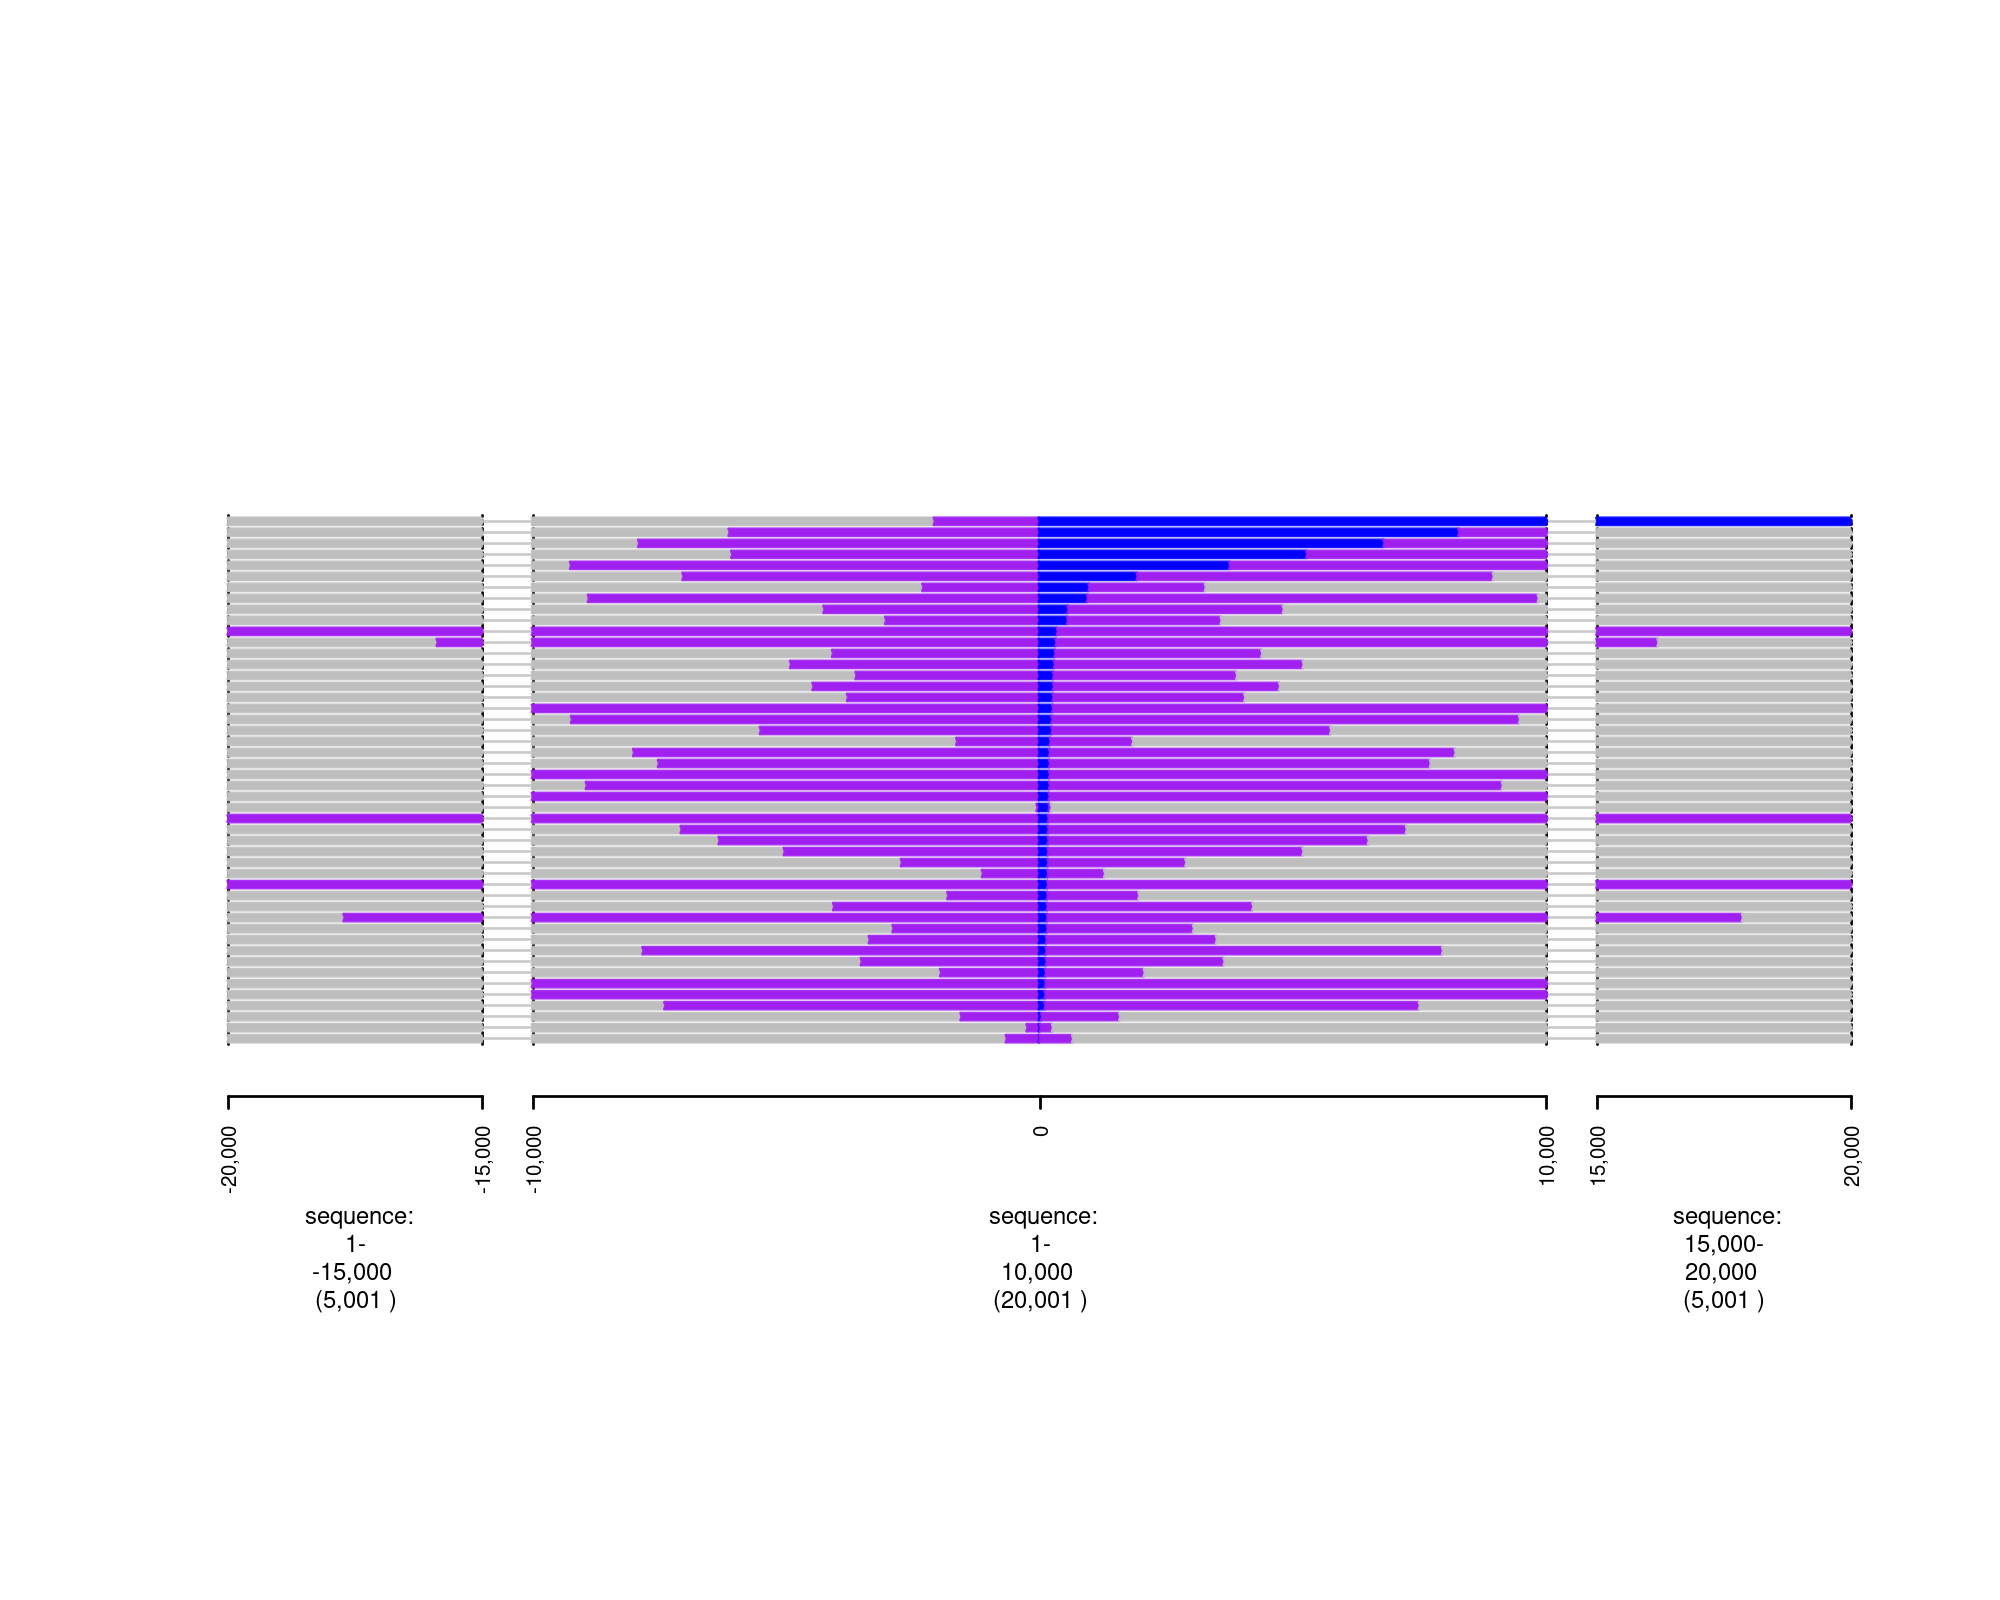

In [433]:
options(repr.plot.height = 8, repr.plot.width = 10)
suppressWarnings(plot(gt, windows))

### cis walk histogram

In [227]:
pt.dt = rbind(supported.walks.dt[(locus1), .(width, locus = "locus1")],
              supported.walks.dt[(locus2), .(width, locus = "locus2")])

pt = ggplot(pt.dt, aes(x = width, y = locus, fill = locus)) +
geom_density_ridges(alpha = 0.8, bandwidth = 0.1) +
scale_x_continuous(trans = "log10", limits = c(10, 1e5)) +
ggpubr::theme_pubr() +
labs(title = "cis rDups", x = "width (bp)", y = "locus") +
theme(legend.position = "none")

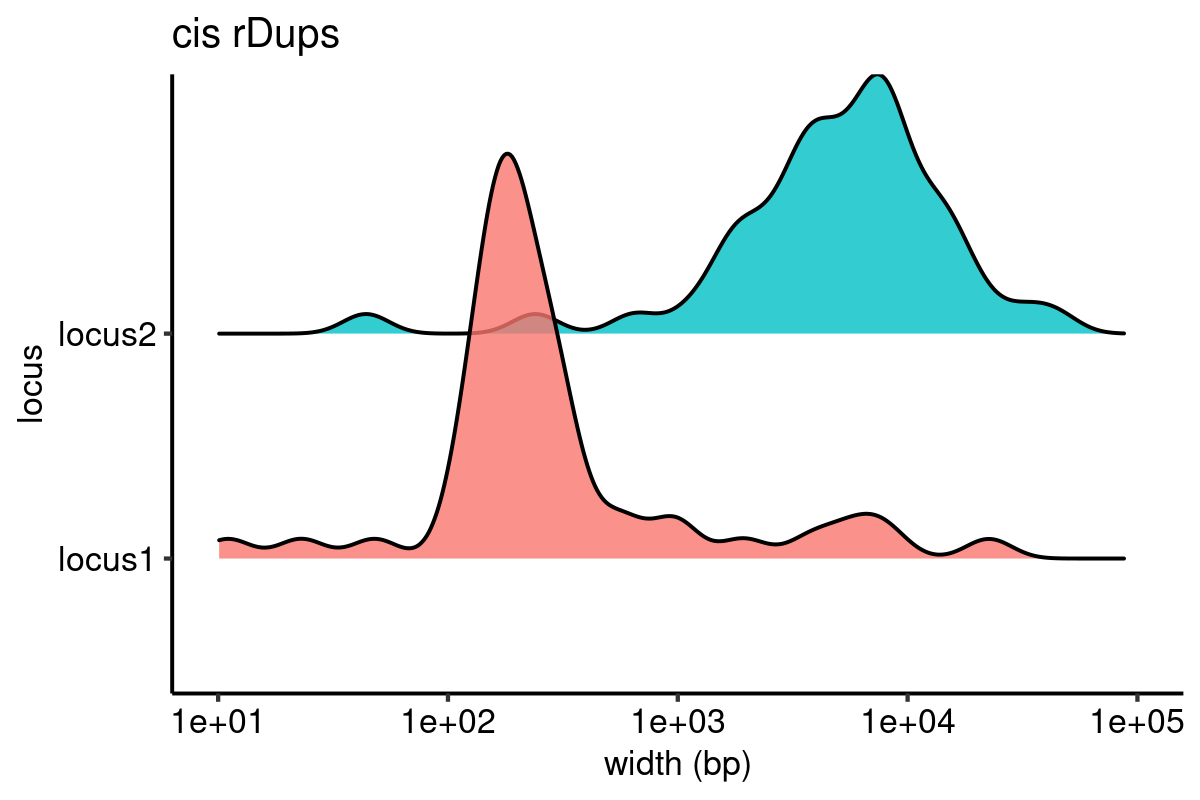

In [228]:
options(repr.plot.height = 4, repr.plot.width = 6)
pt

### trans walks

In [229]:
## get all cis or trans phased edge clusters corresponding with rDups
trans.clusters.dt = phasing.barcode.counts.dt[(phase == "trans")]

In [230]:
## get all cis or trans phased edge clusters corresponding with rDups
setkeyv(all.walks.dt, c("ecluster", "sample"))
setkeyv(trans.clusters.dt, c("ecluster", "sample"))
trans.walks.dt = trans.clusters.dt[all.walks.dt[orientation == "trans"]]

## subset for the supported cis walk
supported.walks.dt = trans.walks.dt[!is.na(nbx)][, max.nbx := max(nbx), by = .(ecluster, sample)][(nbx == max.nbx)][nbx > 0]

## check for ALT edges
supported.walks.dt[, previous.walk.id := data.table::shift(walk.id)]
supported.walks.dt[, previous.sample := data.table::shift(sample)]
supported.walks.dt[, previous.ecluster := data.table::shift(ecluster)]
supported.walks.dt[, previous.start := data.table::shift(start)]
supported.walks.dt[, previous.end := data.table::shift(end)]

## strand needs to go from fct --> char
supported.walks.dt[, strand := as.character(strand)]
supported.walks.dt[, previous.strand := data.table::shift(strand)]

supported.walks.dt[(strand == "+") & 
                   (walk.id == previous.walk.id & sample == previous.sample & ecluster == previous.ecluster) & 
                   (start != previous.end + 1 | strand != previous.strand), gap := TRUE]
supported.walks.dt[(strand == "-") & 
                   (walk.id == previous.walk.id & sample == previous.sample & ecluster == previous.ecluster) & 
                   (end != previous.start - 1 | strand != previous.strand), gap := TRUE]

supported.walks.dt[is.na(gap), gap := FALSE]

supported.walks.dt[, cumulative.gaps := cumsum(x = gap), by = .(sample, ecluster, walk.id)]


supported.walks.dt[, ":="(locus1 = gap & cumulative.gaps == 1)]
supported.walks.dt[, next.locus1 := data.table::shift(locus1, -1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[is.na(next.locus1), next.locus1 := FALSE]
supported.walks.dt[, ":="(locus2 = next.locus1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[, flank := !(locus1 | locus2)]
trans.rdups.dt = supported.walks.dt

In [231]:
## create spChains
trans.rdups.gr = dt2gr(trans.rdups.dt, seqlengths = hg_seqlengths())
trans.rdups.grl = GenomicRanges::split(trans.rdups.gr, ~ trans.rdups.dt[, paste(ecluster, sample, walk.id)])

spc = gChain::spChain(trans.rdups.grl)
lifted.dt = as.data.table(spc@.galy)
lifted.dt[, seqnames := "sequence"]
lifted.gr = dt2gr(lifted.dt)
values(lifted.gr) = values(stack(trans.rdups.grl))

## get the amount that each range should be shifted
lifted.dt = as.data.table(lifted.gr)
lifted.dt[, shift.bp := .SD[(locus1), start], by = .(ecluster, sample, walk.id)]
lifted.dt[, insert.width := .SD[(locus1), width], by = .(ecluster, sample, walk.id)]
lifted.dt[, other.width := .SD[(locus2), sum(width)], by = .(ecluster, sample, walk.id)]
lifted.dt[, col := ifelse(flank, "gray", ifelse(locus1, "blue", "purple"))]
lifted.dt[, nm := paste(ecluster, sample, walk.id)]

## shift the ranges
shifted.gr = GenomicRanges::shift(lifted.gr, shift = -lifted.dt[, shift.bp])
values(shifted.gr)[, "insert.width"] = lifted.dt[, insert.width]
values(shifted.gr)[, "other.width"] = lifted.dt[, other.width]
values(shifted.gr)[, "col"] = lifted.dt[, col]
values(shifted.gr)[, "nm"] = lifted.dt[, nm]

## get a range for the order
order.lifted.dt = unique(lifted.dt, by = "nm") %>% setkey(nm)

shifted.grl = GenomicRanges::split(shifted.gr, values(shifted.gr)[, "nm"])
values(shifted.grl) = order.lifted.dt[names(shifted.grl)][, .(insert.width, other.width)]
shifted.grl = shifted.grl %Q% (order(insert.width))

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 120 out-of-bound ranges located on sequence
  sequence. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 120 out-of-bound ranges located on sequence
  sequence. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”


In [232]:
gt = gTrack(shifted.grl, stack.gap = 0, labels.suppress.grl = TRUE)

windows = GRanges(seqnames = "sequence",
                 ranges = IRanges(start = c(-2e4, -1e4, 1.5e4),
                                 end = c(-1.5e4, 1e4, 2e4)))



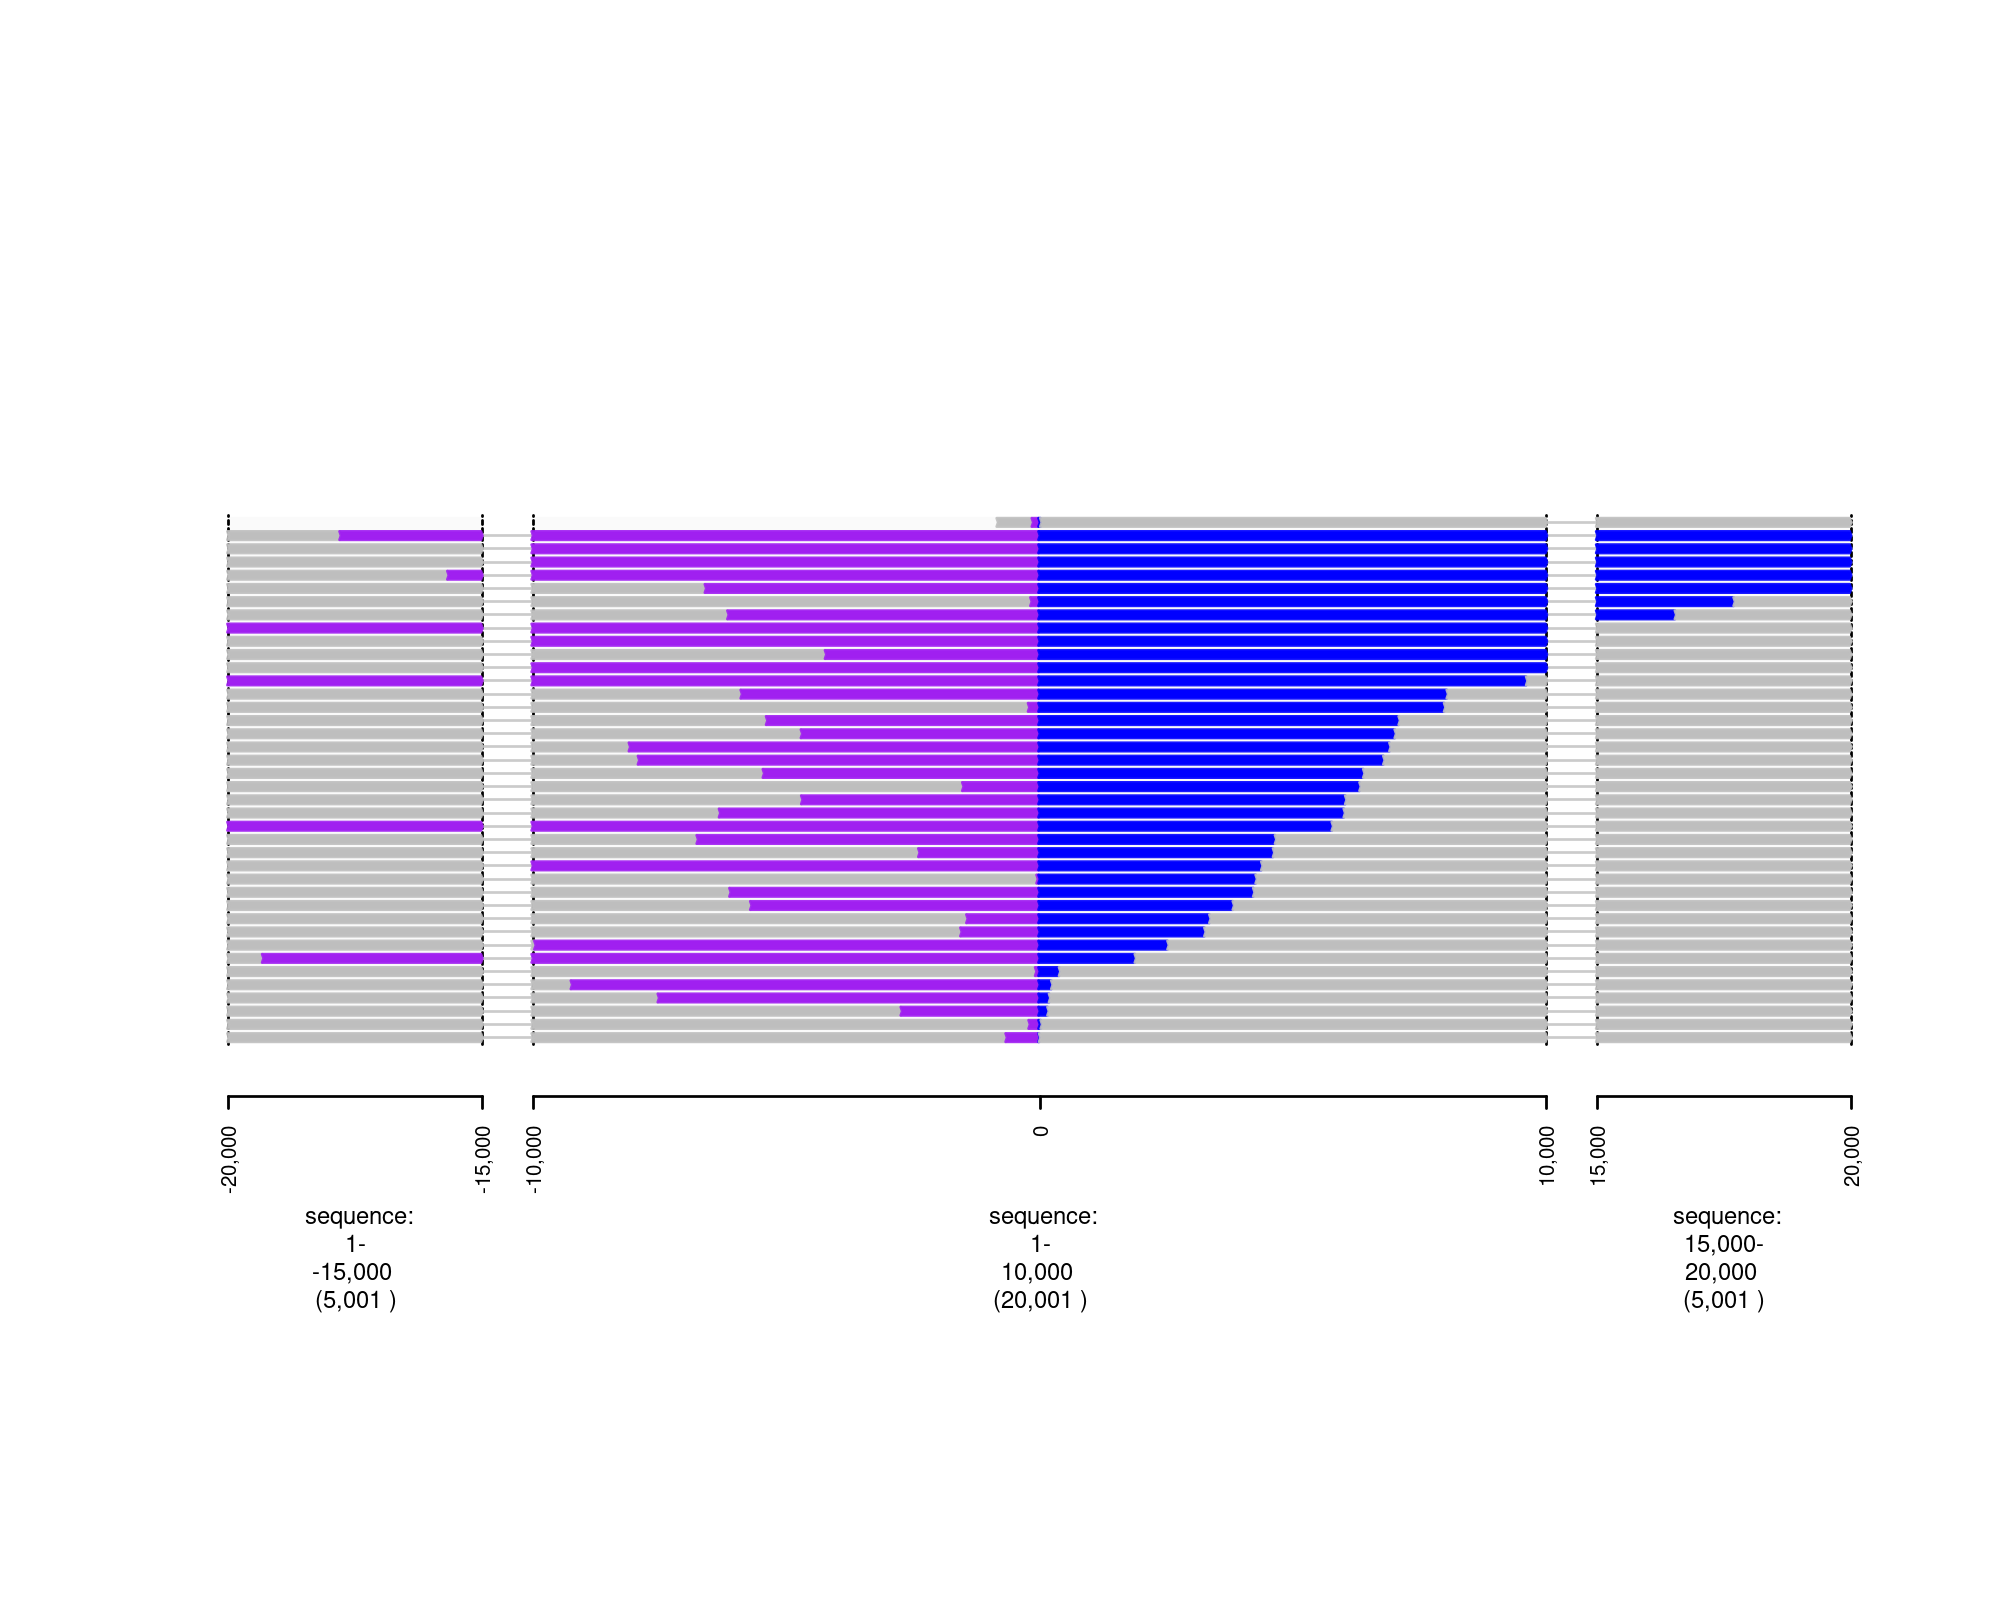

In [233]:
options(repr.plot.height = 8, repr.plot.width = 10)
suppressWarnings(plot(gt, windows))

### trans walk histogram

In [234]:
pt.dt = rbind(supported.walks.dt[(locus1), .(width, locus = "locus1")],
              supported.walks.dt[(locus2), .(width, locus = "locus2")])

pt = ggplot(pt.dt, aes(x = width, y = locus, fill = locus)) +
geom_density_ridges(alpha = 0.8, bandwidth = 0.1) +
scale_x_continuous(trans = "log10", limits = c(10, 1e5)) +
ggpubr::theme_pubr() +
labs(title = "trans rDups", x = "width (bp)", y = "locus") +
theme(legend.position = "none")

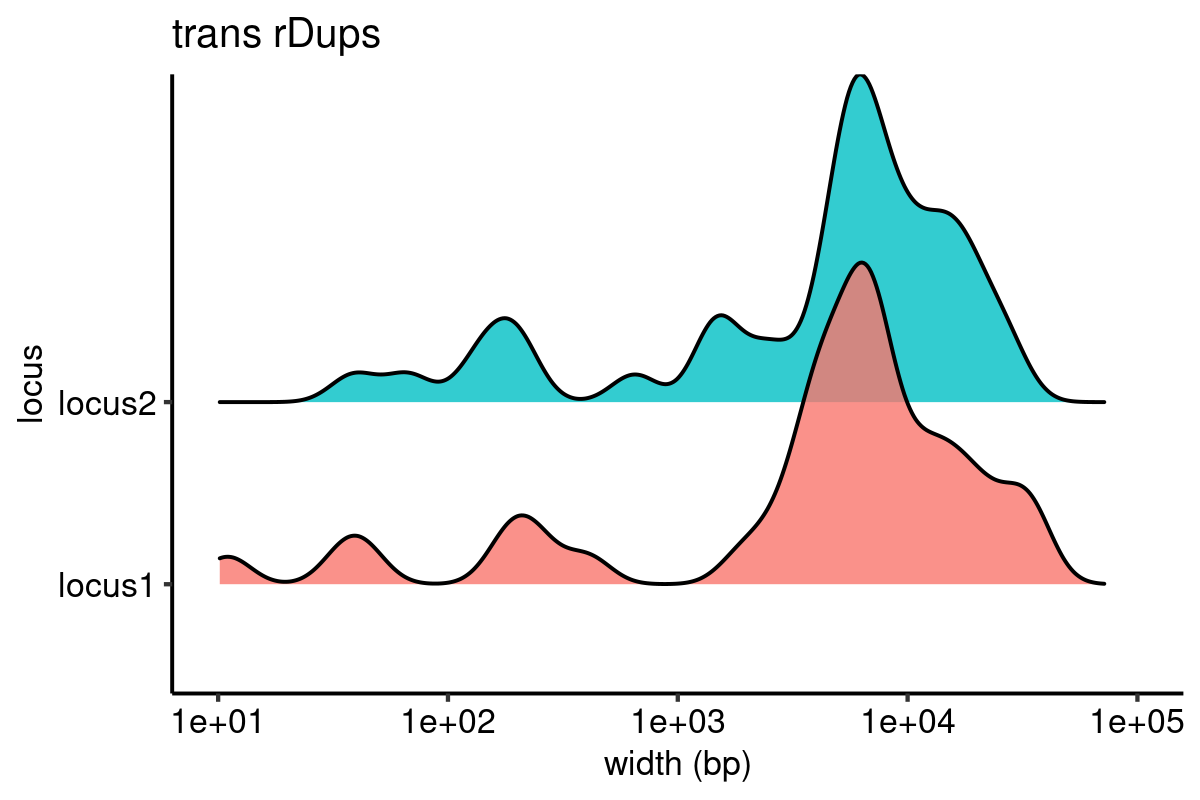

In [235]:
options(repr.plot.height = 4, repr.plot.width = 6)
pt

## Figure 3b

Scatter plot of gap lengths for each rDup among BRCA1d (n = 46) and BRCA2d (n = 50) BOPP cases. The shorter and longer gap segments in each pair are plotted on the x and y axes respectively.

In [261]:
events.dt = readRDS("./data/revision.events.dt.rds") 
phasing.barcode.counts.dt = readRDS("./data/phasing/phasing.barcode.counts.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

## the job generating these barcode counts is here: 
## basically the phasing.barcode.counts.dt just stacks the outputs of phase_dt
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221102_re/qrp_phasing.rds")
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221107_re_re/qrp_phasing.rds")

In [265]:
## get all supported cis walks from barcode counts
phasing.barcode.counts.dt[, phase := ifelse(cis > trans * 3 & cis >= 3, "cis",
                                            ifelse(trans > cis * 3 & trans >= 3, "trans", "unphased"))]

In [266]:
head(phasing.barcode.counts.dt)

ecluster cis trans sample phase   
1 1          0  1    10     unphased
2 2         50  0    10     cis     
3 5         34  0    10     cis     
4 6          1 14    10     trans   
5 7        204  0    10     cis     
6 8          0 49    10     trans

In [267]:
## put the big gap and small gap
qrp.events.dt = events.dt[(hrd_tbl[sample, aug_bopp_cohort])][(type == "qrppos")]
qrp.events.dt[, ":="(big.gap = log10(pmax(width.l1, width.l2)))]
qrp.events.dt[, ":="(small.gap = log10(pmin(width.l1, width.l2)))]


setkeyv(phasing.barcode.counts.dt, c("sample", "ecluster"))
setkeyv(qrp.events.dt, c("sample", "ecluster"))
qrp.events.dt[, lrs_phase := phasing.barcode.counts.dt[qrp.events.dt[, .(sample, ecluster)], phase]]
qrp.events.dt[is.na(lrs_phase), lrs_phase := "short read WGS"]
qrp.events.dt[(big.gap) > log10(5e4) & (lrs_phase == "cis" | lrs_phase == "trans"), lrs_phase := "unphased"]

color.map = c("cis" = alpha("red", 1),
             "trans" = alpha("blue", 1),
             "unphased" = alpha("purple", 1),
             "short read WGS" = alpha("gray", 0.1))

qrp.events.dt[, col := color.map[lrs_phase]]

Plot a version keeping unphased

In [268]:
pt = ggplot(qrp.events.dt, aes(x = small.gap, y = big.gap, color = lrs_phase)) +
geom_point() +
scale_color_manual(values = color.map) +
ggpubr::theme_pubr() +
labs(x = "small gap", y = "big gap", title = "rDup") +
theme(legend.position = "right")

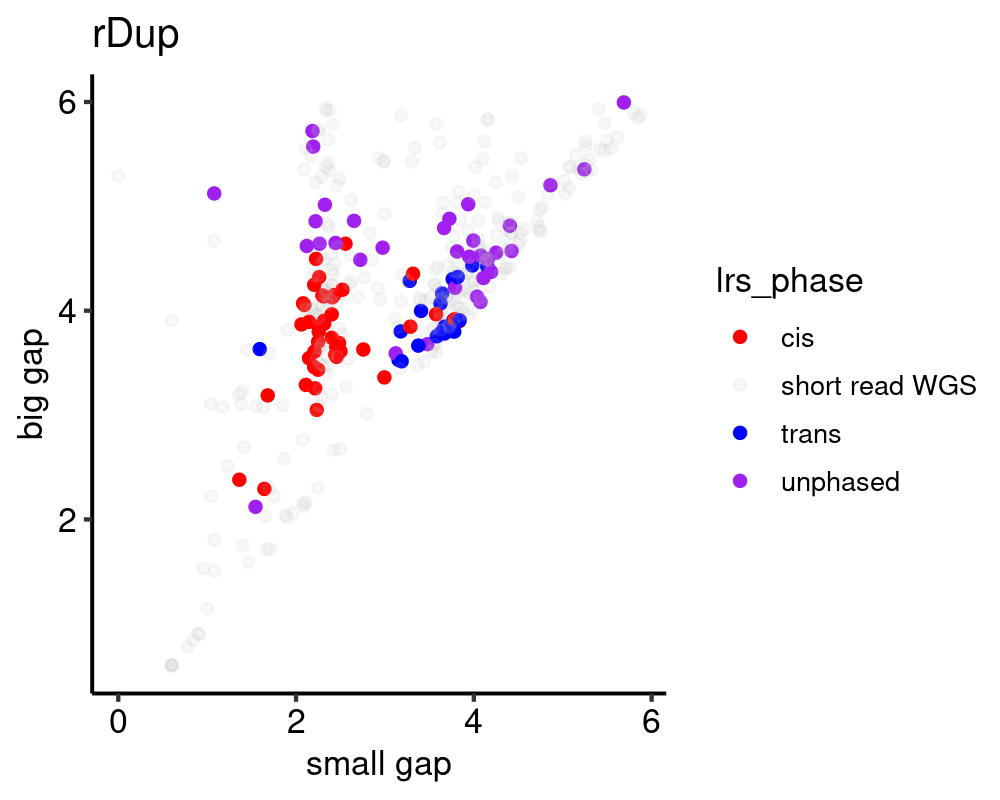

In [269]:
options(repr.plot.height = 4, repr.plot.width = 5)
pt

Plot a version that removes unphased

In [270]:
color.map = c("cis" = alpha("red", 1),
             "trans" = alpha("blue", 1),
             "unphased" = alpha("gray", 0.1),
             "short read WGS" = alpha("gray", 0.1))

pt = ggplot(qrp.events.dt, aes(x = small.gap, y = big.gap, color = lrs_phase)) +
geom_point() +
scale_color_manual(values = color.map) +
ggpubr::theme_pubr() +
labs(x = "small gap", y = "big gap", title = "rDup") +
theme(legend.position = "right")

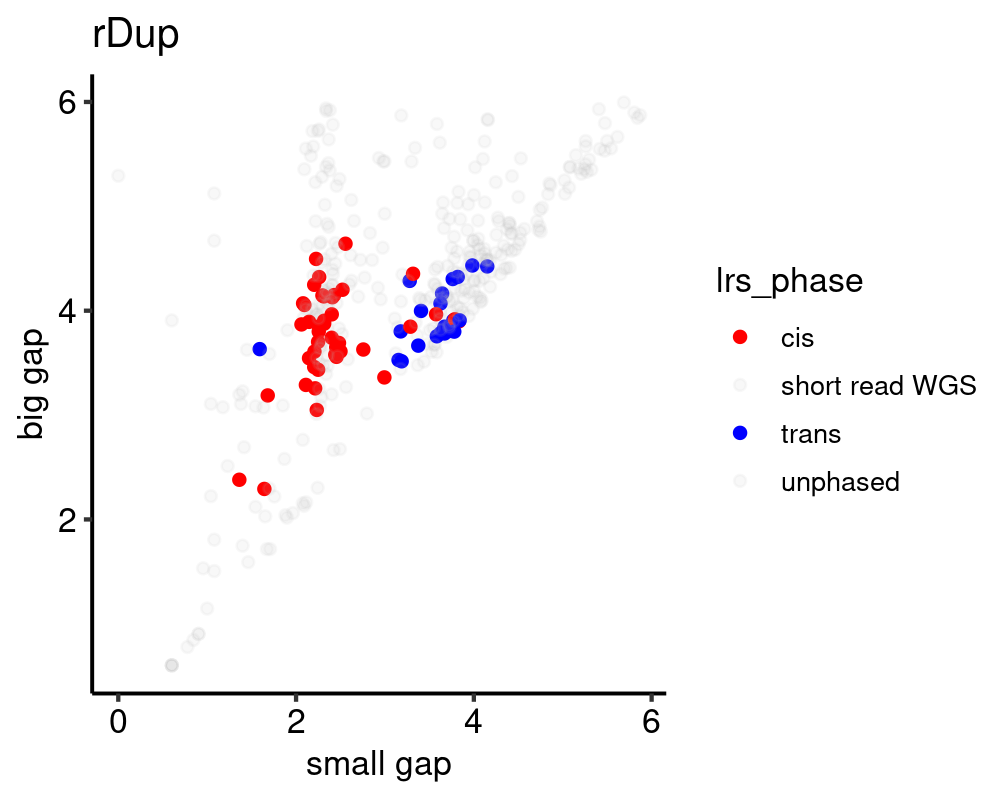

In [271]:
options(repr.plot.height = 4, repr.plot.width = 5)
pt

## Figure 3d
Fraction of Type I and Type II orientations among observed LR-WGS and imputed short read WGS cis and trans reciprocal pairs. P values obtained by Fisher’s Exact Test. 

In [278]:
events.dt = readRDS("./data/revision.events.dt.rds") 
phasing.barcode.counts.dt = readRDS("./data/phasing/phasing.barcode.counts.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

## the job generating these barcode counts is here: 
## basically the phasing.barcode.counts.dt just stacks the outputs of phase_dt
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221102_re/qrp_phasing.rds")
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221107_re_re/qrp_phasing.rds")

In [279]:
## get all supported cis walks from barcode counts
phasing.barcode.counts.dt[, phase := ifelse(cis > trans * 3 & cis > 3, "cis", 
                                            ifelse(trans > cis * 3 & trans > 3,"trans","unphased"))]
phasing.barcode.counts.dt[is.na(phase), phase := "unphased"]

## put the big gap and small gap
qrp.events.dt = events.dt[(hrd_tbl[sample, aug_bopp_cohort] | sample %in% phasing.barcode.counts.dt$sample) & 
                          (type == "qrppos" | type == "qrpmix" | type == "qrpmin") &
                          (hrd_tbl[sample, fmut_bi] %in% c("BRCA1", "BRCA2")) &
                          (seqnames.l1 %in% c(as.character(1:22), "X", "Y")) & 
                          (seqnames.l2 %in% c(as.character(1:22), "X", "Y"))]

## add type2 boolean column
qrp.events.dt[, type2 := bias_type == "type2"]

## gap size
qrp.events.dt[(type == "qrppos"), gap.size := log10(pmin(width.l1, width.l2))]
qrp.events.dt[(type == "qrpmix"), gap.size := ifelse(strand.l1 == "+", log10(width.l1), log10(width.l2))]
qrp.events.dt[(type == "qrpmin"), gap.size := Inf]

## add annotations
setkeyv(phasing.barcode.counts.dt, c("sample", "ecluster"))
setkeyv(qrp.events.dt, c("sample", "ecluster"))
qrp.events.dt[, lrs_phase := phasing.barcode.counts.dt[qrp.events.dt[, .(sample, ecluster)], phase]]
##qrp.events.dt[(gap.size < 3) & (lrs_phase == "unphased") , lrs_phase := "cis"]
##qrp.events.dt[(gap.size > 3.5) & (lrs_phase == "unphased") , lrs_phase := "trans"]

## add imputed phase
qrp.events.dt[, imputed_phase := ifelse(gap.size >= 3.5, "trans", "cis")]

### Left panel: Type II fraction among LRS phased events

In [280]:
## type 2 by LRS
lrs.pt.dt = qrp.events.dt[(lrs_phase %in% c("cis", "trans")), 
                          .(num_type = .N),
                         by = .(lrs_phase, bias_type)]

lrs.pt.dt[, total := sum(num_type), by = lrs_phase]

lrs.pt.dt[, ci.lower := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.lower}, num_type, total) %>% unlist] 
lrs.pt.dt[, ci.upper := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.upper}, num_type, total) %>% unlist]
lrs.pt.dt[, frac := num_type / total]

In [281]:
##library(ggplot2)
pt = ggplot(lrs.pt.dt, aes(x = lrs_phase, y = frac, fill = bias_type)) +
geom_bar(stat = "identity", position = "dodge") +
geom_errorbar(aes(ymin = ci.lower, ymax = ci.upper), width = 0.2, position = position_dodge(width = 0.9))+
ggpubr::theme_pubr() +
geom_hline(yintercept = 0.5) +
labs(x = "LRS phase", y = "fraction of events", title = "Type II events")

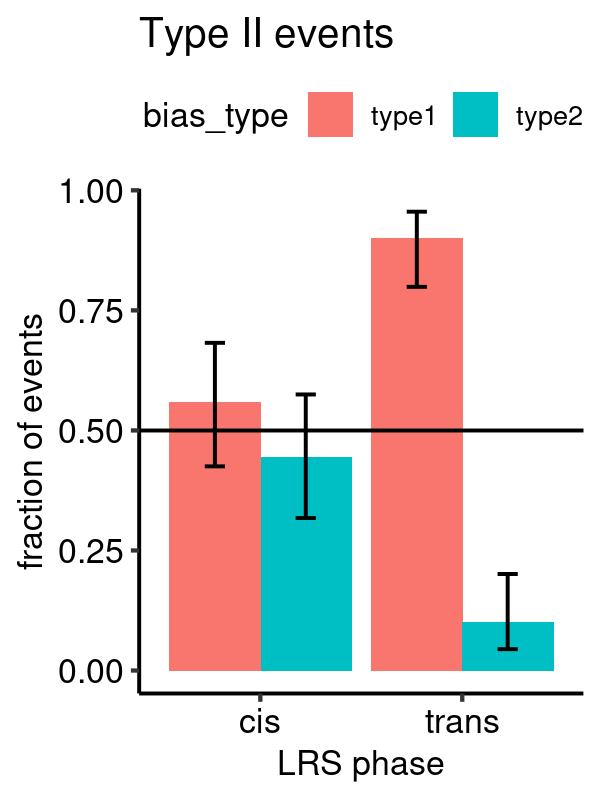

In [282]:
options(repr.plot.height = 4, repr.plot.width = 3)
pt

In [283]:
qrp.events.dt[(lrs_phase %in% c("cis", "trans")), fisher.test(lrs_phase, !type2)]


	Fisher's Exact Test for Count Data

data:  lrs_phase and !type2
p-value = 8.344e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  2.643626 21.199752
sample estimates:
odds ratio 
   7.03351 


### Type II events by imputed phase

In [284]:
## type 2 by LRS
srs.pt.dt = qrp.events.dt[(imputed_phase %in% c("cis", "trans")), 
                          .(num_type = .N),
                         by = .(imputed_phase, bias_type)]

srs.pt.dt[, total := sum(num_type), by = imputed_phase]

srs.pt.dt[, ci.lower := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.lower}, num_type, total) %>% unlist] 
srs.pt.dt[, ci.upper := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.upper}, num_type, total) %>% unlist]
srs.pt.dt[, frac := num_type / total]

In [285]:
pt = ggplot(srs.pt.dt, aes(x = imputed_phase, y = frac, fill = bias_type)) +
geom_bar(stat = "identity", position = "dodge") +
geom_errorbar(aes(ymin = ci.lower, ymax = ci.upper), width = 0.2, position = position_dodge(width = 0.9))+
ggpubr::theme_pubr() +
geom_hline(yintercept = 0.5) +
labs(x = "Imputed phase", y = "fraction of events", title = "Type II events")

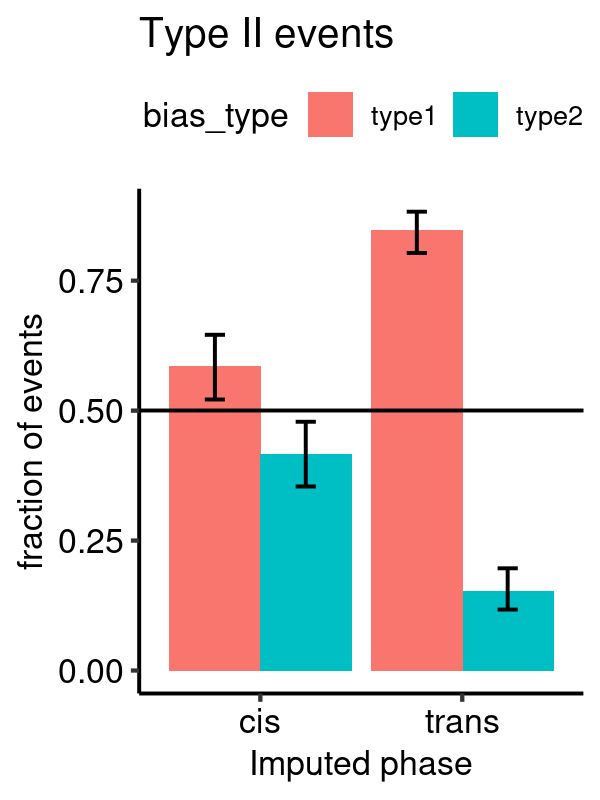

In [286]:
options(repr.plot.height = 4, repr.plot.width = 3)
pt

In [287]:
qrp.events.dt[(imputed_phase %in% c("cis", "trans")), fisher.test(imputed_phase, !type2)]


	Fisher's Exact Test for Count Data

data:  imputed_phase and !type2
p-value = 1.475e-12
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 2.623985 5.908408
sample estimates:
odds ratio 
  3.919526 


## Figure 3f
LOH length distributions plotted alongside gap segment-to-telomere and gap segment-to-gap segment lengths for inter- and intra-chromosomal reciprocal pairs, respectively, among BRCA1d (n = 46) and BRCA2d (n = 50) BOPP cases.

In [297]:
events.dt = readRDS("./data/revision.events.dt.rds") 
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
loh.dt = readRDS("./data/phasing/revision.loh.dt.rds")[hrd_tbl[sample, fmut_bi] %in% c("BRCA1", "BRCA2")]
centr = readRDS("./data/phasing/hg19.centromeres.rds")

In [298]:
 ## calculate interstital distance
qrp.events.dt = events.dt[(type %like% "qrp") &
                         (hrd_tbl[sample, (aug_bopp_cohort)])]

## add imputed phase
qrp.events.dt[(type == "qrppos"), gap.size := log10(pmin(width.l1, width.l2))]
qrp.events.dt[(type == "qrpmix"), gap.size := ifelse(strand.l1 == "+", log10(width.l1), log10(width.l2))]
qrp.events.dt[(type == "qrpmin"), gap.size := Inf]
qrp.events.dt[, imputed_phase := ifelse(gap.size >= 3.5, "trans", "cis")]

## add interstitial distance
qrp.events.dt[, interstitial.distance := ifelse(seqnames.l1 == seqnames.l2,
                                                pmin(abs(start.l1 - start.l2),
                                                     abs(start.l1 - end.l2),
                                                     abs(end.l1 - start.l2),
                                                     abs(end.l1 - end.l2)),
                                                NA)]

## calculate telomeric distance
sl = gUtils::hg_seqlengths()

centr[, seqnames := as.character(seqnames)]

setkey(centr, "seqnames")

qrp.events.dt[, telomeric.distance.l1 := ifelse(seqnames.l1 != seqnames.l2,
                                                ifelse(start.l1 < centr[as.character(seqnames.l1), start],
                                                       start.l1,
                                                       sl[as.character(seqnames.l1)] - end.l1 + 1),
                                                NA)]

qrp.events.dt[, telomeric.distance.l2 := ifelse(seqnames.l1 != seqnames.l2,
                                                ifelse(start.l2 < centr[as.character(seqnames.l2), start],
                                                       start.l2,
                                                       sl[as.character(seqnames.l2)] - end.l2 + 1),
                                                NA)]

In [302]:
 ## make ridge plot
pt.dt = rbind(loh.dt[(telomeric), .(type = "telomeric loh", width)],
              qrp.events.dt[!is.na(telomeric.distance.l1) &
                            (imputed_phase == "trans" | imputed_phase == "trans") &
                            (hrd_tbl[sample, fmut_bi %in% c("BRCA1", "BRCA2")]),
                            .(type = "interchromosomal event",
                              width = telomeric.distance.l1)],
              qrp.events.dt[!is.na(telomeric.distance.l2) &
                            (imputed_phase == "trans" | imputed_phase == "trans") &
                            (hrd_tbl[sample, fmut_bi %in% c("BRCA1", "BRCA2")]),
                            .(type = "interchromosomal event",
                              width = telomeric.distance.l2)],
              loh.dt[(!telomeric), .(type = "interstitial loh", width)],
              qrp.events.dt[!is.na(interstitial.distance) & 
                            (imputed_phase == "trans" | imputed_phase == "trans") & 
                            (hrd_tbl[sample, fmut_bi %in% c("BRCA1", "BRCA2")]),
                            .(type = "intrachromosomal event",
                              width = interstitial.distance)])

pt.dt[, type_factor := ordered(type, levels = c("intrachromosomal event",
                                                "interstitial loh",
                                                "interchromosomal event",
                                                "telomeric loh"))]

In [303]:
library(ggridges) 

# basic example
pt = ggplot(pt.dt, aes(x = width, y = type_factor, fill = type_factor)) +
geom_density_ridges(alpha = 0.8, bandwidth = 0.3) +
scale_x_continuous(trans = "log10") +
ggpubr::theme_pubr() +
labs(x = "width (log10 bp)", y = "event type") +
theme(legend.position = "none")

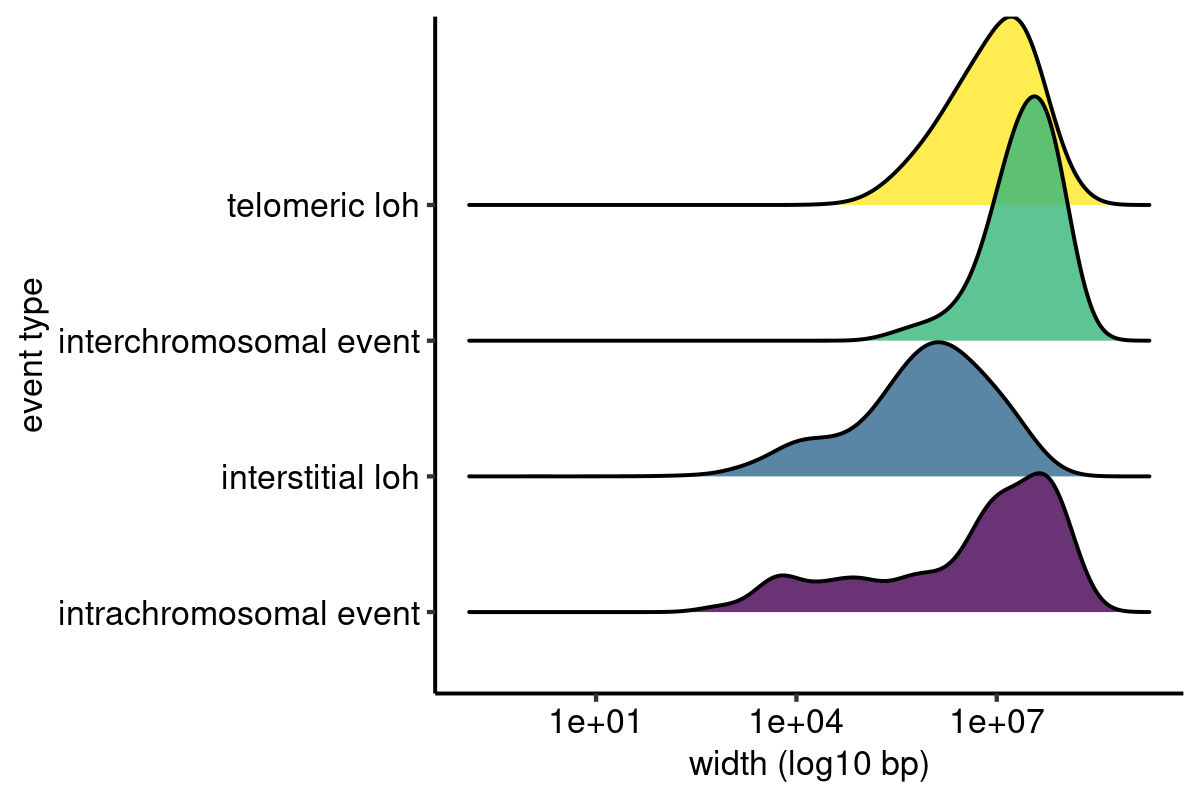

In [304]:
options(repr.plot.height = 4, repr.plot.width = 6)
pt

# Extended data figure 4

## EDF4a
Accuracy of phasing algorithm across simulated LR data sampled from cis or trans allelic configurations of observed rDel, rDelDup, and rDel loci.

In [313]:
goodcalls = readRDS("./data/phasing/lrs.phasing.simulation.calls.dt.rds")

In [314]:
bp.dt = goodcalls[, .(n_correct = .N), by = .(qrp, correct_call)][, total := sum(n_correct), by = qrp]
bp.dt[, ci.lower := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.lower}, n_correct, total) %>% unlist]
bp.dt[, ci.upper := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.upper}, n_correct, total) %>% unlist] 
bp.dt[, frac := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$estimate}, n_correct, total) %>% unlist]

In [315]:
pt = ggplot(bp.dt[(correct_call)], aes(x = qrp, y = frac)) +
geom_bar(stat = "identity") +
geom_errorbar(aes(ymin = ci.lower, ymax = ci.upper), width = 0.1) +
ylim(0, 1) +
ggpubr::theme_pubr() +
labs(x = "qrp type", y = "fraction of events", title = "correct calls") 

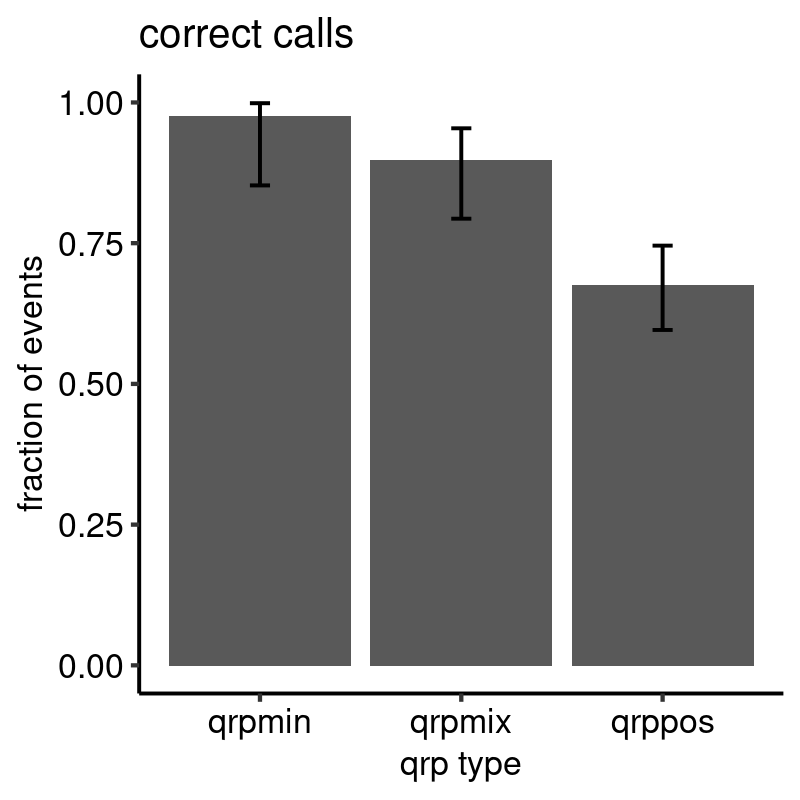

In [316]:
options(repr.plot.height = 4, repr.plot.width = 4)
print(pt)

## EDF4b
Number of LR barcodes supporting cis vs trans configuration for each of the 186 reciprocal pair loci observed across 46 tumors profiled with LR WGS.

In [317]:
events.dt = readRDS("./data/revision.events.dt.rds") 
phasing.barcode.counts.dt = readRDS("./data/phasing/phasing.barcode.counts.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

In [318]:
## pick out only the qrps
pt.dt = merge.data.table(phasing.barcode.counts.dt,
                        events.dt[, .(sample, ecluster, type, footprint)],
                        by = c("sample", "ecluster"))

pt = ggplot(pt.dt, aes(x = cis, y = trans)) +
geom_point() +
xlim(0, 400) +
ylim(0, 400) +
ggpubr::theme_pubr() +
labs(x = "cis BX", y = "trans BX", title = "walk-supporting BX counts")

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


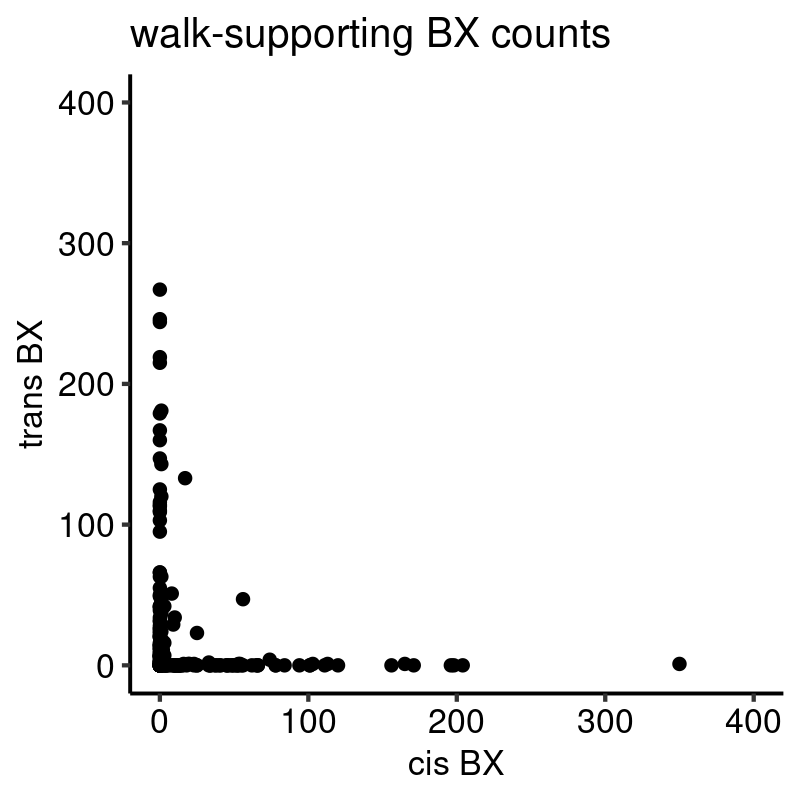

In [319]:
options(repr.plot.height = 4, repr.plot.width = 4)
pt

# Extended data figure 5
## EDF5a
The (+) gap segment lengths of cis and trans phased haplotypes

In [320]:
events.dt = readRDS("./data/revision.events.dt.rds") 
phasing.barcode.counts.dt = readRDS("./data/phasing/phasing.barcode.counts.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

## the job generating these barcode counts is here: 
## basically the phasing.barcode.counts.dt just stacks the outputs of phase_dt
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221102_re/qrp_phasing.rds")
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221107_re_re/qrp_phasing.rds")

In [321]:
## get all supported cis walks from barcode counts
phasing.barcode.counts.dt[(cis > 0 | trans > 0), 
                          phase := ifelse(cis > trans * 3,
                                          "cis", 
                                          ifelse(trans > cis * 3, "trans", "unphased"))]

The following two cells can be skipped!

In [322]:
## get a list of walk objects and collapse them
all.walks = lapply(stats::setNames(nm = Flow::outputs(qrp.phasing.jb)[file.exists(qrp_walks_rds), pair]),
                   function(pr, tbl) {
                       wks = readRDS(tbl[pr, qrp_walks_rds])
                       gr = stack(wks$grl)
                       if (length(wks)) {
                           values(gr)[, "sample"] = pr
                       }
                       return(gr)
                   },
                   Flow::outputs(qrp.phasing.jb))

## stack all walks into GRanges and select only the desired walks
all.walks.gr = gUtils::grbind(unlist(all.walks))

## only keep the circular positive walks
all.walks.dt = as.data.table(all.walks.gr)

In [323]:
## label gaps and indicate which gap is G1 or G2
## to do this we have to first get the footprints of the rDup events
## qrp.events.dt = readRDS("~/projects/Starr/BRCA/db/revision.events.dt.rds")[type == "qrppos"] 
qrp.events.dt = readRDS("~/projects/Starr/BRCA/db/revision.events.dt.rds")[type == "qrpmix"] 
qrp.events.grl = qrp.events.dt[, parse.grl(footprint)]
values(qrp.events.grl)[, "ecluster"] = qrp.events.dt[, ecluster]
values(qrp.events.grl)[, "sample"] = qrp.events.dt[, sample]
qrp.events.dt[, pos.gap := ifelse(strand.l1 == "+", width.l1, width.l2)]

all.walks.dt = merge.data.table(all.walks.dt, qrp.events.dt[pos.gap < 5e4, .(sample, ecluster, width.l1, width.l2)],
                                by = c("ecluster", "sample"))

In [434]:
## start here!!
all.walks.dt = readRDS("./data/phasing/all.walks.dt.rds")
all.walks.gr = readRDS("./data/phasing/all.walks.gr.rds")

In [435]:
## get all cis or trans phased edge clusters corresponding with rDups
cis.clusters.dt = phasing.barcode.counts.dt[(phase == "cis")]
setkeyv(all.walks.dt, c("ecluster", "sample"))
setkeyv(cis.clusters.dt, c("ecluster", "sample"))
cis.walks.dt = cis.clusters.dt[all.walks.dt[orientation == "cis"]][!is.na(width.l1)][!is.na(width.l2)][phase == "cis"]

## subset for the supported cis walk
supported.walks.dt = cis.walks.dt[!is.na(nbx)][, max.nbx := max(nbx), by = .(ecluster, sample)][(nbx == max.nbx)][nbx > 0]

## check for ALT edges
supported.walks.dt[, previous.walk.id := data.table::shift(walk.id)]
supported.walks.dt[, previous.sample := data.table::shift(sample)]
supported.walks.dt[, previous.ecluster := data.table::shift(ecluster)]
supported.walks.dt[, previous.start := data.table::shift(start)]
supported.walks.dt[, previous.end := data.table::shift(end)]

## strand needs to go from fct --> char
supported.walks.dt[, strand := as.character(strand)]
supported.walks.dt[, previous.strand := data.table::shift(strand)]

supported.walks.dt[(strand == "+") & 
                   (walk.id == previous.walk.id & sample == previous.sample & ecluster == previous.ecluster) & 
                   (start != previous.end + 1 | strand != previous.strand), gap := TRUE]
supported.walks.dt[(strand == "-") & 
                   (walk.id == previous.walk.id & sample == previous.sample & ecluster == previous.ecluster) & 
                   (end != previous.start - 1 | strand != previous.strand), gap := TRUE]

supported.walks.dt[is.na(gap), gap := FALSE]

supported.walks.dt[, cumulative.gaps := cumsum(x = gap), by = .(sample, ecluster, walk.id)]

supported.walks.dt[, ":="(locus1 = gap & cumulative.gaps == 1)]
supported.walks.dt[, next.locus1 := data.table::shift(locus1, n = -1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[is.na(next.locus1), next.locus1 := FALSE]
supported.walks.dt[, previous.locus1 := data.table::shift(locus1, n = 1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[is.na(previous.locus1), previous.locus1 := FALSE]
supported.walks.dt[, ":="(locus2 = previous.locus1 | next.locus1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[, flank := !(locus1 | locus2)]

In [436]:
cis.rdups.dt = supported.walks.dt

## create spChains
cis.rdups.gr = dt2gr(cis.rdups.dt, seqlengths = hg_seqlengths())
cis.rdups.grl = GenomicRanges::split(cis.rdups.gr, ~ cis.rdups.dt[, paste(ecluster, sample, walk.id)])

spc = gChain::spChain(cis.rdups.grl)
lifted.dt = as.data.table(spc@.galy)
lifted.dt[, seqnames := "sequence"]
lifted.gr = dt2gr(lifted.dt)
values(lifted.gr) = values(stack(cis.rdups.grl))

## get the amount that each range should be shifted
lifted.dt = as.data.table(lifted.gr)
lifted.dt[, shift.bp := .SD[(locus1), start], by = .(ecluster, sample, walk.id)]
lifted.dt[, insert.width := .SD[(locus1), width], by = .(ecluster, sample, walk.id)]
lifted.dt[, other.width := .SD[(locus2), sum(width)], by = .(ecluster, sample, walk.id)]
lifted.dt[, col := ifelse(flank, "gray", ifelse(locus1, "blue", "gray"))]
lifted.dt[, nm := paste(ecluster, sample, walk.id)]

## shift the ranges
shifted.gr = GenomicRanges::shift(lifted.gr, shift = -lifted.dt[, shift.bp])
values(shifted.gr)[, "insert.width"] = lifted.dt[, insert.width]
values(shifted.gr)[, "other.width"] = lifted.dt[, other.width]
values(shifted.gr)[, "col"] = lifted.dt[, col]
values(shifted.gr)[, "nm"] = lifted.dt[, nm]

## get a range for the order
order.lifted.dt = unique(lifted.dt, by = "nm") %>% setkey(nm)

shifted.grl = GenomicRanges::split(shifted.gr, values(shifted.gr)[, "nm"])
values(shifted.grl) = order.lifted.dt[names(shifted.grl)][, .(insert.width, other.width)]
shifted.grl = shifted.grl %Q% (order(insert.width, other.width))

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 144 out-of-bound ranges located on sequence
  sequence. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 144 out-of-bound ranges located on sequence
  sequence. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”


In [437]:
gt = gTrack(shifted.grl, stack.gap = 0, labels.suppress.grl = TRUE)

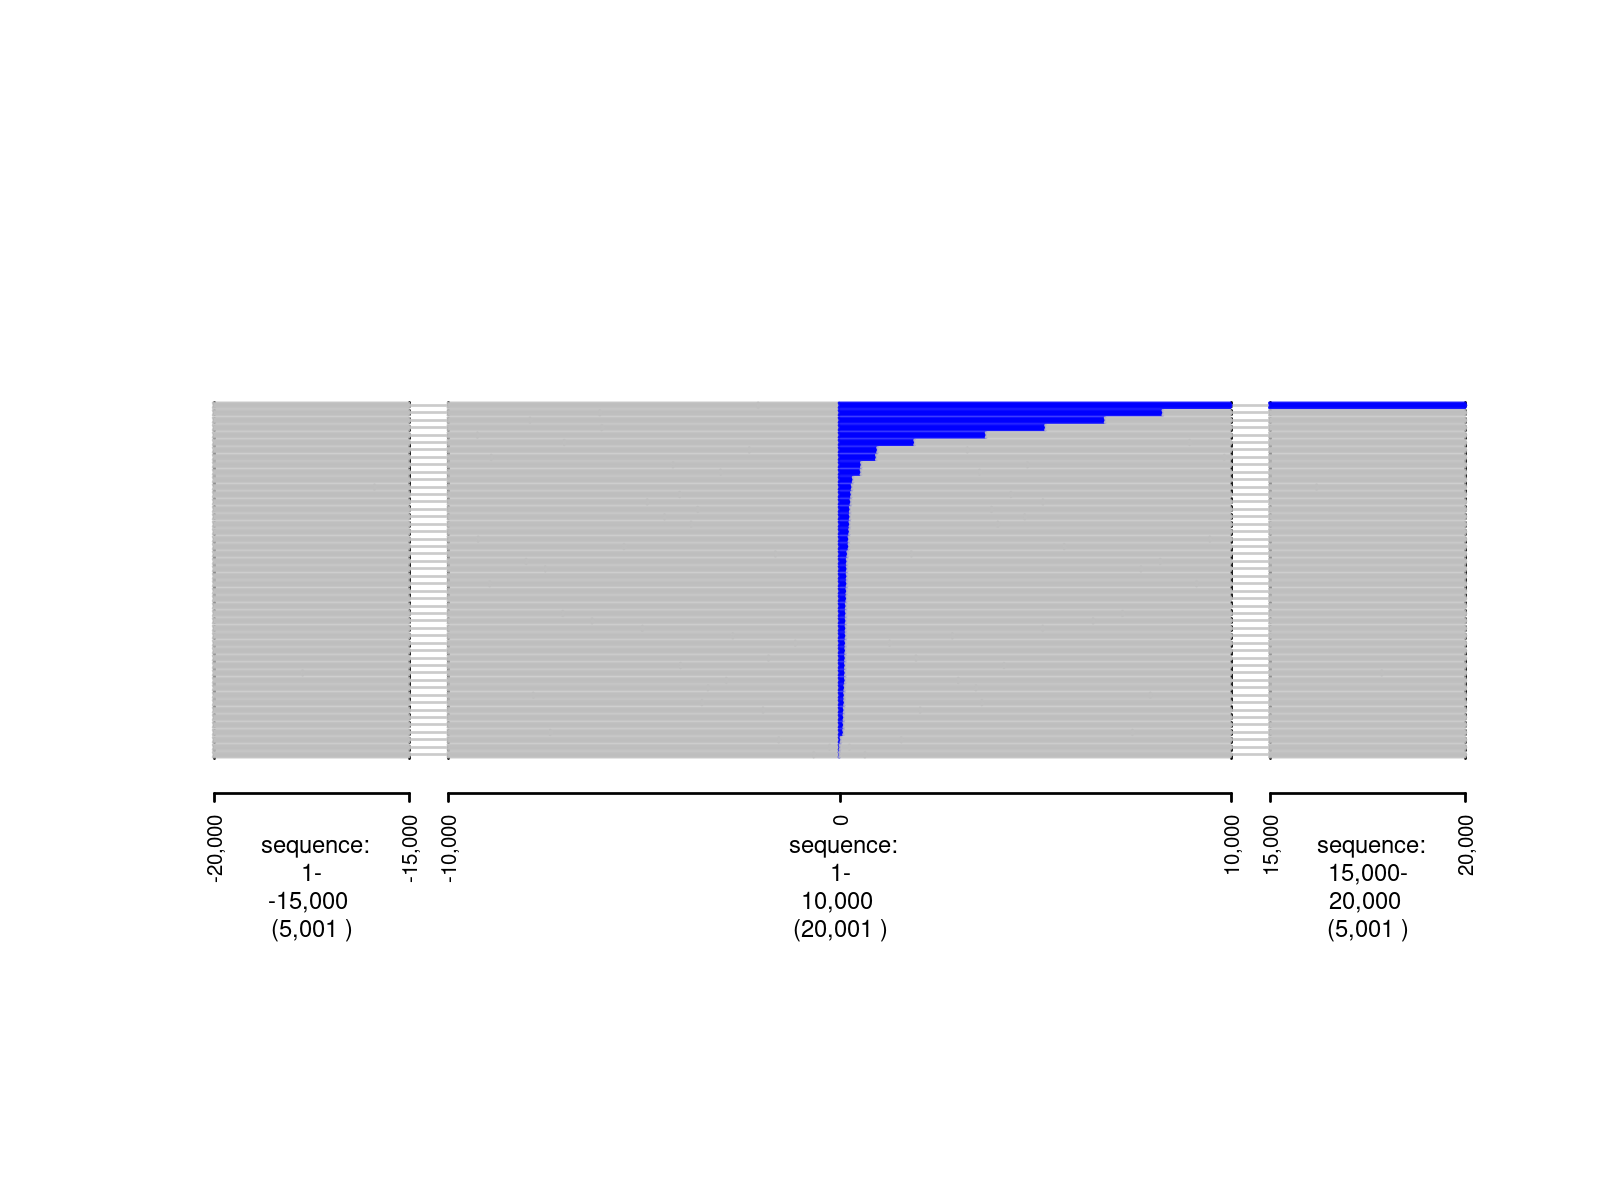

In [438]:
windows = GRanges(seqnames = "sequence",
                 ranges = IRanges(start = c(-2e4, -1e4, 1.5e4),
                                 end = c(-1.5e4, 1e4, 2e4)))


options(repr.plot.height = 6, repr.plot.width = 8)
suppressWarnings(plot(gt, windows))


In [439]:
## get all cis or trans phased edge clusters corresponding with rDups
trans.clusters.dt = phasing.barcode.counts.dt[(phase == "trans")]
setkeyv(all.walks.dt, c("ecluster", "sample"))
setkeyv(trans.clusters.dt, c("ecluster", "sample"))
trans.walks.dt = trans.clusters.dt[all.walks.dt[orientation == "trans"]][!is.na(width.l1)][!is.na(width.l2)][phase == "trans"]

## subset for the supported cis walk
supported.walks.dt = trans.walks.dt[!is.na(nbx)][, max.nbx := max(nbx), by = .(ecluster, sample)][nbx > 0]

## check for ALT edges
supported.walks.dt[, previous.walk.id := data.table::shift(walk.id)]
supported.walks.dt[, previous.sample := data.table::shift(sample)]
supported.walks.dt[, previous.ecluster := data.table::shift(ecluster)]
supported.walks.dt[, previous.start := data.table::shift(start)]
supported.walks.dt[, previous.end := data.table::shift(end)]

## strand needs to go from fct --> char
supported.walks.dt[, strand := as.character(strand)]
supported.walks.dt[, previous.strand := data.table::shift(strand)]

supported.walks.dt[(strand == "+") & 
                   (walk.id == previous.walk.id & sample == previous.sample & ecluster == previous.ecluster) & 
                   (start != previous.end + 1 | strand != previous.strand), gap := TRUE]
supported.walks.dt[(strand == "-") & 
                   (walk.id == previous.walk.id & sample == previous.sample & ecluster == previous.ecluster) & 
                   (end != previous.start - 1 | strand != previous.strand), gap := TRUE]

supported.walks.dt[is.na(gap), gap := FALSE]

supported.walks.dt[, cumulative.gaps := cumsum(x = gap), by = .(sample, ecluster, walk.id)]

supported.walks.dt[, ":="(locus1 = gap & cumulative.gaps == 1)]
supported.walks.dt[, next.locus1 := data.table::shift(locus1, n = -1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[is.na(next.locus1), next.locus1 := FALSE]
supported.walks.dt[, previous.locus1 := data.table::shift(locus1, n = 1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[is.na(previous.locus1), previous.locus1 := FALSE]
supported.walks.dt[, ":="(locus2 = previous.locus1), by = .(ecluster, sample, walk.id)]
supported.walks.dt[, flank := !(locus1 | locus2)]

In [440]:
trans.rdups.dt = supported.walks.dt

## create spChains
trans.rdups.gr = dt2gr(trans.rdups.dt, seqlengths = hg_seqlengths())
trans.rdups.grl = GenomicRanges::split(trans.rdups.gr, ~ trans.rdups.dt[, paste(ecluster, sample, walk.id)])

spc = gChain::spChain(trans.rdups.grl)
lifted.dt = as.data.table(spc@.galy)
lifted.dt[, seqnames := "sequence"]
lifted.gr = dt2gr(lifted.dt)
values(lifted.gr) = values(stack(trans.rdups.grl))

## get the amount that each range should be shifted
lifted.dt = as.data.table(lifted.gr)
lifted.dt[, shift.bp := .SD[(locus1), start], by = .(ecluster, sample, walk.id)]
lifted.dt[, insert.width := .SD[(locus1), width], by = .(ecluster, sample, walk.id)]
lifted.dt[, other.width := .SD[(locus2), sum(width)], by = .(ecluster, sample, walk.id)]
lifted.dt[, col := ifelse(flank, "gray", ifelse(locus1, "blue", "light blue"))]
lifted.dt[, nm := paste(ecluster, sample, walk.id)]

## shift the ranges
shifted.gr = GenomicRanges::shift(lifted.gr, shift = -lifted.dt[, shift.bp])
values(shifted.gr)[, "insert.width"] = lifted.dt[, insert.width]
values(shifted.gr)[, "other.width"] = lifted.dt[, other.width]
values(shifted.gr)[, "col"] = lifted.dt[, col]
values(shifted.gr)[, "nm"] = lifted.dt[, nm]

## get a range for the order
order.lifted.dt = unique(lifted.dt, by = "nm") %>% setkey(nm)

shifted.grl = GenomicRanges::split(shifted.gr, values(shifted.gr)[, "nm"])
values(shifted.grl) = order.lifted.dt[names(shifted.grl)][, .(insert.width, other.width)]
shifted.grl = shifted.grl %Q% (order(insert.width, other.width))

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 138 out-of-bound ranges located on sequence
  sequence. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 138 out-of-bound ranges located on sequence
  sequence. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”


In [441]:
gt = gTrack(shifted.grl, stack.gap = 0, labels.suppress.grl = TRUE)

In [442]:
windows = GRanges(seqnames = "sequence",
                 ranges = IRanges(start = c(-2e4, -1e4, 1.5e4),
                                 end = c(-1.5e4, 1e4, 2e4)))





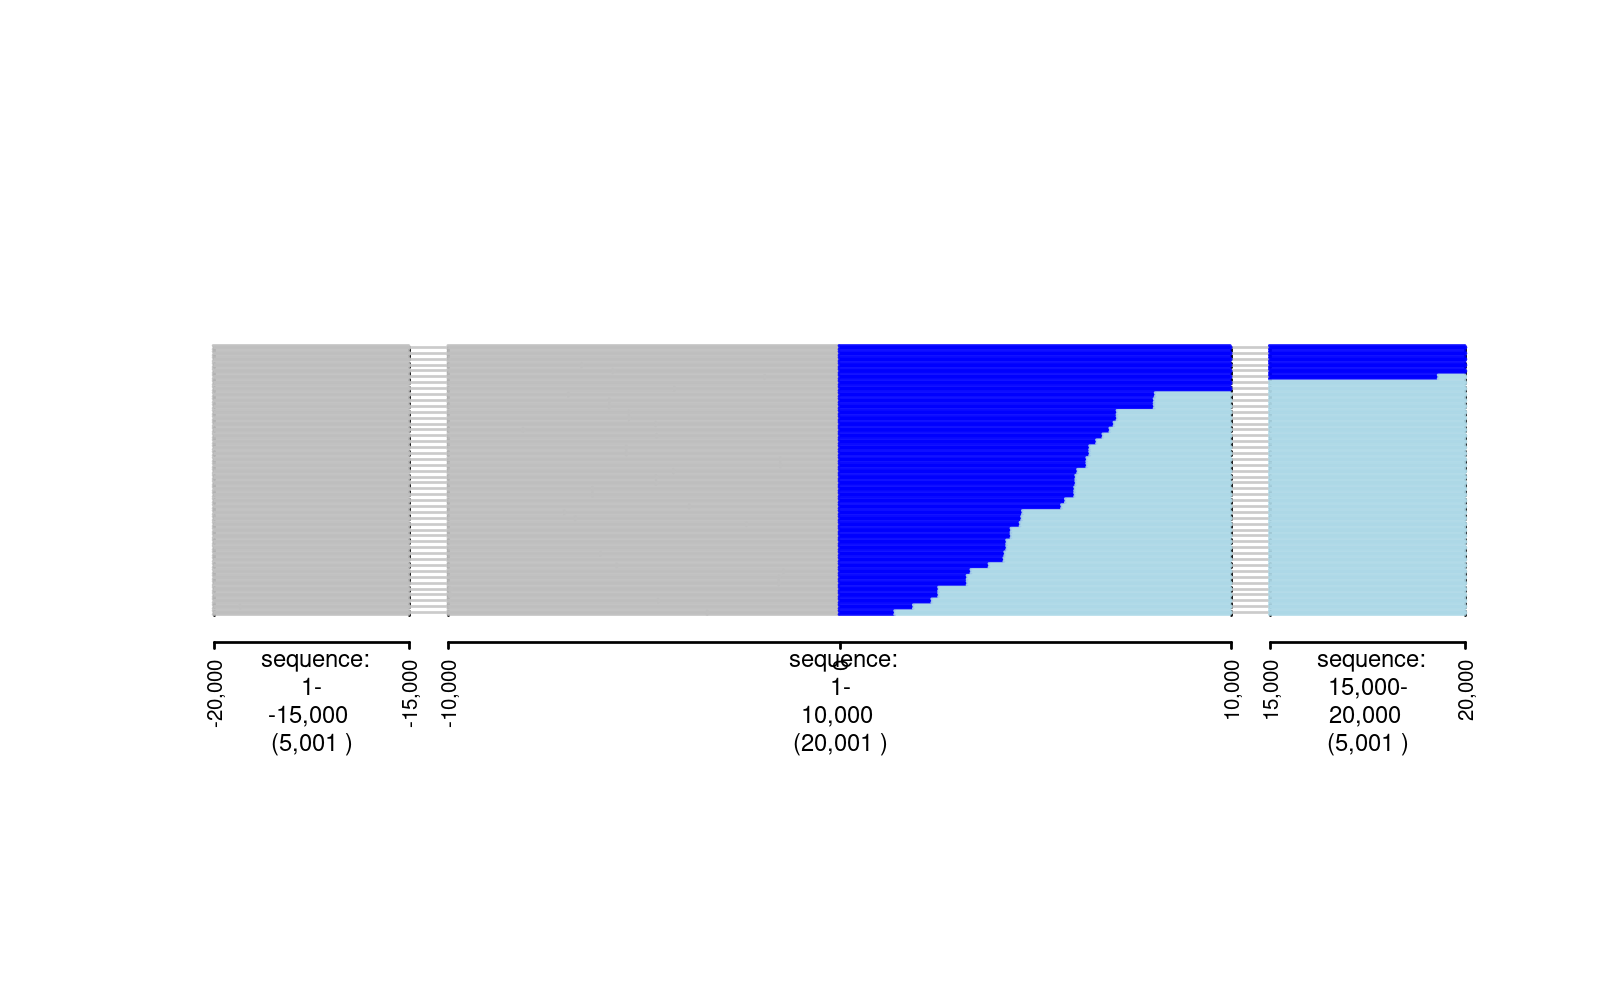

In [443]:
options(repr.plot.height = 5, repr.plot.width = 8)
suppressWarnings(plot(gt, windows))

## EDF5b
(+) gap segment length distribution of rDelDup reciprocal pairs identified as being in cis or trans by 10X linked-reads is shown as vertical lines. The multi-modal distribution of unphased rDelDup (+) gap segment lengths is shown as the black background line.

In [335]:
events.dt = readRDS("./data/revision.events.dt.rds") 
phasing.barcode.counts.dt = readRDS("./data/phasing/phasing.barcode.counts.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

## the job generating these barcode counts is here: 
## basically the phasing.barcode.counts.dt just stacks the outputs of phase_dt
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221102_re/qrp_phasing.rds")
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221107_re_re/qrp_phasing.rds")

In [339]:
## get all supported cis walks from barcode counts
phasing.barcode.counts.dt[(cis > 2 | trans > 2), 
                          phase := ifelse(cis > trans * 3,
                                          "cis", 
                                          ifelse(trans > cis * 3, "trans", "unphased"))]

phasing.barcode.counts.dt[is.na(phase), phase := "unphased"]

## grab positive gap size
qrpmix.events.dt = events.dt[(hrd_tbl[sample, aug_bopp_cohort]) &
                             (type == "qrpmix")]

## gap size
qrpmix.events.dt[(type == "qrpmix"), gap.size := ifelse(strand.l1 == "+", log10(width.l1), log10(width.l2))]

## add phase annotations
setkeyv(phasing.barcode.counts.dt, c("sample", "ecluster"))
setkeyv(qrpmix.events.dt, c("sample", "ecluster"))
qrpmix.events.dt[, lrs_phase := phasing.barcode.counts.dt[qrpmix.events.dt[, .(sample, ecluster)], phase]]

In [341]:
## create histogram
pt.dt = qrpmix.events.dt[, .(gap.size, lrs_phase)]

## decide on bandwidth
BANDWIDTH=0.35
p = ggplot_build(ggplot(pt.dt, aes(x = gap.size)) + geom_density(bw = BANDWIDTH))

## impute heights
segments.dt = qrpmix.events.dt[lrs_phase %in% c("cis", "trans")][, .(gap.size, lrs_phase)]
res = approx(x = p$data[[1]]$x, y = p$data[[1]]$y, xout = segments.dt[, gap.size])
segments.dt[, height := res$y]

## define color map
colormap = c("cis" = alpha("red", 0.8), "trans" = alpha("blue", 0.8))

pt = ggplot(pt.dt, aes(x = gap.size)) +
geom_density(bw = BANDWIDTH) +
geom_segment(data = segments.dt,
            aes(x = gap.size, xend = gap.size, y = 0, yend = height, color = lrs_phase)) +
scale_color_manual(values = colormap) +
labs(x = "log10 positive gap width", title = "rDelDup", y = "density") +
ggpubr::theme_pubr()

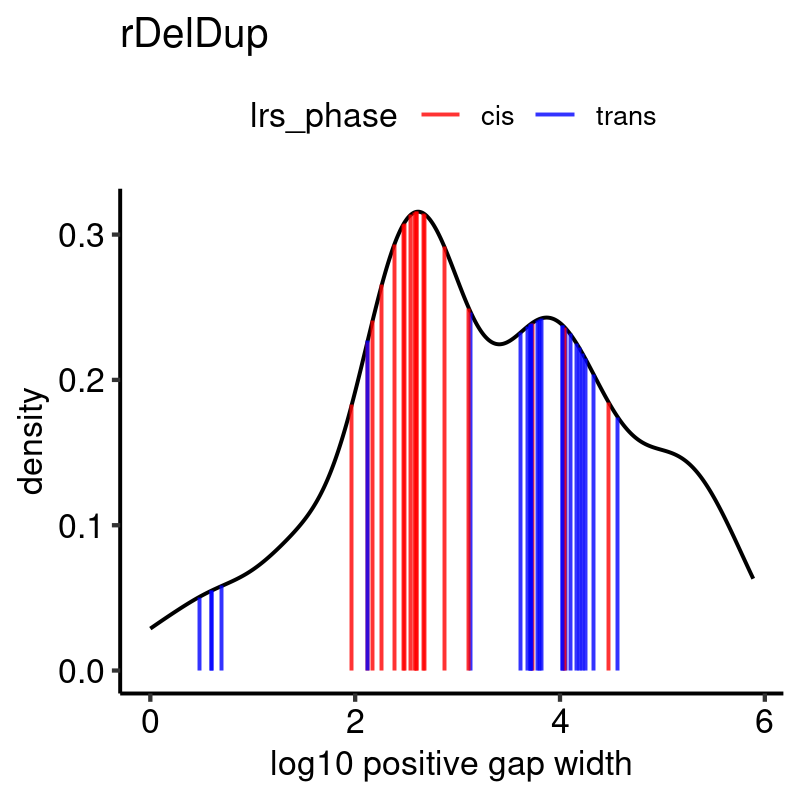

In [342]:
options(repr.plot.height = 4, repr.plot.width = 4)
suppressWarnings(print(pt))

## EDF4c

ROC curve using gap width as a proxy for phase assignment

In [2631]:
events.dt = readRDS("~/projects/Starr/BRCA/db/revision.events.dt.rds") 
phasing.barcode.counts.dt = readRDS("~/projects/Starr/BRCA/db/phasing.barcode.counts.dt.re.rds")
hrd_tbl = readRDS("~/projects/Starr/BRCA/db/hrd-supp-table.rds")

## the job generating these barcode counts is here: 
## basically the phasing.barcode.counts.dt just stacks the outputs of phase_dt
## qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221102_re/qrp_phasing.rds")
qrp.phasing.jb = readRDS("/gpfs/commons/home/zchoo/projects/gGnome/Flow/qrp_phasing/20221107_re_re/qrp_phasing.rds")

In [2632]:
## get all supported cis walks from barcode counts
phasing.barcode.counts.dt[(cis > 1 | trans > 1), phase := ifelse(cis > trans * 3, "cis", 
                                                                 ifelse(trans > cis * 3, 
                                                                        "trans", 
                                                                        "unphased"))]

## put the big gap and small gap
qrp.events.dt = events.dt[(hrd_tbl[sample, aug_bopp_cohort])][(type == "qrppos" | type == "qrpmmix" | type == "qrpmin")]

## gap size
qrp.events.dt[(type == "qrppos"), gap.size := log10(pmin(width.l1, width.l2))]
qrp.events.dt[(type == "qrpmix"), gap.size := ifelse(strand.l1 == "+", log10(width.l1), log10(width.l2))]
qrp.events.dt[(type == "qrpmin"), gap.size := 1e15]

## add annotations
setkeyv(phasing.barcode.counts.dt, c("sample", "ecluster"))
qrp.events.dt[, lrs_phase := phasing.barcode.counts.dt[qrp.events.dt[, .(sample, ecluster)], phase]]
qrp.events.dt[(gap.size < 1), lrs.phase := "cis"]

## add imputed phase
## qrp.events.dt[, imputed_phase := ifelse(gap.size >= 3.5, "trans", "cis")]

## get phased events
lrs.qrp.events.dt = qrp.events.dt[(lrs_phase %in% c("trans", "cis"))]

## generate roc curve
imputation.roc = pROC::roc(response = lrs.qrp.events.dt[, lrs_phase],
                          predictor = lrs.qrp.events.dt[, gap.size],
                          smooth = FALSE)

## get the value on ROC curve corresponding to the cutoff of 3.5
imputation.coords = pROC::coords(imputation.roc, 
                                 x = 3.5, 
                                 input = "threshold", 
                                 ret = c("threshold", "sensitivity", "specificity"))

imputation.dt = data.table(imputation.coords)
imputation.dt[, label := ifelse(round(threshold) == threshold | threshold == 3.5, as.character(threshold), "")] 

## create ROC curve
pt = pROC::ggroc(imputation.roc) + 
geom_point(data = imputation.dt, aes(x = specificity, y = sensitivity), color = "red") +
ggrepel::geom_label_repel(data = imputation.dt, aes(x = specificity,
                                                    y = sensitivity,
                                                    label = threshold)) +
geom_abline(slope = 1, intercept = 1) +
labs(title = "ROC curve for phase imputation") +
ggpubr::theme_pubr()

Setting levels: control = cis, case = trans

Setting direction: controls < cases



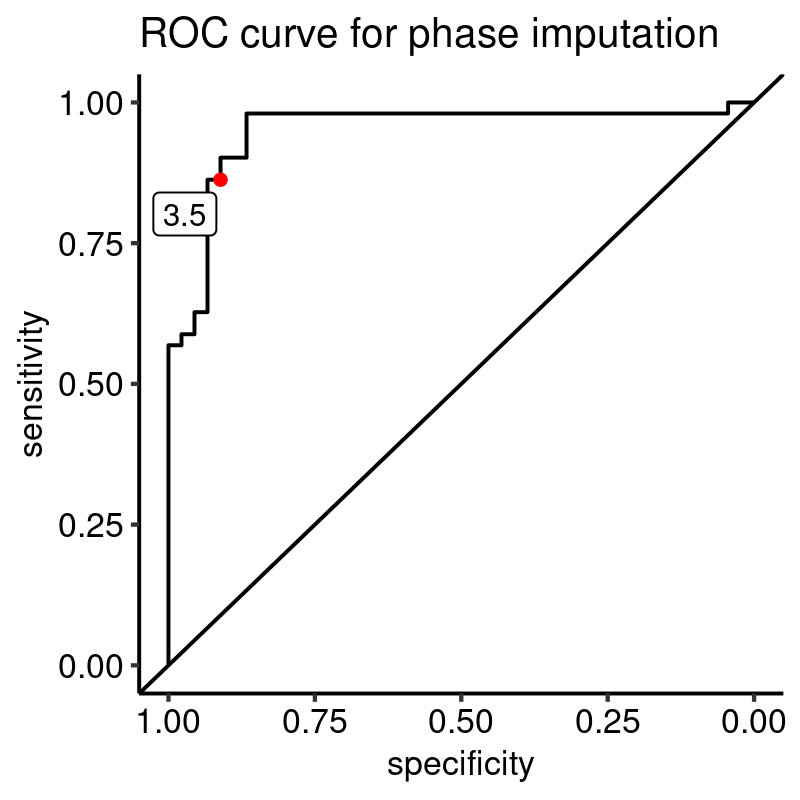

In [2633]:
options(repr.plot.height = 4, repr.plot.width = 4)
suppressWarnings(print(pt))

## EDF5d

Base pairs of microhomology at reciprocal pair junctions in BRCA1d and BRCA2d tumors.

In [2883]:
## allbpe = readRDS("~/projects/Starr/BRCA/db/all.bedpe.rds")
junctions.dt = readRDS("~/projects/Starr/BRCA/db/revision.junctions.dt.rds")
hrd_tbl = readRDS("~/projects/Starr/BRCA/db/hrd-supp-table.rds")
## hrd_tbl = readRDS("~/projects/Starr/BRCA/db/hrd-supp-table.20220831_152508.rds")

# ev.types = c('bfb', 'chromoplexy', 'chromothripsis', 'del', 'dm', 'dup', 'fbi', 'pyrgo', 
#              'qrp', 'qrppos', 'qrdup', 'qrpmin','qrdel', 'tib', 'qrpmix', 'rigma', 
#              'simple_inv', 'simple_invdup', 'simple_tra', 'tic', 'tyfonas') 

In [2894]:
## bps.dt = allbpe[ (fmut_bi %in% c("BRCA1", "BRCA2", "WT")), .(qrpmin, qrpmix, qrppos, bh40.fu, fmut_bi, pair)]
junctions.dt[, fmut_bi := hrd_tbl[sample, fmut_bi]]
bps.dt = junctions.dt[(fmut_bi %in% c("BRCA1", "BRCA2", "WT")) &
                      (IMPRECISE == FALSE) &
                      (FILTER == "PASS"), 
                      .(qrpmin, qrpmix, qrppos, bh40.fu = mh40, fmut_bi, sample)]
bps.dt[, type_simple := ifelse((!is.na(qrppos)) | (!is.na(qrpmix)) | (!is.na(qrpmin)), "quasi-reciprocal", "other")]

mh.breaks = c(-1:9, 1000000)
mh.labels = c(as.character(0:9), "10+")
bps.dt[, mh.category := cut(bh40.fu, mh.breaks, mh.labels)]

pt.dt = bps.dt[, .(n = .N), by = .(fmut_bi, type_simple, mh.category)][, tot := sum(n), by = .(fmut_bi, type_simple)]
pt.dt[, ci.lower := mapply(function(x, y) {dflm(prop.test(x, y))$ci.lower}, n, tot) %>% unlist]
pt.dt[, ci.upper := mapply(function(x, y) {dflm(prop.test(x, y))$ci.upper}, n, tot) %>% unlist]
pt.dt[, frac := n / tot]  

In [2895]:
pt = ggplot(pt.dt[!is.na(mh.category)], aes(x = mh.category, y = frac)) +
geom_bar(stat = "identity") +
geom_errorbar(aes(ymin=ci.lower, ymax=ci.upper), width=.2,position=position_dodge(.9)) +
facet_grid(cols = vars(type_simple), rows = vars(fmut_bi)) +
labs(y = "fraction of junctions", x = "base pairs of microhomology") +
ggpubr::theme_pubr()## + 
##coord_flip()

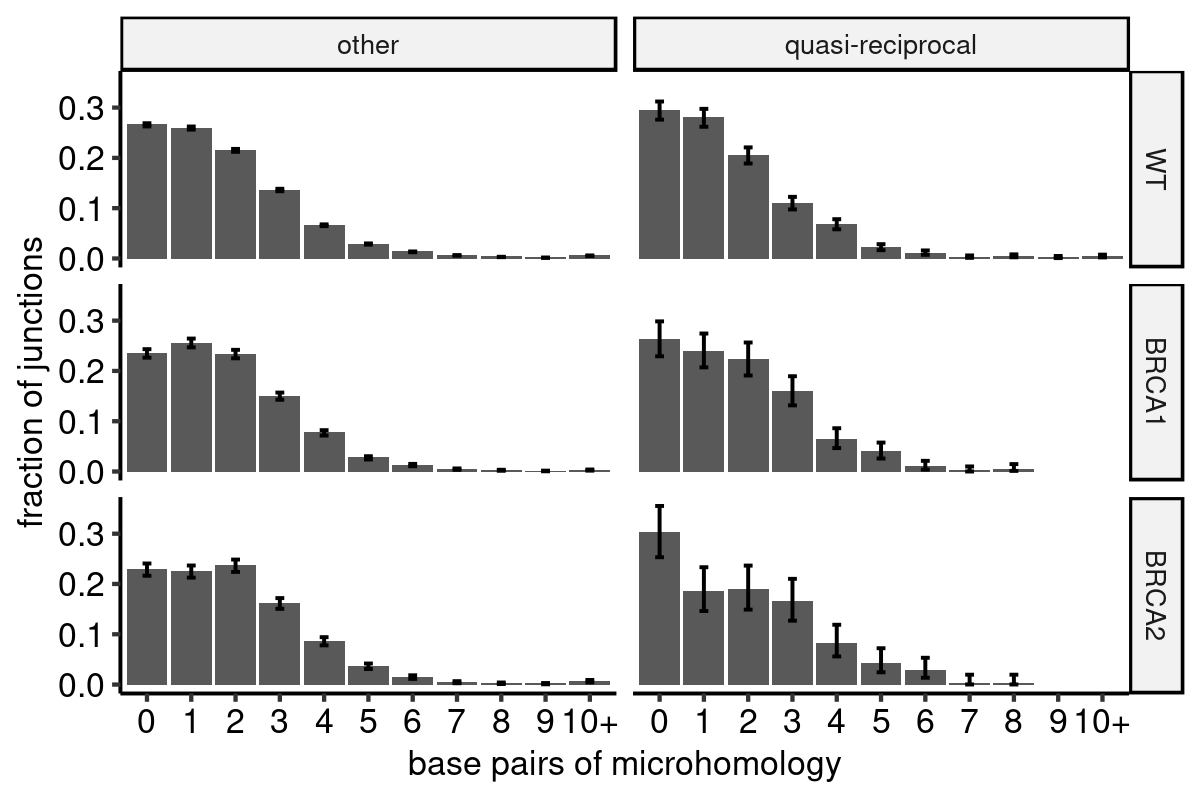

In [2897]:
options(repr.plot.height = 4, repr.plot.width = 6)
suppressWarnings(print(pt))

## EDF5e
rDup (x-axis) and tandem duplication (y-axis) count per sample across 46 BRCA1d samples. R2 and P value obtained by Spearman rank correlation.

Warning message in cor.test.default(dup, qrppos, method = "spearman"):
“Cannot compute exact p-value with ties”


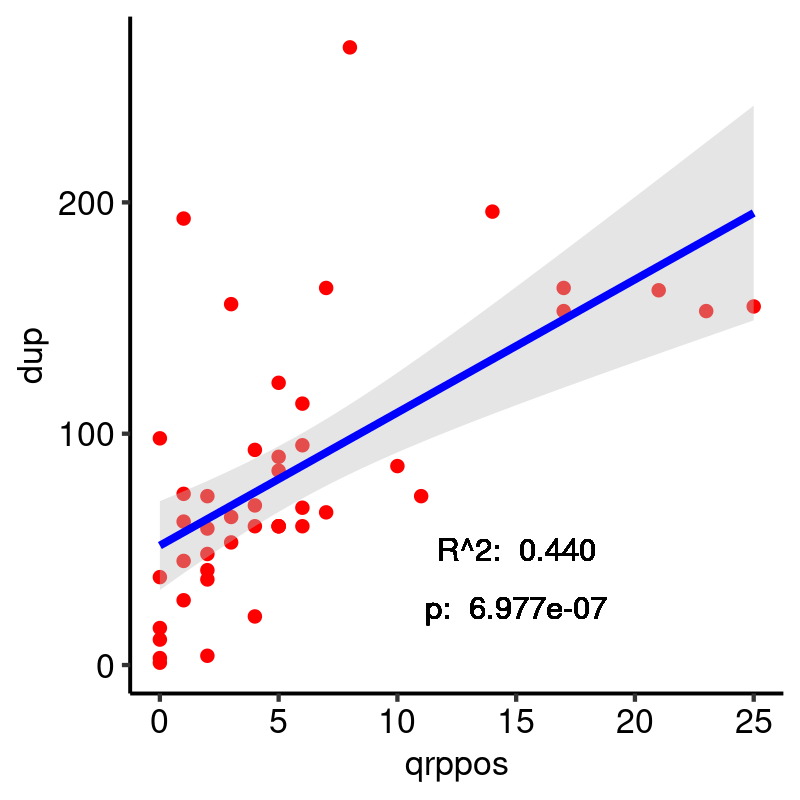

In [348]:
events.dt = readRDS("./data/revision.events.dt.rds") 
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

event.counts.dt = dcast.data.table(as.data.table(events.dt[, table(type, sample)]),
                                   sample ~ type,
                                   value.var = "N")

pt.dt = event.counts.dt[(hrd_tbl[sample, fmut_bi == "BRCA1"]) &
                 (hrd_tbl[sample, aug_bopp_cohort])]

res = pt.dt[, cor.test(dup, qrppos, method = "spearman")]

pt = ggplot(pt.dt, aes(x = qrppos, y = dup)) +
    geom_point(color = "red") +
    geom_smooth(colour = "blue", fill = "gray", method = 'lm', formula = y ~ x) + 
    geom_text(x = 15, y = 50, label = paste("R^2: ", sprintf("%.03f", res$estimate^2))) +
    geom_text(x = 15, y = 25, label = paste("p: ", sprintf("%.03e", res$p.value)))  +
    ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 4)
suppressWarnings(print(pt))

## EDF5f

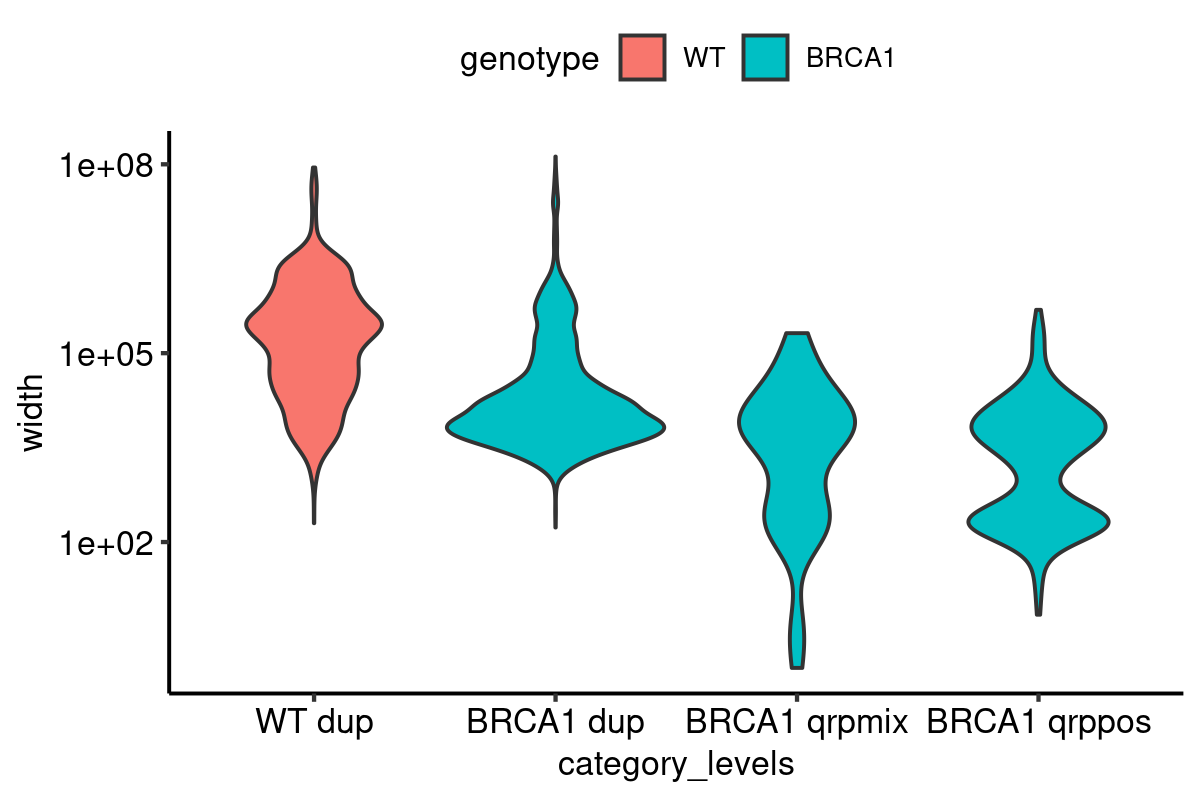

In [350]:
events.dt = readRDS("./data/revision.events.dt.rds") 
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

dups.dt = events.dt[(hrd_tbl[(sample), aug_bopp_cohort]) &
                       (((hrd_tbl[(sample), fmut_bi == "BRCA1"]) & (type %in% c("dup", "qrppos", "qrpmix"))) | 
                        ((hrd_tbl[(sample), fmut_bi == "WT"]) & (type == "dup")))]

dups.dt[(type == "qrppos"), width := pmin(width.l1, width.l2)]
dups.dt[(type == "qrpmix"), width := ifelse(strand.l1 == "+", width.l1, width.l2)]
dups.dt[(type == "dup"), width := width(parse.gr(footprint))]

dups.dt[, category := paste(hrd_tbl[sample, fmut_bi], type)]
dups.dt[, category_levels := ordered(category, c("WT dup", "BRCA1 dup", "BRCA1 qrpmix", "BRCA1 qrppos"))]
dups.dt[, genotype := hrd_tbl[sample, fmut_bi]]

pt = ggplot(dups.dt, aes(x = category_levels, y = width, fill = genotype)) +
geom_violin() +
scale_y_continuous(trans = "log10") +
ggpubr::theme_pubr()

options(repr.plot.height = 4, repr.plot.width = 6)
suppressWarnings(print(pt))

In [351]:
wilcox.test(x = dups.dt[(category == "WT dup"), log10(width)],
           y = dups.dt[(category == "BRCA1 dup"), log10(width)])


	Wilcoxon rank sum test with continuity correction

data:  dups.dt[(category == "WT dup"), log10(width)] and dups.dt[(category == "BRCA1 dup"), log10(width)]
W = 7543272, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [352]:
wilcox.test(x = dups.dt[(category == "WT dup"), log10(width)],
           y = dups.dt[(category == "BRCA1 qrpmix"), log10(width)])


	Wilcoxon rank sum test with continuity correction

data:  dups.dt[(category == "WT dup"), log10(width)] and dups.dt[(category == "BRCA1 qrpmix"), log10(width)]
W = 204093, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [353]:
wilcox.test(x = dups.dt[(category == "WT dup"), log10(width)],
           y = dups.dt[(category == "BRCA1 qrppos"), log10(width)])


	Wilcoxon rank sum test with continuity correction

data:  dups.dt[(category == "WT dup"), log10(width)] and dups.dt[(category == "BRCA1 qrppos"), log10(width)]
W = 612684, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


# Figure 4
Deletions with homeology

## Figure 4a
Example of a deletion with microhomology

In [2]:
junctions.dt = readRDS("~/projects/Starr/BRCA/db/revision.junctions.dt.rds")
hrd_tbl = readRDS("~/projects/Starr/BRCA/db/hrd-supp-table.rds")


### SKIP THE FOLLOWING CELLS

In [4]:
junctions.dt[sample == "28" & seqnames.1 == "1" & seqnames.2 == "1" & class == "DEL-like",
            .(edge.id, seqnames.1, start.1, start.2)]

edge.id seqnames.1 start.1   start.2  
1  3      1           39683340  39684677
2  6      1           72489671 108703489
3 14      1          156495683 156496909
4 17      1          166624767 166635803
5 20      1          167899184 167900394
6 27      1          196893626 196895257
7 35      1          212453929 212461425

In [444]:
## generate gGraph and gTrack for coverage
slim.pairs = readRDS("~/projects/Starr/BRCA/db/slim.pairs.rds")   

this.sample = "28"
this.edge.id = 17
gg = gGnome::gG(jabba = slim.pairs[this.sample, complex])
cov = readRDS(slim.pairs[this.sample, cbs_cov_rds])
values(cov)[, "cn"] = skitools::rel2abs(cov, field = "ratio", purity = gg$meta$purity, ploidy = gg$meta$ploidy)
cov.gt = gTrack(cov, y.field = "cn", max.ranges = 5e3, y0 = 0, y1 = 6, circles = TRUE, lwd.border = 0.3)

this.window = stack(gg$junctions[this.edge.id]$grl)[, c()]

In [445]:
## get junction support from linked reads
devtools::load_all("~/git/readsupport")

treads = bamUtils::read.bam(slim.pairs[this.sample, tumor_bam_10x],
                            gr = this.window + 5e4,
                            pairs.grl = FALSE,
                            tag = "BX")

treads = treads %Q% (!is.na("BX"))

res = skitools:::score.walks(wks = gg$junctions[this.edge.id]$gw(pad = 1e4)$grl,
                                reads = treads,
                                pad = 0,
                                use.discordant = TRUE,
                                raw = TRUE)

tumor.res = as.data.table(reshape2::melt(as.matrix(res$sc)))[(value > 0), .(BX = Var1, walk.id = Var2)]

reads.gt = gTrack(split(treads %Q% (BX %in% tumor.res$BX), ~ BX), labels.suppress.grl = TRUE)

ℹ Loading readsupport
Warning message:
“replacing previous import ‘GenomicRanges::shift’ by ‘data.table::shift’ when loading ‘readsupport’”
Warning message:
“replacing previous import ‘Matrix::%&%’ by ‘gGnome::%&%’ when loading ‘readsupport’”
Warning message:
“replacing previous import ‘GenomicRanges::merge’ by ‘gGnome::merge’ when loading ‘readsupport’”
Warning message:
“replacing previous import ‘GenomicRanges::seqinfo<-’ by ‘gTrack::seqinfo<-’ when loading ‘readsupport’”
Warning message:
“replacing previous import ‘GenomicRanges::union’ by ‘igraph::union’ when loading ‘readsupport’”
Warning message:
“replacing previous import ‘data.table::melt’ by ‘reshape2::melt’ when loading ‘readsupport’”
Warning message:
“replacing previous import ‘data.table::dcast’ by ‘reshape2::dcast’ when loading ‘readsupport’”
Warning message:
“replacing previous import ‘RSeqLib::genome’ by ‘rtracklayer::genome’ when loading ‘readsupport’”
Warning message:
“replacing previous import ‘igraph::blocks’ by ‘rtr

In [450]:
## save:
## JaBbA
saveRDS(gg, "./data/homeology/example.ggraph.rds")

## coverage
saveRDS(cov[, "cn"] %Q% (cov %^% this.window + 1e5), "./data/homeology/example.cov.rds")

## tumor reads
saveRDS(treads[, "BX"] %Q% (BX %in% tumor.res$BX), "./data/homeology/example.treads.rds")

## supporting barcodes
saveRDS(tumor.res, "./data/homeology/example.bxsupp.rds")

Warning message in gr.findoverlaps(query, subject, ...):
“findOverlaps applied to ranges with non-identical seqlengths”


### START HERE!!!

In [455]:
this.sample = "28"
this.edge.id = 17
gg = gGnome::gG(jabba = "./data/homeology/example.ggraph.rds")
cov = readRDS("./data/homeology/example.cov.rds")
cov.gt = gTrack(cov, y.field = "cn", max.ranges = 5e3, y0 = 0, y1 = 6, circles = TRUE, lwd.border = 0.3)

treads = readRDS("./data/homeology/example.treads.rds")
tumor.res = readRDS("./data/homeology/example.bxsupp.rds")

reads.gt = gTrack(split(treads %Q% (BX %in% tumor.res$BX), ~ BX), labels.suppress.grl = TRUE)

this.window = stack(gg$junctions[this.edge.id]$grl)[, c()]

Warning message in gr.findoverlaps(query, subject, ...):
“findOverlaps applied to ranges with non-identical seqlengths”
Warning message in gr.findoverlaps(gr, windows):
“findOverlaps applied to ranges with non-identical seqlengths”


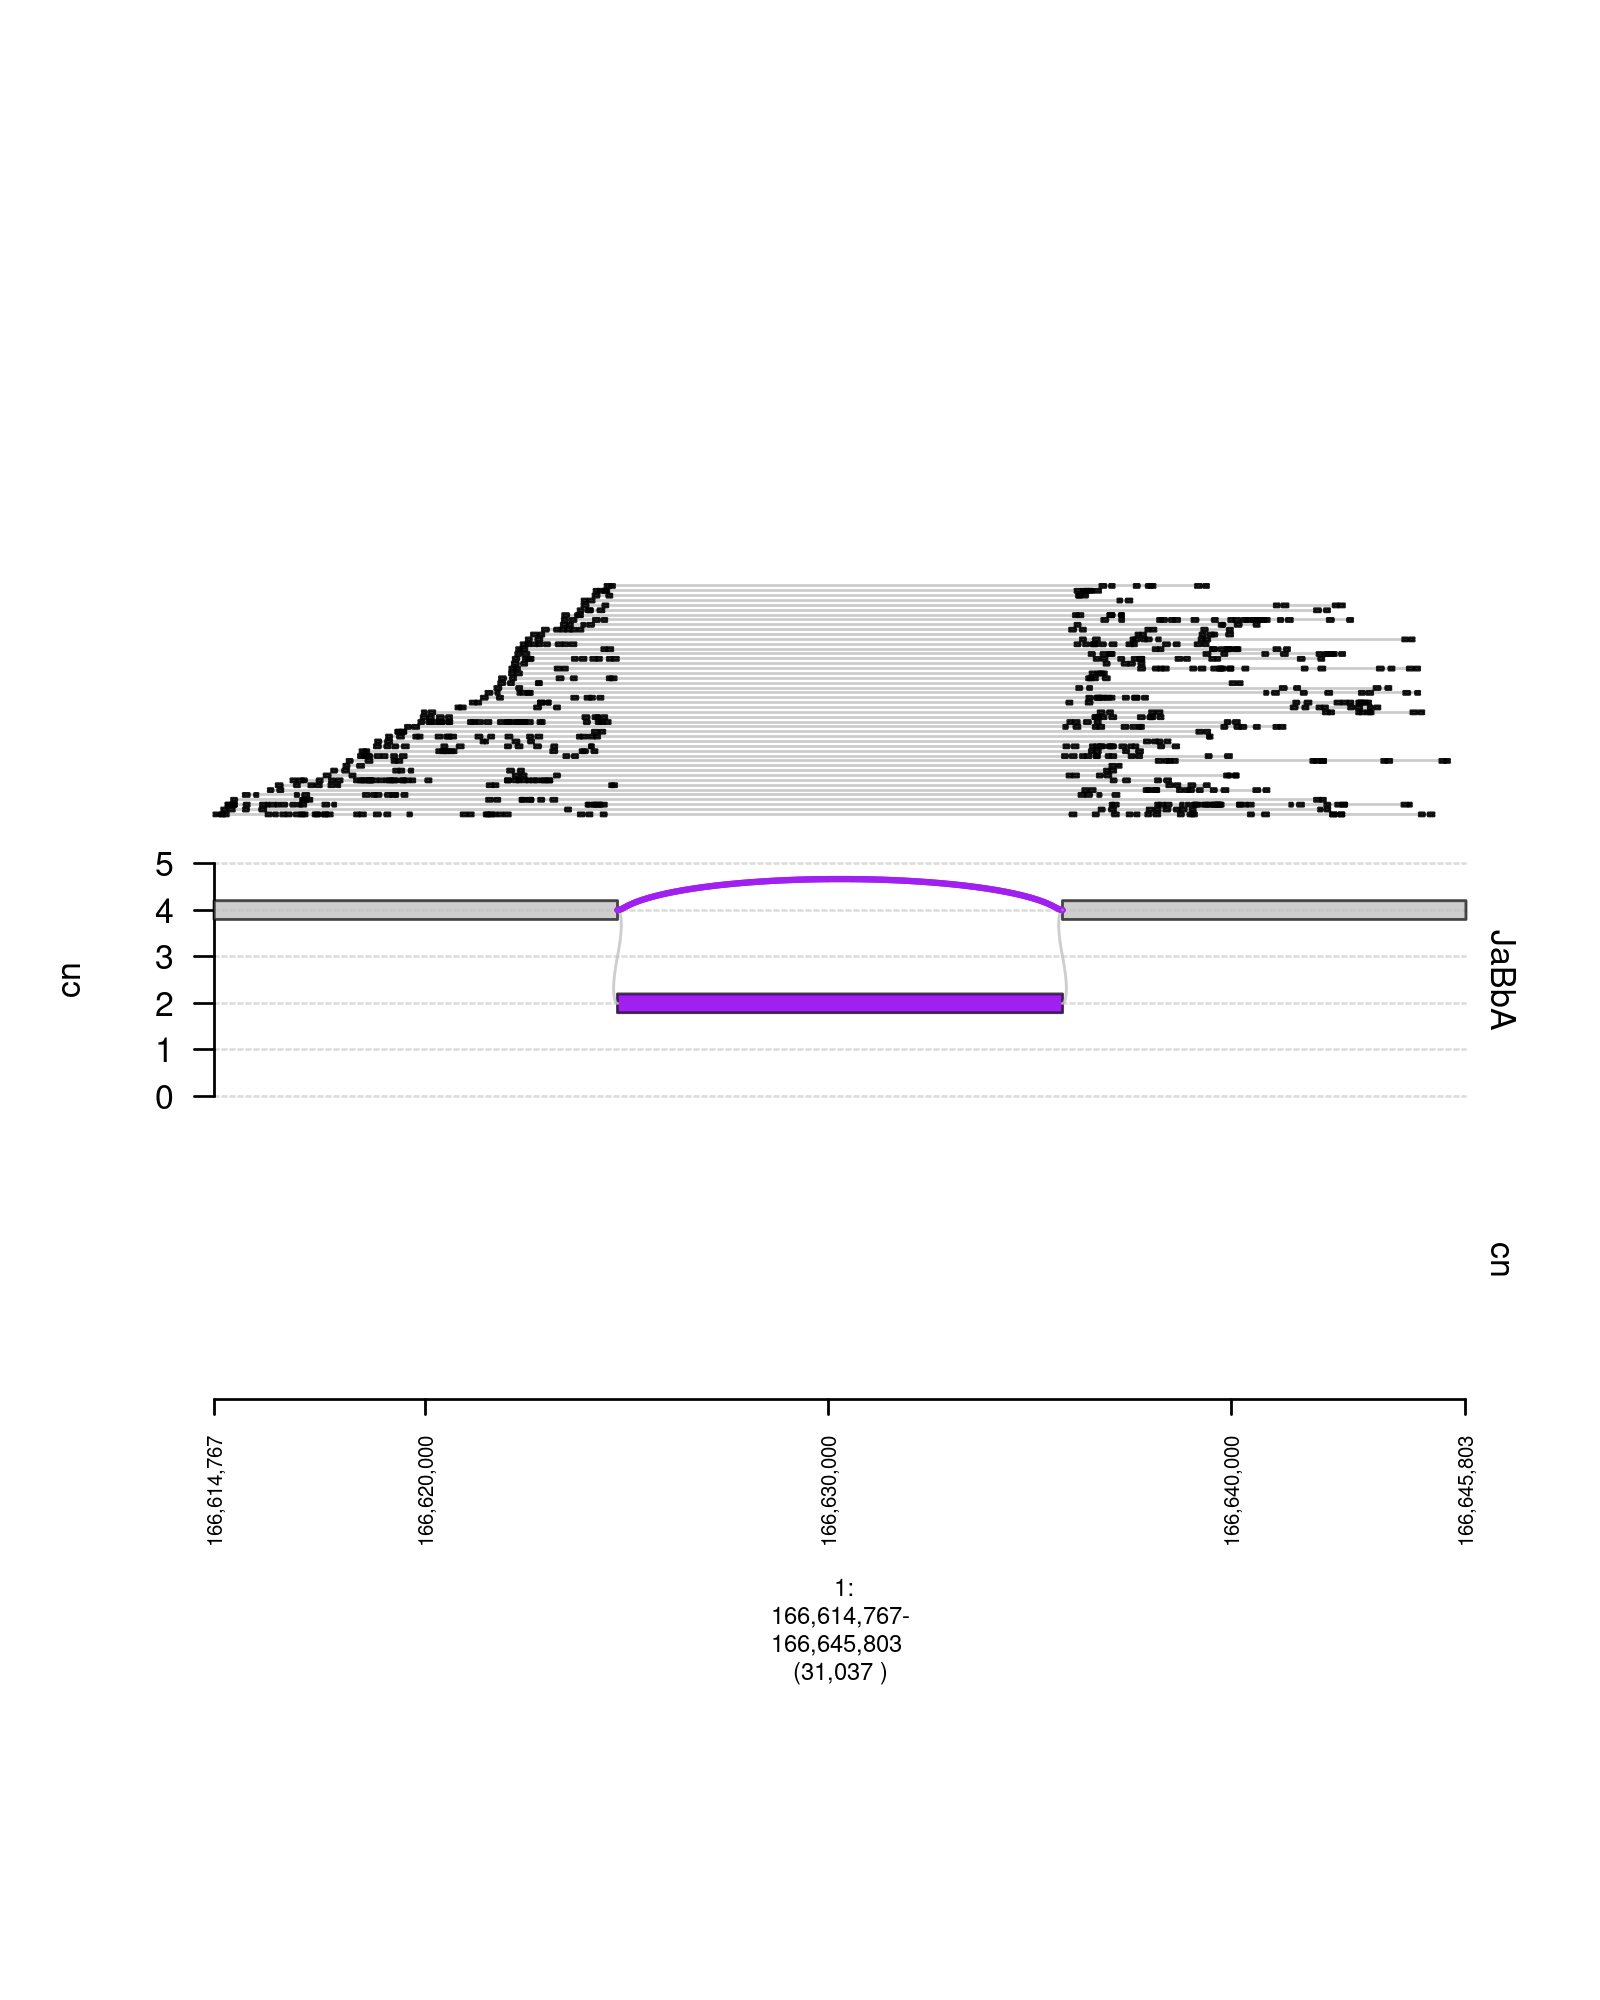

In [456]:
options(repr.plot.width = 8, repr.plot.height = 10)
plot(c(cov.gt, gg$gt, reads.gt), this.window + 1e4)

In [ ]:
ref = readDNAStringSet("~/DB/hg19/human_g1k_v37.fasta")
names(ref) = sapply(names(ref), function(x) {strsplit(x, split = " ")[[1]][1]})

In [46]:
head(ref)

DNAStringSet object of length 6:
        width seq                                           names               
[1] 249250621 NNNNNNNNNNNNNNNNNNNNN...NNNNNNNNNNNNNNNNNNNNN 1
[2] 243199373 NNNNNNNNNNNNNNNNNNNNN...NNNNNNNNNNNNNNNNNNNNN 2
[3] 198022430 NNNNNNNNNNNNNNNNNNNNN...NNNNNNNNNNNNNNNNNNNNN 3
[4] 191154276 NNNNNNNNNNNNNNNNNNNNN...NNNNNNNNNNNNNNNNNNNNN 4
[5] 180915260 NNNNNNNNNNNNNNNNNNNNN...NNNNNNNNNNNNNNNNNNNNN 5
[6] 171115067 NNNNNNNNNNNNNNNNNNNNN...NNNNNNNNNNNNNNNNNNNNN 6

In [47]:
this.window

GRanges object with 2 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]        1 166624767      -
  [2]        1 166635803      +
  -------
  seqinfo: 85 sequences from an unspecified genome

In [52]:
win = this.window[, c()]
strand(win) = "+"

In [70]:
hm = GxG::homeology(ref = ref, gr = win + 100, stride = 2, pad = 9, verbose = TRUE, rc  = FALSE)

Populating 202 bins with width 20 and stride 2

Computing 202 by 202 distance matrix



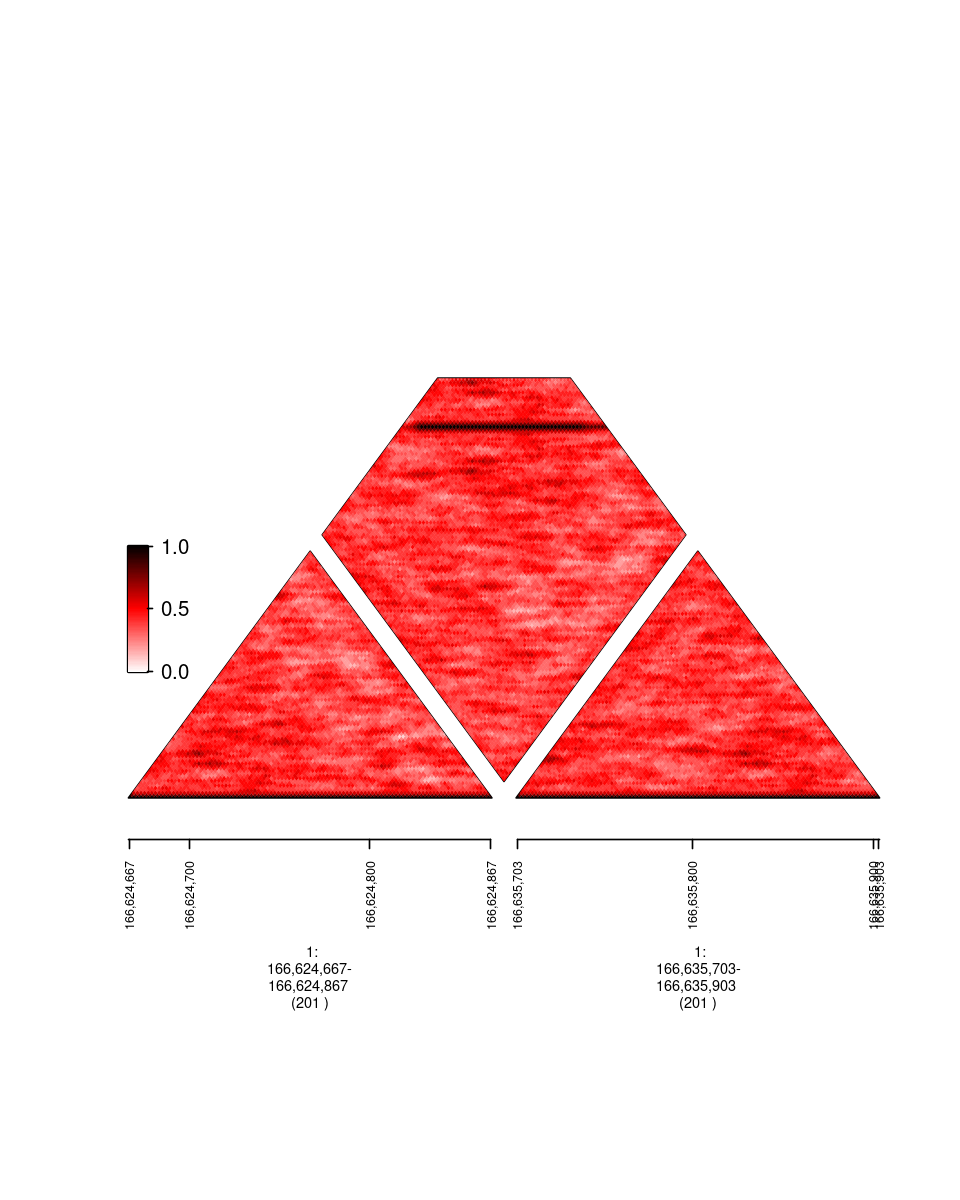

In [75]:
options(repr.plot.width = 8, repr.plot.height = 10)
plot(c(hm$gtrack(clim = c(0, 1), cmap.min = 0)), this.window + 100)

## Fig. 4b
Heatmap showing counts of bases with homeology (sequence similarity ≥ 0.8) across all detected LR and standard WGS junctions on a coordinate system defined around the location and orientation of each junction breakend. Pixels are colored according to the fraction of homeologous bases in the corresponding bin pair.

In [354]:
junctions.dt = readRDS("./data/revision.junctions.dt.rds")
## allbpe.old = readRDS('db/all.bedpe.20221016_150051.rds')
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
## slim.pairs = readRDS("~/projects/Starr/BRCA/db/slim.pairs.rds")

In [363]:
## this is the saved junction input
## dt.jun = readRDS("~/projects/Starr/BRCA/db/fig4a.dt.jun.rds")

## this is a matrix of homology aggregated at the 1 bp level
anymat.strict = readRDS("./data/homeology/fig4a.anymat.strict.rds")

In [356]:
## functions from Kevin                                                                   
reducemat = function(lch, gr = (parse.gr(c("Left:0", "Right:0")) + 500) %>% gr.tile(1), 
                     mc.cores = 1, chunk_size = 100) {
    lch = lch %>% {khtools::make_chunks({set.seed(10); sample(., length(.))}, 
                                        n = chunk_size)}
    ifun3 = function(p) {
        khtools::try2({
            junmat = readRDS(p)
            return(junmat)
        })
    }
    mat = Matrix::sparseMatrix(1, 1, x = 0, dims = rep(length(gr), 2))
    dimnames(mat) = list(names(gr), names(gr))

    for (i in seq_along(lch)) {
        now = Sys.time()
        ok = mclapply(mc.cores = mc.cores, lch[[i]], ifun3)
        mat = mat + Reduce("+", ok)
        print(Sys.time() - now)
    }
    return(mat)
}                                                                                         

spoutmat = function(gr, mat, agg.gr) {
    sumgm = GxG::gM(gr, mat)
    sumgm.agg = sumgm$agg(agg.gr)
}

In [360]:
## this block of code will prepare anymat.strict from dt_jun but will not
## keydt = subset(allbpe.old, 
##                hrd_tbl[pair, (aug_bopp_cohort)] & 
##                jdist > 200 & hlen > 0 & FILTER %in% c("PASS"))[, .(pair, edge.id)]

## this kind of takes a while to run
## so i don't recommend it and prefer to read anymat.strict
## anymat.strict = reducemat(dt.jun[keydt]$path, mc.cores = 100)

In [361]:
gr = (parse.gr(c("Left:0", "Right:0")) + 500) %>% gr.tile(1)
gr.10 = range(gr) %>% tile(width = 10) %>% grl.unlist
gm.all = spoutmat(gr, anymat.strict, gr.10) / (median(width(gr.10)))
win = parse.gr(c("Left:0", "Right:0")) + 500
mx.all = max(gm.all[win[1], win[2]]$value)
gt.all = gm.all$gtrack(height = 100, clim = c(0, mx.all)) 

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 2 out-of-bound ranges located on sequences Left
  and Right. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 2 out-of-bound ranges located on sequences Left
  and Right. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular() to get the lengths and circularity
  flags of the underlying sequences). You can use trim() to trim these
  ranges. See ?`trim,GenomicRanges-method` for more information.”
Warning me

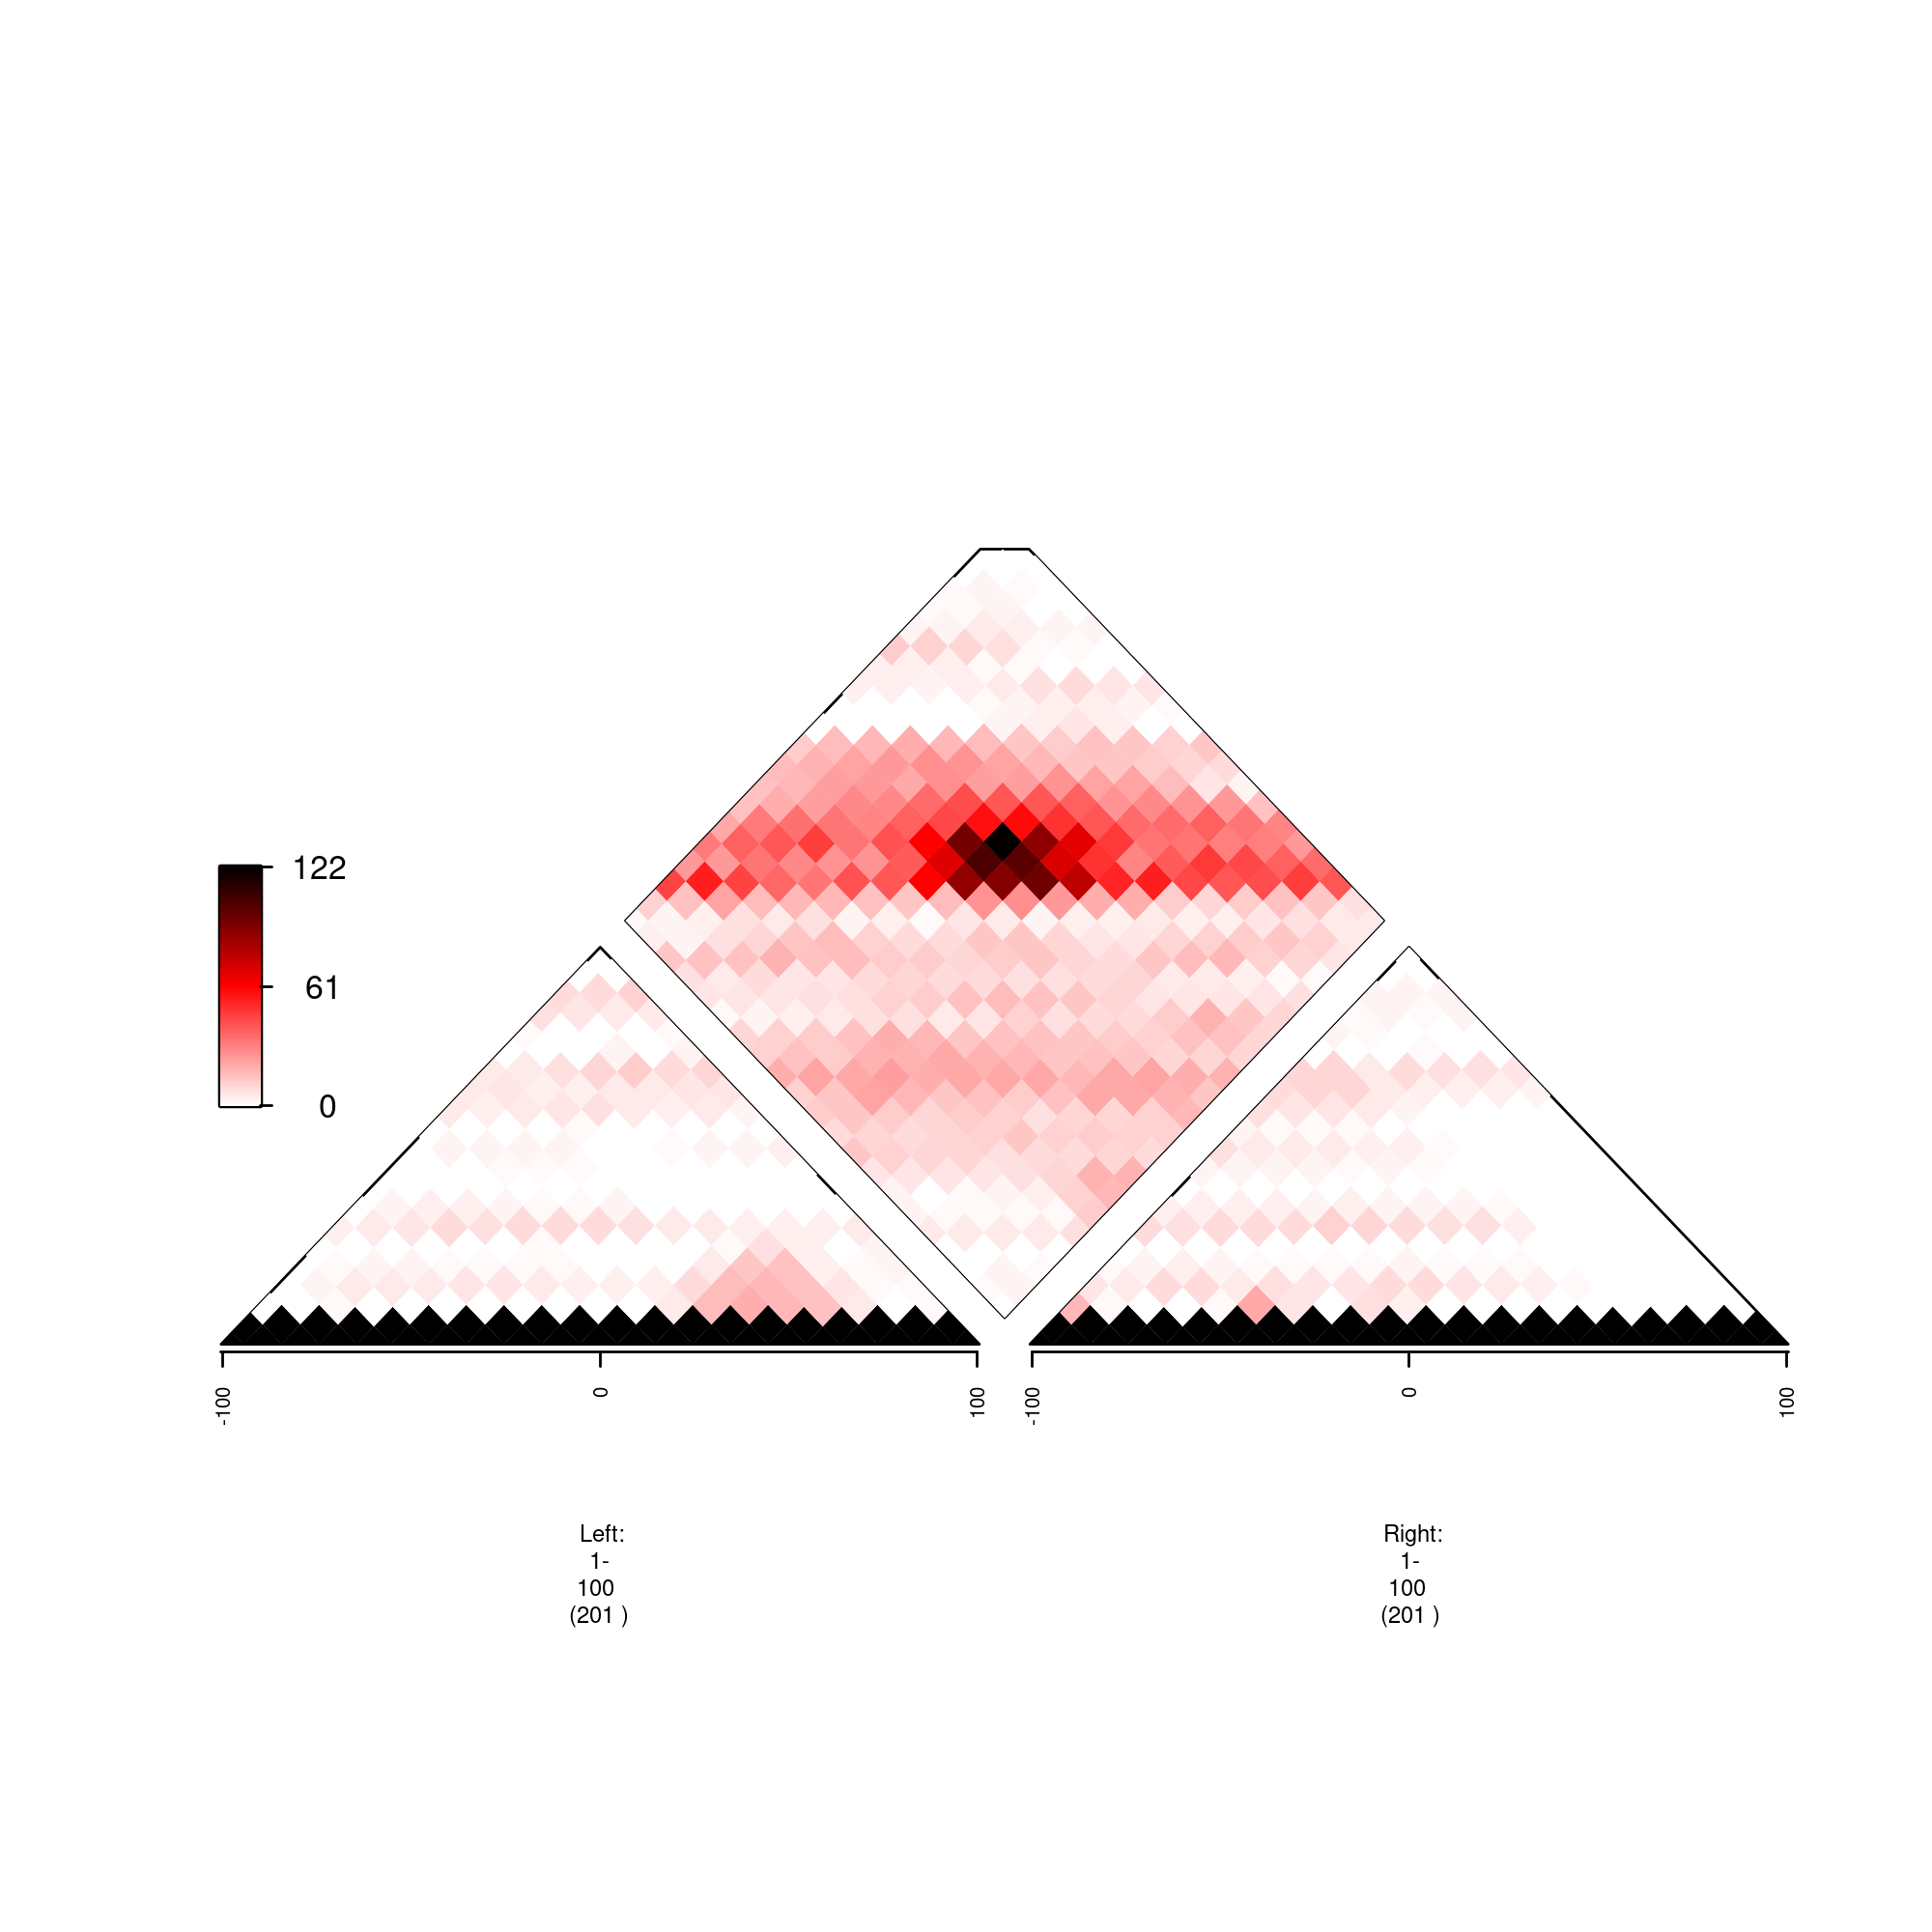

In [362]:
options(repr.plot.height = 10, repr.plot.width = 10)
suppressWarnings({
    plot(c(gt.all), parse.gr(c("Left:0", "Right:0")) + 100)
})

## Fig. 4c
Length of homeology (see Methods) measured across all linked-read (top) and WGS (bottom) deletions.

In [364]:
junctions.dt = readRDS("./data/revision.junctions.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

In [365]:
dels.dt = junctions.dt[(!is.na(del)) & 
                      (hrd_tbl[sample, aug_bopp_cohort]) &
                      (hrd_tbl[sample, fmut_bi %in% c("BRCA1", "BRCA2")])]

## stratify dels by dataset
dels.dt[, dataset := hrd_tbl[sample, dataset]]
dels.dt[, cohort_category := ifelse(dataset == "STARR", "10X", "WGS")]

## stratify log homology length into bins manually
mhlen.breaks = c(-1, seq(0, 6, length.out = 20))
mhlen.labels = c(exp(seq(0, 6, length.out = 20)))
dels.dt[, hlen.bucket := cut(log1p(hlen), breaks = mhlen.breaks, labels = mhlen.labels)]

In [366]:
## dels.dt[hlen > 0, summary(hlen), by = cohort_category]
dels.dt[, table(hlen > 0, cohort_category)]

       cohort_category
         10X  WGS
  FALSE  687 2000
  TRUE    32  101

In [367]:
pt.dt = dels.dt[, .(N = .N), keyby = .(cohort_category, hlen.bucket)]
pt.dt[, frac := N / sum(N), by = cohort_category]

## get the fraction manually after expanding grid
combos = as.data.table(expand.grid(cohort_category = pt.dt[, unique(cohort_category)],
                                   hlen.bucket = mhlen.labels))

combos[, cohort_category := as.character(cohort_category)]
combos[, hlen.bucket := as.character(hlen.bucket)]

pt.dt = pt.dt[combos][is.na(frac), frac := 0]
pt.dt = pt.dt[!is.na(hlen.bucket)][order(as.numeric(hlen.bucket))]

## get the label as a nice format
pt.dt[, hlen.bucket.nice := sprintf("%.1f", as.numeric(hlen.bucket))]

ylim 0 0.015 


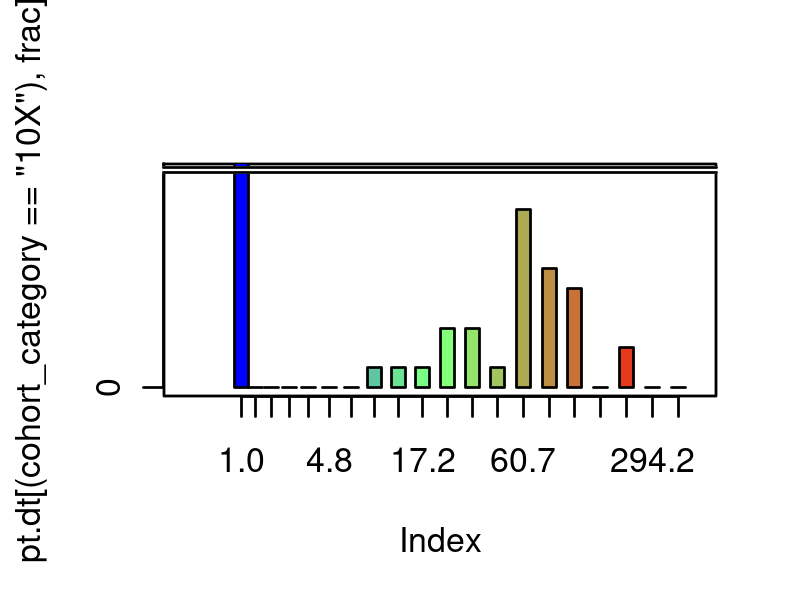

In [368]:
options(repr.plot.height = 3, repr.plot.width = 4)
pt = plotrix::gap.barplot(pt.dt[(cohort_category == "10X"), frac],
                          xaxlab = pt.dt[(cohort_category == "10X"), hlen.bucket.nice],
                          xtics = log1p(mhlen.labels),
                          xlim = c(0, log(500)),
                          gap = c(0.015, 0.9),
                          ylim = c(0, 0.015),
                          yaxlab = seq(0, 1, 0.05))

ylim 0 0.015 


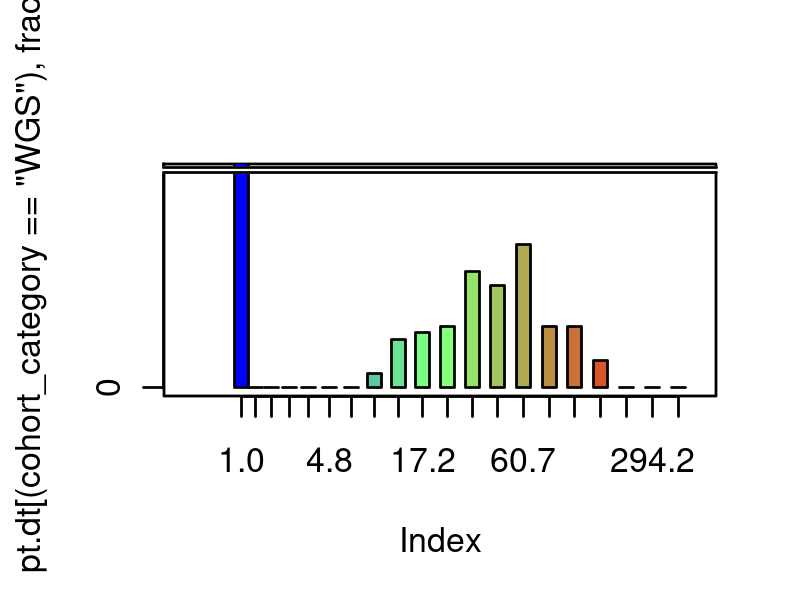

In [369]:
pt = plotrix::gap.barplot(pt.dt[(cohort_category == "WGS"), frac],
                          xaxlab = pt.dt[(cohort_category == "WGS"), hlen.bucket.nice],
                          xtics = log1p(mhlen.labels),
                          xlim = c(0, log(500)),
                          gap = c(0.015, 0.9),
                          ylim = c(0, 0.015),
                          yaxlab = seq(0, 1, 0.05))

## Figure 4d
Fraction of homeologous junctions among simple deletions >1 Kbp among BRCA1d, BRCA2d, and HR-proficient (HRP) tumors. P values obtained by gamma-Poisson regression. 

In [370]:
junctions.dt = readRDS("./data/revision.junctions.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

In [371]:
dels.dt = junctions.dt[(hrd_tbl[sample, aug_bopp_cohort]) &
                       (!is.na(del)) &
                       (span > 1e3) & 
                       (hrd_tbl[sample, fmut_bi %in% c("BRCA1", "BRCA2", "WT")])]

hdels.dt = dels.dt[, .(ndels = .SD[, .N], nhdels = .SD[ hlen > 30, .N]), keyby = sample]

hdels.dt[, genotype := hrd_tbl[sample, fmut_bi]]
hdels.dt[, dataset := hrd_tbl[sample, dataset]]
hdels.dt[, frac := nhdels / ndels]

## set levels for plotting
hdels.dt[, genotype_level := ordered(genotype, levels = c("BRCA1", "BRCA2", "WT"))]
hdels.dt[, dataset_level := ifelse(dataset == "STARR", "STARR", "OTHER")]

In [372]:
color.map = c("STARR" = alpha("black", 0.6), "OTHER" = alpha("gray", 0.3))

pt = ggplot(hdels.dt, aes(x = genotype_level, y = frac, group = genotype_level, color = dataset_level)) + 
geom_violin(position = "identity", bw = 0.01) +
ggforce::geom_sina(aes(x = genotype_level, y = frac, group = genotype), 
                   position = "identity",
                  size = 0.6) +
scale_color_manual(values = color.map) +
ggpubr::theme_pubr() +
ylim(0,0.3) +
labs(x = "genotype",y = "fraction of deletions", title = "homeologous deletions")

Warning message:
“Removed 2 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?”
Warning message:
“Removed 2 rows containing non-finite values (`stat_sina()`).”


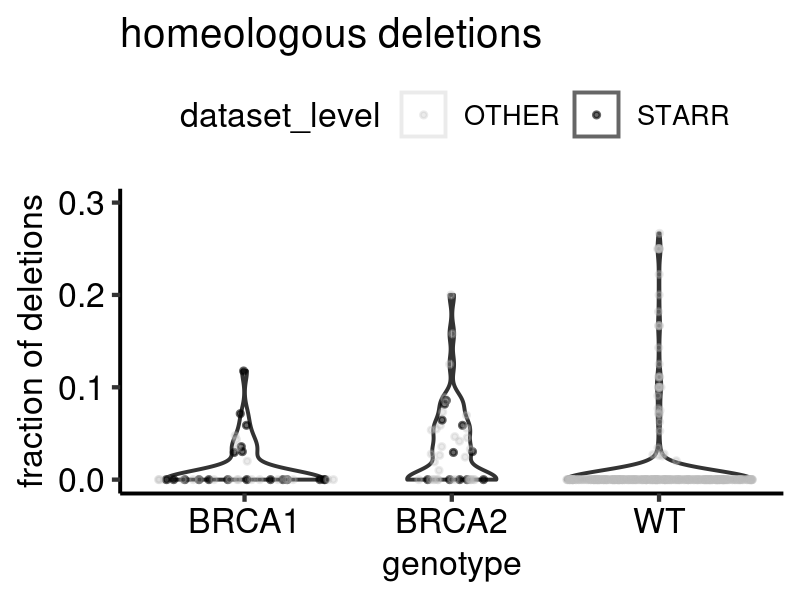

In [373]:
options(repr.plot.height = 3, repr.plot.width = 4)
pt

## Figure 4e
Junction span (distance between breakends) of homeologous 10X LRS and WGS deletions in BRCA2d tumors. 

In [374]:
junctions.dt = readRDS("./data/revision.junctions.dt.rds")
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

In [375]:
dels.dt = junctions.dt[(hrd_tbl[sample, aug_bopp_cohort]) &
                       (!is.na(del)) &
                       (hrd_tbl[sample, fmut_bi %in% c("BRCA1", "BRCA2", "WT")])]

dels.dt[, genotype := hrd_tbl[sample, fmut_bi]]
dels.dt[, dataset := hrd_tbl[sample, dataset]]

In [376]:
pt = ggplot(dels.dt[genotype == "BRCA2"][hlen >= 30], aes(x = span)) +
geom_density(fill = alpha("gray", 0.6), color = NA, stat = "density", bw = 0.2) +
scale_x_continuous(trans = "log10", limits = c(1e2, 1e6)) +
labs(x = "junction span (log10 bp)", y = "density", title = "homeologous deletions") +
ggpubr::theme_pubr()

Warning message:
“Removed 2 rows containing non-finite values (`stat_density()`).”


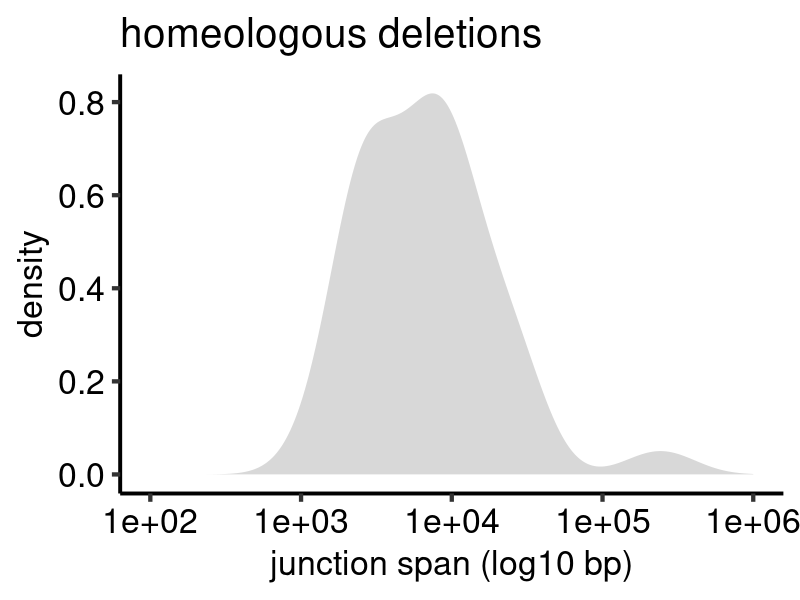

In [377]:
options(repr.plot.height = 3, repr.plot.width = 4)
pt

# Extended data figure 7
Read MAPQ at homeologous junctions

## EDF7a

Comparison of mapping quality for reads supporting homeologous and non-homeologous junctions. Left, density plot showing mapping quality for junction-supporting reads realigned to hg19, from a subsample of 500 non-homeologous junctions and 500 homeologous junctions. Middle, barplot of the fraction of reads with high mapping quality (MQ=60). Error bars represent 95% confidence interval on the Bernoulli trial parameter calculated using the fraction of non-homeologous (73,871 / 95,934) or homeologous (16,954 / 31,078) junction supporting reads that had MQ of 60. Right, barplot of the fraction of reads stacked by intervals of mapping quality.

In [378]:
dat = readRDS("./data/homeology/realign_homeology_reads.rds")

In [379]:
pt = ggplot(dat, aes(x = as.numeric(mapq), y = is_homeologous)) +
ggridges::geom_density_ridges(alpha = 0.5, color = NA) +
labs(x = "read MAPQ", y = "homeologous junction", title = "MAPQ of junction-supporting reads") +
ggpubr::theme_pubr()

Picking joint bandwidth of 2.65



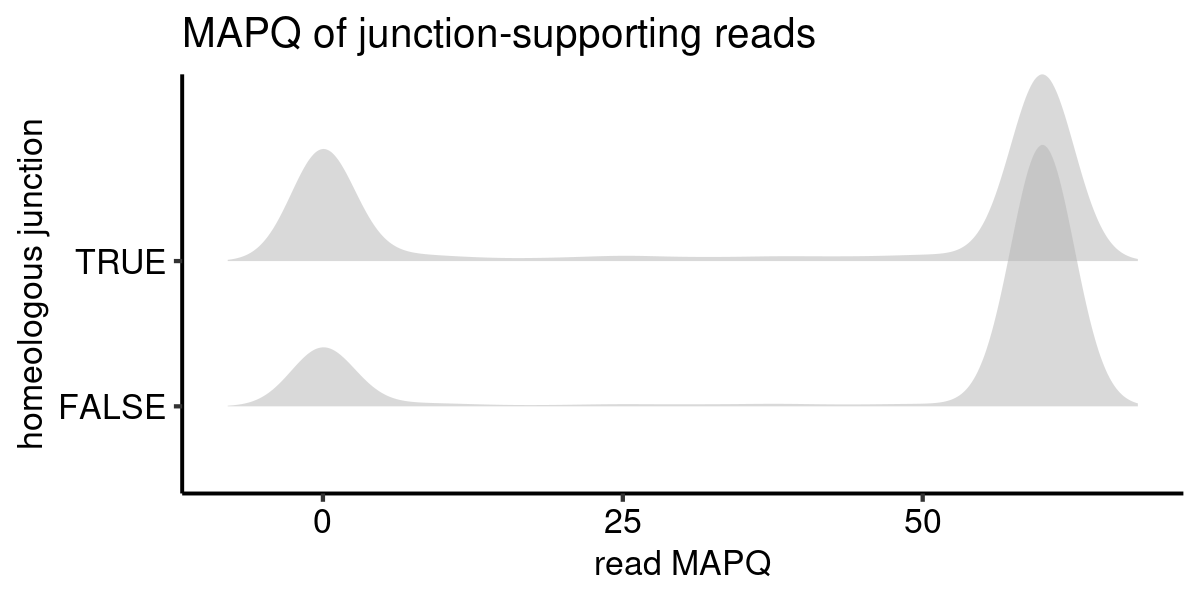

In [380]:
options(repr.plot.width = 6, repr.plot.height = 3)
pt

In [381]:
pt.dt = dat[, .(nreads = .N, high.mapq = .SD[as.numeric(mapq) == 60, .N]), by = is_homeologous]
pt.dt[, frac := high.mapq / nreads]
pt.dt[, ci.lower := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.lower}, high.mapq, nreads) %>% unlist] 
pt.dt[, ci.upper := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.upper}, high.mapq, nreads) %>% unlist] 

pt = ggplot(pt.dt, aes(x = is_homeologous, y = frac)) +
geom_bar(alpha = 0.5, color = NA, stat = "identity") +
geom_errorbar(aes(ymin = ci.lower, ymax = ci.upper),
             width = 0.2, position = "dodge") +
ylim(0, 1) +
labs(x = "homeologous junction", y = "fraction of junction-supporting reads", title = "MAPQ=60") +
ggpubr::theme_pubr()

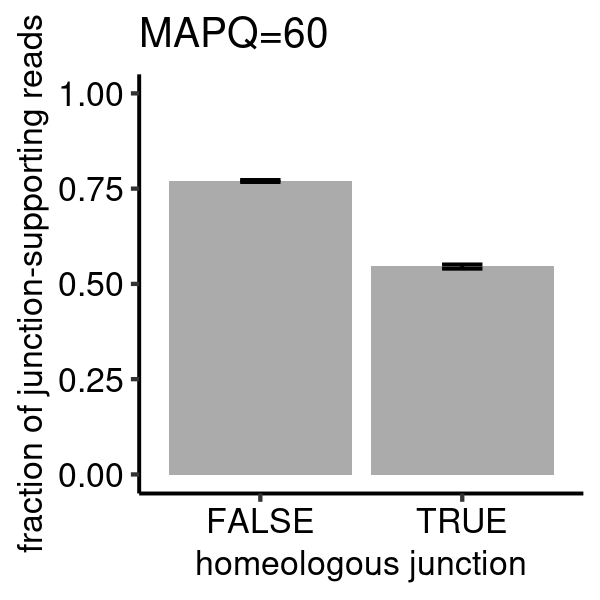

In [382]:
options(repr.plot.width = 3, repr.plot.height = 3)
pt

In [1791]:
mapq.levels = c(-1000, 29, 39, 49, 59, 60)
mapq.labels = c("0-29", "30-39", "40-49", "50-59", "60")

dat[, mapq.cut := cut(as.numeric(mapq), mapq.levels, mapq.labels)]

pt = ggplot(dat, aes(x = is_homeologous, fill = mapq.cut)) +
geom_bar(alpha = 0.5, color = NA, position = "fill") +
ylim(0, 1) +
labs(x = "homeologous junction", y = "fraction of junction-supporting reads", title = "MAPQ=60") +
ggpubr::theme_pubr() +
theme(legend.position = "right")

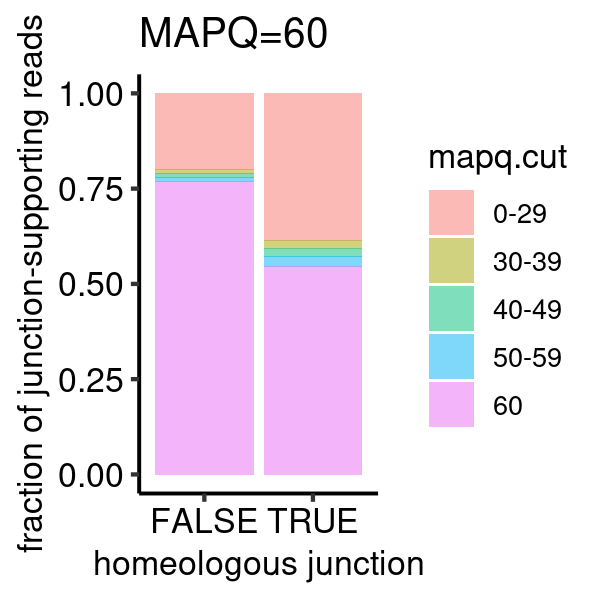

In [1792]:
options(repr.plot.width = 3, repr.plot.height = 3)
pt

## EDF7b
Left, reference 150-mer BWA mapping quality in the neighborhood of homeologous and non-homeologous breakends. Reference mapping quality determined by realigning sliding window of 150-mers from hg19 stepping by 1 base to hg19 and averaging across each base pair. Right, plot of alternate mappability scores calculated as the average of the reciprocal of the number of unique locations that each 150-mer overlapping a breakend-associated base pair aligns.

In [383]:
## get junction breakends
junctions.dt = readRDS("./data/revision.junctions.dt.rds")

In [384]:
bp.dt = rbind(junctions.dt[, .(seqnames = seqnames.1, start = start.1, end = start.1, strand = strand.1,
                               edge.id, hlen, sample, del, bp1 = TRUE)],
              junctions.dt[, .(seqnames = seqnames.2, start = start.2, end = start.2, strand = strand.2,
                               edge.id, hlen, sample, del, bp1 = FALSE)])

## subset for just deletions
bp.dt = bp.dt[!is.na(del)]

## downsample
bp.dt[, sample.ix := sample(1:.N, .N), by = .(hlen >= 30)]
bp.dt = bp.dt[sample.ix <= 1e3]

### GEM mappability

In [386]:
## mappability = rtracklayer::import('/gpfs/commons/groups/imielinski_lab/DB/GATK/human_g1k_v37_decoy_mappability_150.bedGraph')
## mappability$map_score = mappability$score
## mappability$score = NULL 

In [391]:
## subsample.bp.gr = dt2gr(bp.dt)
## gr.map.hom = gr.val(subsample.bp.gr + 200, mappability, "map_score")

## saveRDS(gr.map.hom, "./data/homeology/breakpoints.with.mappability.rds", )

In [392]:
gr.map.hom = readRDS("data/homeology/breakpoints.with.mappability.rds")

In [393]:
pt = ggplot(as.data.table(gr.map.hom)[!is.na(hlen)], aes(x = map_score, y = hlen >= 30)) +
geom_density_ridges(alpha = 0.3, color = NA) +
labs(title = "hg19 GEM mappability (150-mer)", x = "mappability", y = "homeologous junction") +
ggpubr::theme_pubr()

Picking joint bandwidth of 0.0256



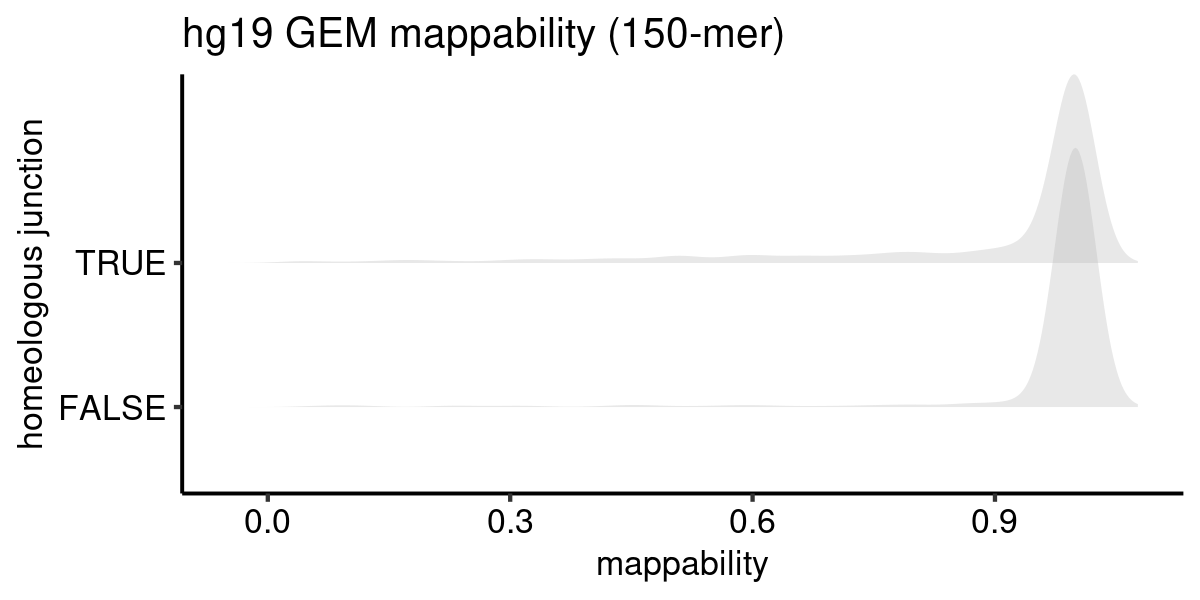

In [394]:
options(repr.plot.width = 6, repr.plot.height = 3)
pt

### hg19 150-mer mappability

In [395]:
## map.150.jb = readRDS("~/DB/hg19.refererence.mappability/150mer.mapq.granges.rds")

In [396]:
## map.150.gr = gr.val(subsample.bp.gr + 200, dt2gr(map.150.jb), "mapq")
## saveRDS(map.150.gr, "./data/homeology/breakpoints.with.150mer.mappability.rds" )

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 25 out-of-bound ranges located on sequences 17,
  4, 11, 2, X, Y, 19, 9, hs37d5, 22, 15, 5, 12, 7, 20, 10, 3, 1, 21, 6,
  16, 14, 13, 8, and 18. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in gr.findoverlaps(query, target, scol = by, verbose = verbose, :
“findOverlaps applied to ranges with non-identical seqlengths”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1 out-of-bound range located on sequence
  hs37d5. Note that ranges located on a sequence whose length is unknown
  (NA) or on a circular sequence are not considered out-of-boun

In [397]:
map.150.gr = readRDS("./data/homeology/breakpoints.with.150mer.mappability.rds" )

In [398]:
pt = ggplot(as.data.table(map.150.gr)[!is.na(hlen)], aes(x = mapq, y = hlen >= 30)) +
geom_density_ridges(alpha = 0.3, color = NA) +
labs(title = "hg19 150-mer MAPQ score", x = "MAPQ", y = "homeologous junction") +
ggpubr::theme_pubr()

Picking joint bandwidth of 0.837



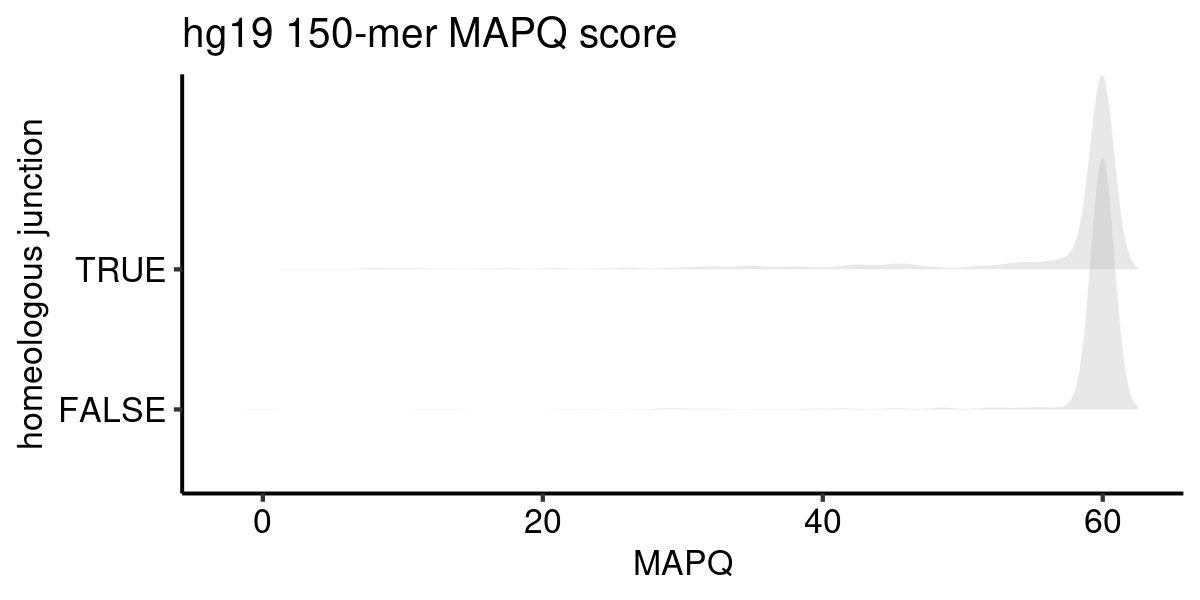

In [399]:
options(repr.plot.width = 6, repr.plot.height = 3)
pt